### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']


In [2]:
from datetime import datetime, timedelta
import os
import yaml
import sqlite3
import json
from collections import Counter
import uuid
from typing import TypedDict, Annotated
import subprocess
import requests
import re

import operator
import pickle

import langchain
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage, AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import (ChatPromptTemplate, MessagesPlaceholder, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver

from langchain_core.output_parsers import SimpleJsonOutputParser, JsonOutputParser, StrOutputParser

from langgraph.graph import StateGraph, START, END

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

import numpy as np
import pandas as pd
import umap

import sklearn
from sklearn.cluster import DBSCAN

import bs4
from urllib.parse import urljoin, urlparse

import multiprocessing
import asyncio
import aiohttp

from IPython.display import HTML, Image, Markdown, display
import markdown

import openai
from openai import OpenAI

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate


import dotenv
VERBOSE=1
from ainb_const import (DOWNLOAD_DIR, PAGES_DIR,
                        MODEL, LOWCOST_MODEL, HIGHCOST_MODEL, CANONICAL_TOPICS,
                        SOURCECONFIG, FILTER_PROMPT, TOPIC_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT, FINAL_SUMMARY_PROMPT, 
                        TOP_CATEGORIES_PROMPT, REWRITE_PROMPT,
                        MAX_INPUT_TOKENS, MAX_OUTPUT_TOKENS, MAX_RETRIES, TEMPERATURE, SQLITE_DB,
                        HOSTNAME_SKIPLIST, SITE_NAME_SKIPLIST, TOPSOURCES
                       )
from ainb_utilities import (log, delete_files, filter_unseen_urls_db, insert_article,
                            nearest_neighbor_sort, agglomerative_cluster_sort, traveling_salesman_sort_scipy,
                            unicode_to_ascii, send_gmail)
from ainb_webscrape import (get_driver, quit_drivers, launch_drivers, get_file, get_url, parse_file,
                            get_og_tags, get_path_from_url, trimmed_href, process_source_queue_factory,
                            process_url_queue_factory, get_google_news_redirects)
from ainb_llm import (paginate_df, process_pages, fetch_pages, fetch_openai, fetch_all_summaries,
                      fetch_openai_summary, count_tokens, trunc_tokens, 
                      categorize_headline, categorize_df, clean_topics,
                      get_site_name, fetch_missing_site_names)


import asyncio
# need this to run async in jupyter since it already has an asyncio event loop running
import nest_asyncio
nest_asyncio.apply()


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")


Python            3.11.10 | packaged by conda-forge | (main, Sep 10 2024, 10:57:35) [Clang 17.0.6 ]
LangChain         0.3.3
OpenAI            1.52.0
trafilatura       1.12.2
numpy             1.26.4
pandas            2.2.3
sklearn           1.5.2
umap              0.5.6


# Test LLM calling

In [ ]:
# a basic LLM call with langchain
model = ChatOpenAI(model=MODEL)

model.invoke([
    SystemMessage(content="Translate the following from English into Italian"),
    HumanMessage(content='Listen to me. You are beautiful. You are perfect and I love you.'),
])


In [ ]:
# use a langchain template
system_template = "Translate the following into {language}:"
prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
parser = StrOutputParser()
chain = prompt_template | model | parser
chain.invoke({"language": "italian", "text": "hi"})


In [ ]:
# time multiple templants (single-threaded)
prompt_inputs = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

system_template = 'Translate the following into {language}:'
user_template = 'Listen to me. You are {adjective1}. You are {adjective2} and I love you.'

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template),
     ("user", user_template)]
)

parser = StrOutputParser()

chain = prompt_template | model | parser

start_time = datetime.now()
for tpl in prompt_inputs:
    response = ""
    # stream tokens as they are generated
    for r in chain.stream(tpl):
        print(r, end="")
        response += r
end_time = datetime.now()

difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")


In [ ]:
# same but send all at once using asyncio

async def async_langchain(chain, input_dict):
    response = await chain.ainvoke(input_dict)
    return response


prompt_templates = [
    {"language": "French", "adjective1": "flawless", "adjective2": "beautiful"},
    {"language": "German", "adjective1": "immaculate", "adjective2": "exquisite"},
    {"language": "Spanish", "adjective1": "perfect", "adjective2": "gorgeous"},
    {"language": "Italian", "adjective1": "amazing", "adjective2": "magnificent"},
    {"language": "Hungarian", "adjective1": "ravishing", "adjective2": "stunning"},
]

start_time = datetime.now()
tasks = []
for d in prompt_templates:
    task = asyncio.create_task(async_langchain(chain, d))
    tasks.append(task)
responses = await asyncio.gather(*tasks)
end_time = datetime.now()


difference = end_time - start_time
total_seconds = difference.total_seconds()
print(f"\n\nElapsed seconds: {total_seconds:.6f}")
print("\n".join(responses))


In [ ]:
# test o1-preview, note temperature, system prompt not supported
# client = OpenAI()
# response = client.chat.completions.create(
#     model="o1-preview",
#     messages=[
#         {
#             "role": "user",
#             "content": "Write a Python script that takes a matrix represented as a string with format '[1,2],[3,4],[5,6]' and prints the transpose in the same format."
#         }
#     ]
# )
# print(response.choices[0].message.content)


# Functions for state graph
- Each takes a state dict and returns updated state dict
- We will use these later to construct a LangGraph agent workflow

In [4]:
DEBUG = False
N_BROWSERS = 4
MAX_EDITS = 3
before_date = None
# before_date = '2024-10-19 15:00:00'
do_download = True


In [5]:
# class to maintain state within graph

class AgentState(TypedDict):
    AIdf: dict                #  the current working set of headlines (pandas dataframe not supported)
    before_date: str          #  ignore stories before this date for deduplication (force reprocess since)
    do_download: bool         #  if False use existing files, else download from sources
    sources: dict             #  sources to scrap
    sources_reverse: dict     #  map file names to sources
    bullets: list             #  bullet points for summary email
    summary: str              #  final summary
    cluster_topics: list      #  list of cluster topics
    n_edits: int              #  count edit iterations so we don't keep editing forever
    edit_complete: bool       #  edit will update if no more edits to make
    # message thread with OpenAI
    # messages: Annotated[list[AnyMessage], operator.add]


In [6]:
test_state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
#     'messages': None
    }
)


In [7]:
# Initialize reading configurations from YAML file

def fn_initialize(state: AgentState) -> AgentState:
    """
    Initializes the agent state by loading source configurations from SOURCECONFIG (sources.yaml) .

    Args:
        state (AgentState): The current state of the agent.
        verbose (bool, optional): Whether to print verbose output. Defaults to False.

    Returns:
        AgentState: The updated state of the agent.

    Raises:
        yaml.YAMLError: If there is an error while loading the YAML file.

    """

    #  load sources to scrape from sources.yaml
    with open(SOURCECONFIG, "r") as stream:
        try:
            state['sources'] = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)

    log(f"Initialized {len(state['sources'])} items in sources from {SOURCECONFIG}")

    # make a reverse dict to map file titles to source names
    state['sources_reverse'] = {}
    for k, v in state['sources'].items():
        log(f"{k} -> {v['url']} -> {v['title']}.html")
        v['sourcename'] = k
        # map filename (title) to source name
        state['sources_reverse'][v['title']] = k

    log(f"Initialized {len(state['sources_reverse'])} items in sources_reverse")

    return state


if DEBUG:
    test_state = fn_initialize(test_state)


In [8]:
# scrape sources with selenium and save local files in DOWNLOAD_DIR (htmldata)
def fn_download_sources(state: AgentState) -> AgentState:
    """
    Scrapes sources and saves HTML files.
    If state["do_download"] is True, deletes all files in DOWNLOAD_DIR (htmldata) and scrapes fresh copies.
    If state["do_download"] is False, uses existing files in DOWNLOAD_DIR.
    Uses state["sources"] for config info on sources to scrape
    For each source, saves the current filename to state["sources"][sourcename]['latest']

    Args:
        state (AgentState): The current state of the agent.
        do_delete (bool, optional): Whether to delete files in DOWNLOAD_DIR. Defaults to True.

    Returns:
        AgentState: The updated state of the agent.
    """

    if state["do_download"]:
        # empty download directories
        delete_files(DOWNLOAD_DIR)
        delete_files(PAGES_DIR)

        # save each file specified from sources
        log(f"Saving HTML files using {N_BROWSERS} browsers")

        # Create a queue for multiprocessing and populate it
        queue = multiprocessing.Queue()
        for item in state["sources"].values():
            queue.put(item)

        # Function to take the queue and pop entries off and process until none are left
        # lets you create an array of functions with different args
        callable = process_source_queue_factory(queue)

        saved_pages = launch_drivers(N_BROWSERS, callable)
        for sourcename, file in saved_pages:
            log(f"Downloaded {sourcename} to {file}")
            state['sources'][sourcename]['latest'] = file
        log(f"Saved {len(saved_pages)} HTML files")

    else:   # use existing files
        log(f"Web fetch disabled, using existing files in {DOWNLOAD_DIR}")
        # Get the current date
        datestr = datetime.now().strftime("%m_%d_%Y")
        files = [os.path.join(DOWNLOAD_DIR, file)
                 for file in os.listdir(DOWNLOAD_DIR)]
        # filter files with today's date ending in .html
        files = [
            file for file in files if datestr in file and file.endswith(".html")]
        log(f"Found {len(files)} previously downloaded files")
        for file in files:
            log(file)

        saved_pages = []
        for file in files:
            filename = os.path.basename(file)
            # locate date like '01_14_2024' in filename
            position = filename.find(" (" + datestr)
            basename = filename[:position]
            # match to source name
            sourcename = state["sources_reverse"].get(basename)
            if sourcename is None:
                log(f"Skipping {basename}, no sourcename metadata")
                continue
            state["sources"][sourcename]['latest'] = file

    return state

if DEBUG:
    test_state = fn_download_sources(test_state)


In [9]:
def fn_extract_urls(state: AgentState) -> AgentState:
    """
    Extracts news URLs from the latest HTML files matching the patterns defined in the state['sources'] configuration info.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted URLs stored in state['AIdf'].
    """
    # Parse news URLs and titles from downloaded HTML files
    log("Parsing html files")
    all_urls = []
    for sourcename, sourcedict in state['sources'].items():
        filename = sourcedict.get('latest')
        if not filename:
            log(f"no filename found for {sourcename}")
            continue

        log(sourcename + ' -> ' + filename)
        links = parse_file(state['sources'][sourcename])
        log(f"{len(links)} links found")
        all_urls.extend(links)

    log(f"Saved {len(all_urls)} links")

    # make a pandas dataframe of all the links found
    AIdf = (
        pd.DataFrame(all_urls)
        .groupby("url")
        .first()
        .reset_index()
        .sort_values("src")[["src", "title", "url"]]
        .reset_index(drop=True)
        .reset_index(drop=False)
        .rename(columns={"index": "id"})
    )
    state['AIdf'] = AIdf.to_dict(orient='records')

    return state


if DEBUG:
    test_state = fn_extract_urls(test_state)

    # s/b 17 but if some like bloomberg" or wsj are missing, maybe got a robot block
    # if so, download missing ones manually and then re-run fn_extract_urls
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])


In [10]:
# get AI news via newscatcher
# https://docs.newscatcherapi.com/api-docs/endpoints/search-news

newscatcher_sources = ['247wallst.com',
 '9to5mac.com',
 'androidauthority.com',
 'androidcentral.com',
 'androidheadlines.com',
 'appleinsider.com',
 'benzinga.com',
 'cnet.com',
 'cnn.com',
 'digitaltrends.com',
 'engadget.com',
 'fastcompany.com',
 'finextra.com',
 'fintechnews.sg',
 'fonearena.com',
 'ft.com',
 'gadgets360.com',
 'geekwire.com',
 'gizchina.com',
 'gizmochina.com',
 'gizmodo.com',
 'gsmarena.com',
 'hackernoon.com',
 'howtogeek.com',
 'ibtimes.co.uk',
 'itwire.com',
 'lifehacker.com',
 'macrumors.com',
 'mashable.com',
#  'medium.com',
 'mobileworldlive.com',
 'msn.com',
 'nypost.com',
 'phonearena.com',
 'phys.org',
 'popsci.com',
 'scmp.com',
 'sify.com',
 'siliconangle.com',
 'siliconera.com',
 'siliconrepublic.com',
 'slashdot.org',
 'slashgear.com',
 'statnews.com',
 'tech.co',
 'techcrunch.com',
 'techdirt.com',
 'technode.com',
 'technologyreview.com',
 'techopedia.com',
 'techradar.com',
 'techraptor.net',
 'techtimes.com',
 'techxplore.com',
 'telecomtalk.info',
 'thecut.com',
 'thedrum.com',
 'thehill.com',
 'theregister.com',
 'theverge.com',
 'thurrott.com',
 'tipranks.com',
 'tweaktown.com',
 'videocardz.com',
 'washingtonpost.com',
 'wccftech.com',
 'wired.com',
 'xda-developers.com',
 'yahoo.com',
 'zdnet.com']

def fn_extract_newscatcher(state: AgentState) -> AgentState:
    
    q = 'Artificial Intelligence'
    page_size = 100
    log(f"Fetching top {page_size} stories matching {q} from Newscatcher")
    base_url = "https://api.newscatcherapi.com/v2/search"
    time_24h_ago = datetime.now() - timedelta(hours=24)

    # Put API key in headers 
    headers = {'x-api-key': os.getenv('NEWSCATCHER_API_KEY')}

    # Define search parameters
    params = {
        'q': q,
        'lang': 'en',
        'sources': ','.join(newscatcher_sources),
        'from': time_24h_ago.strftime('%Y-%m-%d %H:%M:%S'),
        'to': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'page_size': page_size, # by default should be most highly relevant to the search
        'page': 1
        }

    # Make API call with headers and params
    response = requests.get(base_url, headers=headers, params=params)

    # Encode received results
    results = json.loads(response.text.encode())
    if response.status_code != 200:
        print('ERROR: API call failed.')
        print(results)
        
    # merge into existing df
    newscatcher_df = pd.DataFrame(results['articles'])[['title', 'link']]
    newscatcher_df['src']='Newscatcher'
    newscatcher_df = newscatcher_df.rename(columns={'link': 'url'})
#     display(newscatcher_df.head())
    AIdf = pd.DataFrame(state['AIdf'])
#     display(AIdf.head())
    
    max_id = AIdf['id'].max()
    # add id column to newscatcher_df
    newscatcher_df['id'] = range(max_id + 1, max_id + 1 + len(newscatcher_df))
    AIdf = pd.concat([AIdf, newscatcher_df], ignore_index=True)
    state['AIdf'] = AIdf.to_dict(orient='records')
    return state
    

if DEBUG:
    test_state = fn_extract_newscatcher(test_state)
    print(len(pd.DataFrame(test_state["AIdf"]).groupby('src').count()))
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    

In [11]:
# some debugging stuff
# zdf = pd.DataFrame(test_state["AIdf"])
# zdf.loc[zdf["src"]=='Techmeme']

# connection = sqlite3.connect('articles.db')
# xdf = pd.read_sql_query("SELECT * FROM news_articles", connection)
# connection.close()

# zdf.loc[zdf["title"].str.startswith("NHTSA")] 
# xdf.loc[xdf["title"].str.startswith("NHTSA")] 

# pd.set_option('display.max_rows', 300)  # Ensure up to 300 rows are shown

# xdf.loc[xdf['isAI']> 0].groupby('actual_src') \
#     .count() \
#     .reset_index()[['actual_src', 'id']] \
#     .sort_values('id', ascending=False) \
#     .head(300)


In [12]:
# sqlite schema to store previously processed 
# CREATE TABLE news_articles (
#     id INTEGER PRIMARY KEY,
#     src TEXT,
#     title TEXT,
#     url TEXT UNIQUE,
#     isAI BOOLEAN,
#     article_date DATE
# , timestamp DATETIME, actual_url TEXT, actual_src TEXT);
#
# CREATE TABLE sites (
#     id INTEGER PRIMARY KEY AUTOINCREMENT,
#     hostname TEXT UNIQUE NOT NULL,
#     site_name TEXT NOT NULL
# );



In [13]:
# filter and clean URLs for new AI stories

def fn_filter_urls(state: AgentState) -> AgentState:
    """
    Filters the URLs in state["AIdf"] to include only those that have not been previously seen,
    and are related to AI according to the response from a ChatGPT prompt.

    Args:
        state (AgentState): The current state of the agent.
        before_date (str, optional): The date before which the URLs should be filtered. Defaults to "".

    Returns:


        AgentState: The updated state of the agent with the filtered URLs stored in state["AIdf"].

    """
    # filter to URL not previously seen
    AIdf = pd.DataFrame(state["AIdf"])

    AIdf = filter_unseen_urls_db(AIdf, before_date=state["before_date"])

    if len(AIdf) == 0:
        log("No new URLs, returning")
        return state

    # dedupe identical headlines
    # filter similar titles differing by type of quote or something
    AIdf['title'] = AIdf['title'].apply(unicode_to_ascii)
    AIdf['title_clean'] = AIdf['title'].map(lambda s: "".join(s.split()))
    AIdf = AIdf.sort_values("src") \
        .groupby("title_clean") \
        .first() \
        .reset_index(drop=True) \
        .drop(columns=['id']) \
        .reset_index() \
        .rename(columns={'index': 'id'})
    log(f"Found {len(AIdf)} unique new headlines")

    # structured response format
    json_schema = {
        "name": "json_schema",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "isai_array": {
                    "type": "array",
                    "items": {
                        "type": "object",
                                "properties": {
                                    "id": {
                                        "type": "number"
                                    },
                                    "isAI": {
                                        "type": "boolean"
                                    }
                                },
                        "required": ["id", "isAI"],
                        "additionalProperties": False
                    }
                }
            },
            "required": ["isai_array"],
            "additionalProperties": False
        }
    }

    # filter AI-related headlines using a prompt
    pages = paginate_df(AIdf)
    enriched_urls = asyncio.run(fetch_pages(pages, prompt=FILTER_PROMPT, json_schema=json_schema))
    filter_df = pd.DataFrame(enriched_urls)
    
    try:  # for idempotency
        AIdf = AIdf.drop(columns=['isAI'])
    except:
        pass

    # merge returned df with isAI column into original df on id column
    AIdf = pd.merge(AIdf, filter_df, on="id", how="outer")
    log(AIdf.columns)
    # set hostname based on actualurl
    AIdf['actual_url'] = AIdf['url']    # ideally resolve redirects but Google News blocks
    AIdf['hostname']=AIdf['actual_url'].apply(lambda url: urlparse(url).netloc)

    # update SQLite database with all seen URLs (we are doing this using url and ignoring redirects)
    log(f"Inserting {len(AIdf)} URLs into {SQLITE_DB}")
    conn = sqlite3.connect(SQLITE_DB)
    cursor = conn.cursor()
    for row in AIdf.itertuples():
        insert_article(conn, cursor, row.src, row.hostname, row.title,
                       row.url, row.actual_url, row.isAI, datetime.now().date())

    # keep headlines that are related to AI
    AIdf = AIdf.loc[AIdf["isAI"]==1] \
        .reset_index(drop=True)  \
        .reset_index()  \
        .drop(columns=["id"])  \
        .rename(columns={'index': 'id'})

    log(f"Found {len(AIdf)} AI headlines")

    # update actual URLs for Google News redirects
    # I think Google changed something so this no longer works, instead of a 301 redirct
    # get a javascript page that redirects. Also tomorrow we might see different URLs for same stories
    # AIdf = get_google_news_redirects(AIdf)

    conn = sqlite3.connect('articles.db')
    query = "select * from sites"
    sites_df = pd.read_sql_query(query, conn)
    sites_dict = {row.hostname:row.site_name for row in sites_df.itertuples()}
    conn.close()

    # get clean site_name
    AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))

    # if any missing clean site names, populate them using OpenAI
    missing_site_names =  len(AIdf.loc[AIdf['site_name']==""])
    if missing_site_names:
        log(f"Asking OpenAI for {missing_site_names} missing site names")
        responses = asyncio.run(fetch_missing_site_names(AIdf))
        # update site_dict from responses
        new_urls = []
        for r in responses:
            if r['url'].startswith('https://'):
                r['url'] = r['url'][8:]
            new_urls.append(r['url'])
            sites_dict[r['url']] = r['site_name']
            log(f"Looked up {r['url']} -> {r['site_name']}")
        # update sites table with new names
        for url in new_urls:
            sqlstr = "INSERT OR IGNORE INTO sites (hostname, site_name) VALUES (?, ?);"
            log(f"Updated {url} -> {sites_dict[url]}")
            conn.execute(sqlstr, (url, sites_dict[url]))
            conn.commit()
        # reapply to AIdf with updated sites
        AIdf['site_name'] = AIdf['hostname'].apply(lambda hostname: sites_dict.get(hostname, hostname))
    else:
        log("No missing site names")
  
    # drop banned slop sites

    AIdf = AIdf.loc[~AIdf["hostname"].str.lower().isin(HOSTNAME_SKIPLIST)]
    AIdf = AIdf.loc[~AIdf["site_name"].str.lower().isin(SITE_NAME_SKIPLIST)]
    
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_filter_urls(test_state)
    display(pd.DataFrame(test_state["AIdf"]).groupby('src').count()[['id']])
    display(list(pd.DataFrame(test_state["AIdf"]).columns))



In [14]:
# for row in pd.DataFrame(test_state["AIdf"]).itertuples():
#     display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


In [15]:
# Function for topic extraction
# TODO: could send more prompts to gpt-4o-mini and not hit rate limits
def clean_topics(row, lcategories):
    """
    Cleans the extracted_topics and assigned_topics by removing certain common topics and combining them into a single list.

    Args:
        row (pandas.Series): The row containing the extracted_topics and assigned_topics.
        lcategories (set): The set of lowercase categories.

    Returns:
        list: The cleaned and combined list of topics.
    """
    extracted_topics = [x.title() for x in row.extracted_topics if x.lower() not in {"technology", "ai", "artificial intelligence"}]
    assigned_topics = [x.title() for x in row.assigned_topics if x.lower() in lcategories]
    combined = sorted(list(set(extracted_topics + assigned_topics)))
    combined = [s.replace("Ai", "AI") for s in combined]
    combined = [s.replace("Genai", "Gen AI") for s in combined]
    combined = [s.replace("Openai", "OpenAI") for s in combined]

    return combined


async def do_cat(AIdf, categories):
    """
    Sends a prompt to ChatGPT to select topics for the title for each row in AIdf
    which match the topics in categories.

    Args:
        AIdf (pandas.DataFrame): The DataFrame containing the headlines.
        categories (list): The list of topics to match with the headlines.

    Returns:
        dict: A dictionary where the keys are the row IDs and the values are lists
        of selected topics for each headline.

    """

    catdict = {}
    async with aiohttp.ClientSession() as session:
        for i, row in enumerate(AIdf.itertuples()):
            tasks = []
            log(f"Categorizing headline {row.id+1} of {len(AIdf)}")
            h = row.title
            log(h)
            for c in categories:
                task = asyncio.create_task(categorize_headline(h, c, session))
                tasks.append(task)
            responses = await asyncio.gather(*tasks)
            catdict[row.id] = [item for sublist in responses for item in sublist]
            log(str(catdict[row.id]))

    return catdict


def fn_topic_analysis(state: AgentState) -> AgentState:

    """
    Extracts and selects topics for each headline in the state['AIdf'] dataframe, scrubs them, and stores them back in the dataframe.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the extracted and selected topics stored in state['AIdf'].
    """
    AIdf = pd.DataFrame(state["AIdf"])
    pages = paginate_df(AIdf)
    # apply topic extraction prompt to AI headlines
    log("start free-form topic extraction")
    json_schema = {
        "name": "extracted_topics",
        "strict": True,
        "schema": {
            "type": "object",
            "properties": {
                "extracted_topics": {
                    "type": "array",
                    "items": {
                        "type": "object",
                        "properties": {
                            "id": {
                                "type": "number",
                            },
                            "topics": {
                                "type": "array",
                                "items": {
                                    "type": "string",
                                },
                            },
                        },
                        "required": ["id", "topics"],
                        "additionalProperties": False,
                    }
                }
            },
            "required": ["extracted_topics"],
            "additionalProperties": False,
        }
    }
    response = asyncio.run(fetch_pages(pages, prompt=TOPIC_PROMPT, json_schema=json_schema))
    topic_df = pd.DataFrame(response)
    topic_df = topic_df.rename(columns={'topics': 'extracted_topics'})
    log(f"{len(topic_df)} free-form topics extracted")
    all_topics = [item.lower() for row in topic_df.itertuples() for item in row.extracted_topics]
    item_counts = Counter(all_topics)
    filtered_topics = [item for item in item_counts if item_counts[item] >= 2 and item not in {'technology', 'ai', 'artificial intelligence'}]

    categories = sorted(CANONICAL_TOPICS)
    # use categories that are canonical or show up twice in freeform
    lcategories = set([c.lower() for c in categories] + [c.lower() for c in filtered_topics])
    # new topics
    log([c for c in filtered_topics if c not in categories])

    catdict = asyncio.run(categorize_headline(AIdf, categories=categories))
    topic_df['assigned_topics'] = topic_df['id'].apply(lambda id: catdict.get(id, ""))

    topic_df["topics"] = topic_df.apply(lambda t: clean_topics(t, lcategories), axis=1)
    topic_df["topic_str"] = topic_df.apply(lambda row: ", ".join(row.topics), axis=1)

    try: # for idempotency
        AIdf = AIdf.drop(columns=['topic_str', 'title_topic_str'])
    except:
        pass

    AIdf = pd.merge(AIdf, topic_df[["id", "topic_str"]], on="id", how="outer")
    AIdf['title_topic_str'] = AIdf.apply(lambda row: f'{row.title} (Topics: {row.topic_str})', axis=1)

    state["AIdf"] = AIdf.to_dict(orient='records')
    return state

if DEBUG:
    test_state = fn_topic_analysis(test_state)


In [16]:
async def write_topic_name(topic_list_str, max_retries=3, model=LOWCOST_MODEL):
    """
    Generates a name for a cluster based on a list of headline topics.

    Parameters:
    session (aiohttp.ClientSession): The client session for making async HTTP requests.
    topic_list_str (str): A string containing the list of headline topics.
    max_retries (int, optional): The maximum number of retries in case of an error. Defaults to 3.
    model (str, optional): The model to use for generating the topic name. Defaults to LOWCOST_MODEL.

    Returns:
    dict: A dictionary containing the generated topic name.

    Example Usage:
    title_topic_str_list = "Headline 1 (Topic: Topic 1)\n\nHeadline 2 (Topic: Topic 2)"
    result = await write_topic_name(session, title_topic_str_list)
    print(result)

    Output:
    {"topic_title": "Generated Topic Name"}
    ```
    """
    TOPIC_WRITER_PROMPT = f"""
You are a topic writing assistant. I will provide a list of headlines with extracted topics in parentheses.
Your task is to propose a name for a topic that very simply, clearly and accurately captures all the provided
headlines in less than 7 words. You will output a JSON object with the key "topic_title".

Example Input:
In the latest issue of Caixins weekly magazine: CATL Bets on 'Skateboard Chassis' and Battery Swaps to Dispell Market Concerns (powered by AI) (Topics: Battery Swaps, Catl, China, Market Concerns, Skateboard Chassis)

AI, cheap EVs, future Chevy  the week (Topics: Chevy, Evs)

Electric Vehicles and AI: Driving the Consumer & World Forward (Topics: Consumer, Electric Vehicles, Technology)

Example Output:
{{"topic_title": "Electric Vehicles"}}

Task
Propose the name for the overall topic based on the following provided headlines and individual topics:

{topic_list_str}
"""

    for i in range(max_retries):
        try:
            messages=[
                      {"role": "user", "content": TOPIC_WRITER_PROMPT
                      }]

            payload = {"model":  model,
                       "response_format": {"type": "json_object"},
                       "messages": messages,
                       "temperature": 0
                       }
#             print(topic_list_str)

            async with aiohttp.ClientSession() as session:
                response = asyncio.run(fetch_openai(session, payload))
            response_dict = json.loads(response["choices"][0]["message"]["content"])
            log(response_dict)
            
            return response_dict
        except Exception as exc:
            log(f"Error: {exc}")

    return {}


def fn_topic_clusters(state: AgentState) -> AgentState:
    """
    Fetches embeddings for the headlines, creates clusters of similar articles using DBSCAN, and sorts
    using the clusters and a traveling salesman shortest traversal in embedding space.

    Parameters:
    state (AgentState): The state of the agent.

    Returns:
    AgentState: The updated state of the agent.

    """
    AIdf = pd.DataFrame(state["AIdf"])

    log(f"Fetching embeddings for {len(AIdf)} headlines")
    embedding_model = 'text-embedding-3-large'
    client = OpenAI()
    response = client.embeddings.create(input=AIdf['title_topic_str'].tolist(),
                                        model=embedding_model)
    embedding_df = pd.DataFrame([e.model_dump()['embedding'] for e in response.data])

    # greedy traveling salesman sort
    log(f"Sort with nearest_neighbor_sort sort")
    sorted_indices = nearest_neighbor_sort(embedding_df)
    AIdf['sort_order'] = sorted_indices

    # do dimensionality reduction on embedding_df and cluster analysis
    log(f"Load umap dimensionality reduction model")
    with open("reducer.pkl", 'rb') as file:
        # Load the model from the file
        reducer = pickle.load(file)
    log(f"Perform dimensionality reduction")
    reduced_data = reducer.transform(embedding_df)
    log(f"Cluster with DBSCAN")
    dbscan = DBSCAN(eps=0.4, min_samples=3)  # Adjust eps and min_samples as needed
    AIdf['cluster'] = dbscan.fit_predict(reduced_data)
    AIdf.loc[AIdf['cluster'] == -1, 'cluster'] = 999

    # sort first by clusters found by DBSCAN, then by semantic ordering
    AIdf = AIdf.sort_values(['cluster', 'sort_order']) \
        .reset_index(drop=True) \
        .reset_index() \
        .drop(columns=["id"]) \
        .rename(columns={'index': 'id'})

    # show clusters
    state["cluster_topics"] = []
    with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
        for i in range(30):
            try:
                tmpdf = AIdf.loc[AIdf['cluster']==i][["id", "title_topic_str"]]
                if len(tmpdf) ==0:
                    break
                display(tmpdf)
                title_topic_str_list = ("\n\n".join(tmpdf['title_topic_str'].to_list()))
                cluster_topic = asyncio.run(write_topic_name(title_topic_str_list))
                cluster_topic = cluster_topic['topic_title']
                state["cluster_topics"].append(cluster_topic)
                log(f"I dub this cluster: {cluster_topic}")
            except Exception as exc:
                log(exc)
    AIdf["cluster_name"] = AIdf['cluster'].apply(lambda i: state["cluster_topics"][i] 
                                                 if i < len(state["cluster_topics"]) 
                                                 else "")
    state["AIdf"] = AIdf.to_dict(orient='records')
    print(state["cluster_topics"])
    return state

# TODO: could add a quality rating for stories based on site reputation, length, complexity of story
# could then add the quality rating to the summaries and tell the prompt to favor high-quality stories
# could put summaries into vector store and retrieve stories by topic. but then you will have to deal
# with duplicates across categories, ask the prompt to dedupe

# def fn_topic_clusters(state: AgentState) -> AgentState:
#     "call async afn_topic_clusters on state"
#     state = asyncio.run(afn_topic_clusters(state))
#     return state


if DEBUG:
    test_state = fn_topic_clusters(test_state)


In [17]:
# scrape individual pages
def fn_download_pages(state: AgentState) -> AgentState:
    """
    Uses several Selenium browser sessions to download all the pages referenced in the
    state["AIdf"] DataFrame and store their pathnames.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent with the downloaded pages' pathnames stored in the `state["AIdf"]` DataFrame.
    """
    log("Queuing URLs for scraping")
    AIdf = pd.DataFrame(state['AIdf'])
    queue = multiprocessing.Queue()

    count = 0
    for row in AIdf.itertuples():
#         if row.cluster < 999:
        queue.put((row.id, row.url, row.title))
        count +=1
    # scrape urls in queue asynchronously
    num_browsers = 4

    callable = process_url_queue_factory(queue)

    log(f"fetching {count} pages using {num_browsers} browsers")
    saved_pages = launch_drivers(num_browsers, callable)

    pages_df = pd.DataFrame(saved_pages)
    if len(pages_df):
        pages_df.columns = ['id', 'url', 'title', 'path']

        try: # for idempotency
            AIdf = AIdf.drop(columns=['path'])
        except:
            pass        
        AIdf = pd.merge(AIdf, pages_df[["id", "path"]], on='id', how="inner")
    state["AIdf"] = AIdf.to_dict(orient='records')
    return state


if DEBUG:
    test_state = fn_download_pages(test_state)



In [18]:
# summarize individual pages

def fn_summarize_pages(state: AgentState) -> AgentState:
    """
    Reads all the articles, summarizes each one using a ChatGPT prompt, and sends an email with the summaries.

    Args:
        state (AgentState): The current state of the agent.

    Returns:
        AgentState: The updated state of the agent.

    """
    log("Starting summarize")
    AIdf = pd.DataFrame(state['AIdf'])
    responses = asyncio.run(fetch_all_summaries(AIdf))
    log(f"Received {len(responses)} summaries")
    response_dict = {}
    for i, response in responses:
        try:
            response_str = response["choices"][0]["message"]["content"]
            response_dict[i] = response_str
        except Exception as exc:
            print(exc)

    markdown_str = ''
    bullets = []

    for i, row in enumerate(AIdf.itertuples()):
        try:
            topics = []
            if row.cluster_name:
                topics.append(row.cluster_name)
            if row.topic_str:
                topics.append(row.topic_str)
            topic_str = ", ".join(topics)

            mdstr = f"[{i+1}. {row.title} - {row.site_name}]({row.actual_url})  \n\n {topic_str}  \n\n{response_dict[row.id]} \n\n"
            bullets.append(f"[{row.title} - {row.site_name}]({row.actual_url})\n\nTopics: {row.topic_str} \n\n{response_dict[row.id]}\n\n")
            display(Markdown(mdstr.replace("$","\\\\$")))
            markdown_str += mdstr
        except Exception as exc:
            print("Error:", exc)

    state['bullets'] = bullets
    # Convert Markdown to HTML
    html_str = markdown.markdown(markdown_str, extensions=['extra'])
    # save bullets
    with open('bullets.md', 'w') as f:
        f.write(markdown_str)
    # send email
    log("Sending bullet points email")
    subject = f'AI news bullets {datetime.now().strftime("%H:%M:%S")}'
    send_gmail(subject, html_str)

    return state


if DEBUG:
    test_state = fn_summarize_pages(test_state)



In [19]:
def fn_propose_cats(state: AgentState) -> AgentState:
    # ask chatgpt for top categories
    log(f"Proposing categories using {MODEL}")

    model = ChatOpenAI(
        model=MODEL,
        temperature=0.3,
        model_kwargs={"response_format": {"type": "json_object"}}
    )

    chain = ChatPromptTemplate.from_template("{p}") | model | SimpleJsonOutputParser()
    response = chain.invoke({ "p": TOP_CATEGORIES_PROMPT + "\n\n".join(state["bullets"])})
    suggested_categories = []
    for k, v in response.items():
        suggested_categories.extend(v)
    state["cluster_topics"] = list(set(state["cluster_topics"] + suggested_categories))
    state["cluster_topics"].sort()
    log(f"Proposed categories: {state['cluster_topics']}")
    return state


if DEBUG:
    test_state = fn_propose_cats(test_state)
    print("edit the following proposed topic list and update state['cluster_topics']:")
    print('"' + '",\n"'.join(test_state["cluster_topics"]) + '"')


In [20]:
def fn_compose_summary(state: AgentState) -> AgentState:
    log(f"Composing summary using {HIGHCOST_MODEL}")

    cat_str = "\n".join(state['cluster_topics'])
    bullet_str = "\n~~~\n".join(state["bullets"])
    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            }
        ]
    )
#     print(response)
    
#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(FINAL_SUMMARY_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "cat_str": cat_str, "bullet_str": bullet_str})
#     print(response)
    state["summary"] = response.choices[0].message.content

    return state


if DEBUG:
    test_state = fn_compose_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [21]:
#post manually to o1-preview and grab response b/c I don't have API yet
# cat_str = "\n".join(test_state['cluster_topics'])
# bullet_str = "\n~~~\n".join(test_state["bullets"])
# final_summary_prompt = FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
# count_tokens(final_summary_prompt)
# # copy to clipboard to paste in o1-preview
# subprocess.run("pbcopy", universal_newlines=True, input=final_summary_prompt)
# print(final_summary_prompt)


In [22]:
# test_state["summary"] = """
# """

# display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [23]:
def fn_rewrite_summary(state: AgentState) -> AgentState:

#     model = ChatOpenAI(
#         model=HIGHCOST_MODEL,
#         temperature=0.3,
#         model_kwargs={"response_format": {"type": "json_object"}}
#     )

#     chain = ChatPromptTemplate.from_template(REWRITE_PROMPT) | model | SimpleJsonOutputParser()
#     response = chain.invoke({ "summary": state["summary"]})
    log(f"Rewriting summary using {HIGHCOST_MODEL}")

    client = OpenAI()
    response = client.chat.completions.create(
        model=HIGHCOST_MODEL,
        messages=[
            {
                "role": "user",
                "content": REWRITE_PROMPT.format(summary=state["summary"])
            }
        ]
    )
    response_str = response.choices[0].message.content
    state["n_edits"] += 1    
    if response_str.strip().lower().startswith('ok'):
        log("No edits made, edit complete")
        state["edit_complete"] = True
    else:
        state["summary"] = response_str
    return state


if DEBUG:
    test_state = fn_rewrite_summary(test_state)
    display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [24]:
# rewrite_prompt = (REWRITE_PROMPT.format(summary=test_state["summary"]))
# subprocess.run("pbcopy", universal_newlines=True, input=rewrite_prompt)
# print(rewrite_prompt)


In [25]:
# test_state["summary"] = """
# """

# if DEBUG:
#     display(Markdown(test_state["summary"].replace("$","\\\\$")))


In [26]:
def fn_is_revision_complete(state: AgentState) -> str:
    """update edit_complete if MAX_EDITS exceeded"
    return "complete" if edit_complete else "incomplete"
    """

    if state["n_edits"] >= MAX_EDITS:
        log("Max edits reached")
        state["edit_complete"] = True


    return "complete" if state["edit_complete"] else "incomplete"


if DEBUG:
    test_state["edit_complete"] = fn_is_revision_complete(test_state)
    display(test_state["edit_complete"])


In [42]:
state["summary"]

"# AI Crossroads: Bans, Battles, and Breakthroughs\n\n## AI Cold War: US Tightens Grip on China Investments\n\n- US imposes AI investment restrictions on China - [MSN](https://www.msn.com/en-us/money/markets/ai-investment-in-china-faces-looming-us-restrictions/ar-AA1sGszw)\n\n## Power-Hungry AI: Tackling the Energy Crunch\n\n- AI's increasing energy demands prompt calls for sustainable solutions - [CleanTechnica](https://cleantechnica.com/2024/10/22/ai-data-centers-direct-air-capture-and-renewables/), [Bloomberg](https://www.bloomberg.com/opinion/articles/2024-10-22/ai-s-power-drain-demands-smart-demand-management)\n\n## AI Lawsuits: Scraping and Image Rights\n\n- Publishers sue Perplexity AI over unauthorized content scraping - [The Register](https://www.theregister.com/2024/10/22/publishers_sue_perplexity_ai/)\n- 'Blade Runner 2049' producer sues Tesla and Warner Bros over AI-generated imagery - [Yahoo Finance](https://finance.yahoo.com/news/blade-runner-2049-producer-sues-215107718.

In [51]:
from podcastfy.client import generate_podcast
from IPython.display import Audio, display


In [53]:
def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [57]:
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state["summary"])
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


Markdown content successfully saved to summary.md.


In [60]:
audio_file = generate_podcast(url_file="summary.md")


2024-10-22 18:44:17,652 - podcastfy.client - INFO - Processing 24 links
2024-10-22 18:44:17,652 - podcastfy.client - INFO - Processing 24 links
2024-10-22 18:44:17,666 - podcastfy.content_parser.content_extractor - ERROR - Error extracting content from # AI Crossroads: Bans, Battles, and Breakthroughs: Unsupported source type
2024-10-22 18:44:17,666 - podcastfy.client - ERROR - An error occurred in the process_content function: Unsupported source type
2024-10-22 18:44:17,666 - podcastfy.client - ERROR - An error occurred in the process_content function: Unsupported source type
2024-10-22 18:44:17,666 - podcastfy.client - ERROR - An error occurred: Unsupported source type
2024-10-22 18:44:17,666 - podcastfy.client - ERROR - An error occurred: Unsupported source type


ValueError: Unsupported source type

In [55]:
embed_audio(audio_file)


Audio player embedded for: ./data/audio/podcast_a6bf171d70fe45498edfbc52e979d365.mp3


In [48]:
display(Markdown(state["summary"]))

# AI Crossroads: Bans, Battles, and Breakthroughs

## AI Cold War: US Tightens Grip on China Investments

- US imposes AI investment restrictions on China - [MSN](https://www.msn.com/en-us/money/markets/ai-investment-in-china-faces-looming-us-restrictions/ar-AA1sGszw)

## Power-Hungry AI: Tackling the Energy Crunch

- AI's increasing energy demands prompt calls for sustainable solutions - [CleanTechnica](https://cleantechnica.com/2024/10/22/ai-data-centers-direct-air-capture-and-renewables/), [Bloomberg](https://www.bloomberg.com/opinion/articles/2024-10-22/ai-s-power-drain-demands-smart-demand-management)

## AI Lawsuits: Scraping and Image Rights

- Publishers sue Perplexity AI over unauthorized content scraping - [The Register](https://www.theregister.com/2024/10/22/publishers_sue_perplexity_ai/)
- 'Blade Runner 2049' producer sues Tesla and Warner Bros over AI-generated imagery - [Yahoo Finance](https://finance.yahoo.com/news/blade-runner-2049-producer-sues-215107718.html)

## AI Health Boost: Diagnosis and Documentation

- AI improves diagnostics, detecting fractures, breast cancer, and retinal toxicity - [Yahoo](https://www.yahoo.com/news/ai-help-doctors-spot-broken-015433327.html), [Yahoo](https://www.yahoo.com/news/womans-doctor-ai-technology-helping-232116868.html), [Nature](https://www.nature.com/articles/s41598-024-76943-4)
- Zoom partners with Suki for AI-powered medical note-taking - [TechCrunch](https://techcrunch.com/2024/10/22/zoom-partners-with-suki-to-offer-ai-powered-medical-note-taking/)

## Industrial AI: Honeywell Teams with Google

- Honeywell partners with Google on AI-driven industrial operations - [Gadgets360](https://www.gadgets360.com/ai/news/honeywell-partner-google-integrate-data-generative-ai-6845515)

## Snapdragon Supercharged: Qualcomm's AI Leap

- Qualcomm unveils Snapdragon 8 Elite with enhanced AI and up to 24GB RAM - [Google News](https://news.google.com/read/CBMiqgFBVV95cUxOM2w1XzVOMUpzQ1d4Tmh0QmFZNTktNVo2SXRGQk1BTjNEZFZnVTlNUWdNWEpGa0N2TEZrSFlEVGI1UlBXV3lha3ZmaEdWQlk1T2Nad1QtaV8wbVRnSkNteUNwZkhHRndqVDF4cDNNS3l2V0xCNXNsWkRTa1MzUzlHMk0wa1lqUGtiZVBhLVctNTNvdi1DLWVYejFHQy1tUzRHbC1JM0NZZ1Y), [Google News](https://news.google.com/read/CBMitgFBVV95cUxNRDRrU21YSHYzWXRZNVZBRXVCRWhrTnNBS1dBdFU3Z1V2ellfbWRtZmRHcVRSZUN4NWZWdkREa1lsWWhtazBUbFpxRnV2YUFjNjBfYUFaWktDczNWM3hwT3BUS3ZocGVQRzk4M0hOWEhabkM1STg2SVd6QU1UQ2k3a29fVVN1UnFva1l4YXk4ZWdLcF9GN0FWU0djbUtiRFQ4aHVrbXEzTVI3c2FtMXdyRXhWTWzSAboBQVVfeXFMTU4ya3NMRHhXZGRob0x4QWF2STRDSzBLWG96NXM3dzdpRDZ5YkZqT29OZUFoc3EyVGVaeHJMVVNKbUg5Zk1HSFQtU0NYTS1ONTZlTC11YTVvN0VXcEZYR0dDOGpydDdIMnlMRW9aaHlWNlpJX1FSYmkzdHg0c3Q3UUpVamJMUTY4YnY2MXZBazVhWWM4c2cxbThnT3JJUF9SRTduaTJ1WkZlTVRnSlR4ajlOVEN1ZVRFenBB)

## Agent Showdown: Microsoft vs Salesforce

- Microsoft unveils AI agents, challenging Salesforce - [VentureBeat](https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/)
- Salesforce CEO Marc Benioff criticizes Microsoft's 'agents' rebranding - [Business Insider](https://www.businessinsider.com/salesforce-ceo-marc-benioff-criticized-microsoft-copilot-ai-agents-2024-10)

## Playing with Fire: Anthropic Tests AI Sabotage

- Anthropic explores AI's potential for sabotage - [Mashable](https://mashable.com/article/anthropic-ai-use-sabotage)

## Policing the Machines: AI Ethics in Focus

- Challenges in controlling the spread of deepfakes - [Hacker Noon](https://hackernoon.com/can-the-government-the-technology-platforms-or-anyone-else-control-the-spread-of-deepfakes)
- Colorado task force considers revising AI law - [Colorado Sun](https://coloradosun.com/2024/10/22/task-force-talks-revisions-to-colorados-controversial-artificial-intelligence-law/)
- FTC enacts rule against fake reviews and AI-generated testimonials - [Benzinga](https://www.benzinga.com/news/24/10/41443825/ftc-rule-to-protect-consumers-from-fake-reviews-ai-generated-testimonials-comes-into-effect-what-you)

In [44]:
def fn_send_mail(state: AgentState) -> AgentState:

    log("Sending summary email")
    # Convert Markdown to HTML
    html_str = markdown.markdown(state['summary'], extensions=['extra'])
    # extract subject, match a top-level Markdown heading (starts with "# ")
    match = re.search(r"^# (.+)$", state["summary"], re.MULTILINE)
    
    # If a match is found, return the first captured group (the heading text)
    if match:
        subject = match.group(1).strip()
    else:
        subject = f'AI news summary {datetime.now().strftime("%H:%M:%S")}'
    log(f"Email subject {subject}")
    log(f"Email length {len(html_str)}")
        
    # send email
    send_gmail(subject, html_str)
    return state

if DEBUG:
    fn_send_mail(test_statestate)

2024-10-22 09:38:00,855 - AInewsbot - INFO - Sending summary email
2024-10-22 09:38:00,863 - AInewsbot - INFO - Email subject AI Crossroads: Bans, Battles, and Breakthroughs
2024-10-22 09:38:00,864 - AInewsbot - INFO - Email length 4402


# Define LangGraph agent state graph

In [28]:
class Agent:

    def __init__(self, state):
        
        self.state = state
        
        graph_builder = StateGraph(AgentState)
        graph_builder.add_node("initialize", self.initialize)
        graph_builder.add_node("download_sources", self.download_sources)
        graph_builder.add_node("extract_web_urls", self.extract_web_urls)
        graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
        graph_builder.add_node("filter_urls", self.filter_urls)
        graph_builder.add_node("topic_analysis", self.topic_analysis)
        graph_builder.add_node("topic_clusters", self.topic_clusters)
        graph_builder.add_node("download_pages", self.download_pages)
        graph_builder.add_node("summarize_pages", self.summarize_pages)
        graph_builder.add_node("propose_topics", self.propose_topics)
        graph_builder.add_node("compose_summary", self.compose_summary)
        graph_builder.add_node("rewrite_summary", self.rewrite_summary)
        graph_builder.add_node("send_mail", self.send_mail)

        graph_builder.add_edge(START, "initialize")
        graph_builder.add_edge("initialize", "download_sources")
        graph_builder.add_edge("download_sources", "extract_web_urls")
        graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
        graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
        graph_builder.add_edge("filter_urls", "topic_analysis")
        graph_builder.add_edge("topic_analysis", "topic_clusters")
        graph_builder.add_edge("topic_clusters", "download_pages")
        graph_builder.add_edge("download_pages", "summarize_pages")
        graph_builder.add_edge("summarize_pages", "propose_topics")
        graph_builder.add_edge("propose_topics", "compose_summary")
        graph_builder.add_edge("compose_summary", "rewrite_summary")
        graph_builder.add_conditional_edges("rewrite_summary",
                                            self.is_revision_complete,
                                            {"incomplete": "rewrite_summary",
                                             "complete": "send_mail",
                                            })
        graph_builder.add_edge("send_mail", END)

        # human in the loop should check web pages downloaded ok, and edit proposed categories 
#         self.conn = sqlite3.connect('lg_checkpointer.db')
#         self.checkpointer = SqliteSaver(conn=self.conn)
        self.checkpointer = MemorySaver()
        graph = graph_builder.compile(checkpointer=self.checkpointer,
                                      interrupt_before=["filter_urls", "compose_summary",])
        self.graph = graph


    def initialize(self, state: AgentState) -> AgentState:
        self.state = fn_initialize(state)
        return self.state

    def download_sources(self, state: AgentState) -> AgentState:
        self.state = fn_download_sources(state)
        return self.state

    def extract_web_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_urls(state)
        return self.state

    def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
        self.state = fn_extract_newscatcher(state)
        return self.state

    def filter_urls(self, state: AgentState) -> AgentState:
        self.state = fn_filter_urls(state)
        return self.state

    def topic_analysis(self, state: AgentState) -> AgentState:
        self.state = fn_topic_analysis(state)
        return self.state

    def topic_clusters(self, state: AgentState) -> AgentState:
        self.state = fn_topic_clusters(state)
        return self.state

    def download_pages(self, state: AgentState) -> AgentState:
        self.state = fn_download_pages(state)
        return self.state

    def summarize_pages(self, state: AgentState) -> AgentState:
        self.state = fn_summarize_pages(state)
        return self.state

    def propose_topics(self, state: AgentState) -> AgentState:
        self.state = fn_propose_cats(state)
        return self.state

    def compose_summary(self, state: AgentState) -> AgentState:
        self.state = fn_compose_summary(state)
        return self.state

    def rewrite_summary(self, state: AgentState) -> AgentState:
        self.state = fn_rewrite_summary(state)
        return self.state

    def is_revision_complete(self, state: AgentState) -> str:
        return fn_is_revision_complete(state)

    def send_mail(self, state: AgentState) -> AgentState:
        self.state = fn_send_mail(state)
        return self.state
    
    def run(self, state, config):
        # The config is the **second positional argument** to stream() or invoke()!
        events = self.graph.stream(state, config, stream_mode="values"
        )
        
        for event in events:
            try:
                if event.get('summary'):
                    display(Markdown(event.get('summary').replace("$","\\\\$")))
                elif event.get('bullets'):
                    display(Markdown("\n\n".join(event.get('bullets')).replace("$","\\\\$")))
                elif event.get('cluster_topics'):
                    display(Markdown("\n\n".join(event.get('cluster_topics'))))
                elif event.get('AIdf'):
                    display(pd.DataFrame(event.get('AIdf')).groupby("src").count()[['id']])
                elif event.get('sources'):
                    print([k for k in event.get('sources').keys()])
            except Exception as exc: 
                print(exc)
                
        return self.state

 

# Instantiate agent and show flowchart

2024-10-22 08:51:04,551 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=bcb22463f81e44acaf0d989f5045617b


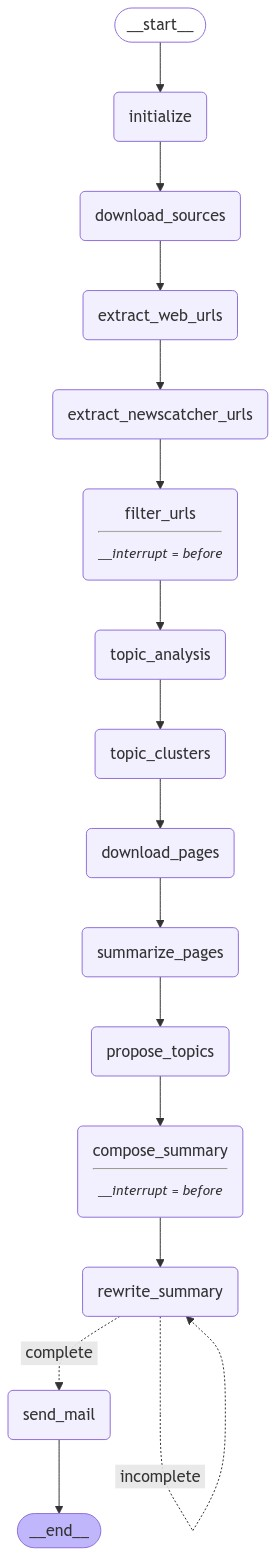

In [31]:
do_download = False
before_date = None
# before_date="2024-10-21 08:00:00"

# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


# Run each step individually

In [32]:
# download and extract, check all sources downloaded OK
state = lg_agent.initialize(state)
state = lg_agent.download_sources(state)
state = lg_agent.extract_web_urls(state)
state = lg_agent.extract_newscatcher_urls(state)
# s/b 18 check all downloaded, if any got hit by a bot block then download manually
print(len(pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]))
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


2024-10-22 08:51:09,375 - AInewsbot - INFO - Initialized 17 items in sources from sources.yaml
2024-10-22 08:51:09,376 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ -> Ars Technica.html
2024-10-22 08:51:09,376 - AInewsbot - INFO - Bloomberg Tech -> https://www.bloomberg.com/ai -> Bloomberg Technology.html
2024-10-22 08:51:09,377 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider Tech.html
2024-10-22 08:51:09,377 - AInewsbot - INFO - FT Tech -> https://www.ft.com/technology -> FT Technology.html
2024-10-22 08:51:09,378 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2024-10-22 08:51:09,379 - AInewsbot - INFO - 

2024-10-22 08:51:09,854 - AInewsbot - INFO - 19 links found
2024-10-22 08:51:09,855 - AInewsbot - INFO - Reddit -> htmldata/Reddit multiple subreddits (10_22_2024 08_45_06 AM).html
2024-10-22 08:51:09,895 - AInewsbot - INFO - parse_file - found 296 raw links
2024-10-22 08:51:09,900 - AInewsbot - INFO - parse_file - found 189 filtered links
2024-10-22 08:51:09,900 - AInewsbot - INFO - 189 links found
2024-10-22 08:51:09,900 - AInewsbot - INFO - Techmeme -> htmldata/Techmeme (10_22_2024 08_44_45 AM).html
2024-10-22 08:51:09,912 - AInewsbot - INFO - parse_file - found 274 raw links
2024-10-22 08:51:09,916 - AInewsbot - INFO - parse_file - found 108 filtered links
2024-10-22 08:51:09,916 - AInewsbot - INFO - 108 links found
2024-10-22 08:51:09,917 - AInewsbot - INFO - The Register -> htmldata/The Register (10_22_2024 08_44_48 AM).html
2024-10-22 08:51:09,937 - AInewsbot - INFO - parse_file - found 205 raw links
2024-10-22 08:51:09,941 - AInewsbot - INFO - parse_file - found 110 filtered li

18


,id
src,
Ars Technica,27
Bloomberg Tech,11
Business Insider,49
FT Tech,62
Feedly AI,74
Google News,67
Hacker News,26
Hacker News 2,23
HackerNoon,99


In [33]:
state = lg_agent.filter_urls(state)
pd.DataFrame(state["AIdf"]).groupby("src").count()[['id']]


2024-10-22 08:51:23,687 - AInewsbot - INFO - Querying SQLite with where_clause: 
2024-10-22 08:51:24,542 - AInewsbot - INFO - URLs in orig_df: 1018
2024-10-22 08:51:24,545 - AInewsbot - INFO - Existing URLs in DB: 167009
2024-10-22 08:51:24,577 - AInewsbot - INFO - New URLs in df filtered by URL: 299
2024-10-22 08:51:24,671 - AInewsbot - INFO - Existing src+title: 19
2024-10-22 08:51:24,672 - AInewsbot - INFO - New URLs in df filtered by src+title: 280
2024-10-22 08:51:24,683 - AInewsbot - INFO - Found 273 unique new headlines
2024-10-22 08:51:24,875 - AInewsbot - INFO - Applying prompt to 6 pages using gpt-4o-mini
2024-10-22 08:51:24,875 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:51:24,876 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:51:24,877 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:51:24,877 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:51:24,877 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:51:24,877 - AInewsbot - INFO - sent 23 items 
2024-10-22 08:51:

,id
src,
Business Insider,3
FT Tech,1
Feedly AI,55
Google News,19
Hacker News,2
Hacker News 2,1
HackerNoon,6
Newscatcher,18
Reddit,1


In [34]:
for row in pd.DataFrame(state["AIdf"]).itertuples():
    display(Markdown(f"[{row.id}. {row.title} - {row.src}]({row.url})"))


[0. "DonBot" brings AI to this year's political cycle in Virginia - Feedly AI](https://www.wvtf.org/news/2024-10-22/donbot-brings-ai-to-this-years-political-cycle-in-virginia)

[1. 'Blade Runner 2049' producer sues Tesla, Warner Bros over AI images - Newscatcher](https://finance.yahoo.com/news/blade-runner-2049-producer-sues-215107718.html)

[2. 1 Top Artificial Intelligence (AI) Stock That's a No-Brainer Buy - Newscatcher](https://finance.yahoo.com/news/1-top-artificial-intelligence-ai-084500597.html)

[3. 1minAI combines my favorite AI platforms into oneand its on sale - Feedly AI](https://www.popsci.com/sponsored-content/1minai-one-time-payment-lifetime-access-deal/)

[4. 2 Stock-Split Artificial Intelligence (AI) Stocks Up 650% and 1,030% in 2 Years to Buy Now, According to Wall Street - Newscatcher](https://finance.yahoo.com/news/2-stock-split-artificial-intelligence-080400255.html)

[5. 5 ChatGPT Prompts To Get Hours Of Work Done In Minutes - Feedly AI](https://www.forbes.com/sites/aytekintank/2024/10/22/5-chatgpt-prompts-to-get-hours-of-work-done-in-minutes/)

[6. A Brave New World: The Promise And Peril Of Generative AI In Business - Feedly AI](https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/22/a-brave-new-world-the-promise-and-peril-of-generative-ai-in-business/)

[7. AI's Power Drain Demands a Novel Solution: Us - Feedly AI](https://www.bloomberg.com/opinion/articles/2024-10-22/ai-s-power-drain-demands-smart-demand-management)

[8. AI, data centers, direct air capture, and renewables - Feedly AI](https://cleantechnica.com/2024/10/22/ai-data-centers-direct-air-capture-and-renewables/)

[9. AI-Driven Solutions for Modern Agritech: Interview with SOTY 2024 Nominee, Cropler - HackerNoon](https://hackernoon.com/ai-driven-solutions-for-modern-agritech-interview-with-soty-2024-nominee-cropler)

[10. AI-powered productivity tools that can make life harder - FT Tech](https://www.ft.com/content/10489c19-aecc-43e4-947f-bfde497de7b9)

[11. AI can be a powerful force in retail. Here's how - Feedly AI](https://qz.com/retail-artificial-intelligence-ai-sales-merchandise-1851676197)

[12. AI can make a 'digital twin' of you. Here's how it's shaking up retail - Feedly AI](https://qz.com/ai-digital-twin-findmine-retail-1851677471)

[13. AI employees? Microsoft launches autonomous agents to onboard workers or manage help desk - Feedly AI](https://www.euronews.com/next/2024/10/22/ai-employees-microsoft-launches-autonomous-agents-to-onboard-workers-or-manage-help-desk)

[14. AI investment in China faces looming US restrictions - Newscatcher](https://www.msn.com/en-us/money/markets/ai-investment-in-china-faces-looming-us-restrictions/ar-AA1sGszw)

[15. AI is set to transform science  but will we understand the results? - Feedly AI](https://www.rawstory.com/ai-is-set-to-transform-science-but-will-we-understand-the-results/)

[16. AI marketing is a con - especially when it comes to CPUs - Google News](https://news.google.com/read/CBMitAFBVV95cUxNU1NnSVd4YjVCQW5Wa0hzU3BCcnRWUlpUb18wVmViNmVSTG5wTkxXOXpUMXVnXzhkaEpUb1g4WGFuS1NYMlFlWjM0UnBrT21uRkNnWWZtRkZ6R2VIMHE2RjNvSjYwUmo5Z2x5a0dPZDZGY1FtWHA4allVdnIzbjlEU1QzY0MxcmRUZEVaa3VZcG93eGlXN0hPV3NXN2dLTEZHUkMtdVpETkRGaVh5Q19VVDJ1Szg)

[17. AI to help doctors spot broken bones on X-rays - Newscatcher](https://www.yahoo.com/news/ai-help-doctors-spot-broken-015433327.html)

[18. AI tools are being increasingly abused to launch cyberattacks - Feedly AI](https://www.techradar.com/pro/security/ai-tools-are-being-increasingly-abused-to-launch-cyberattacks)

[19. AI video startup Genmo launches Mochi 1, an open source rival to Runway, Kling, and others - Feedly AI](https://venturebeat.com/ai/video-ai-startup-genmo-launches-mochi-1-an-open-source-model-to-rival-runway-kling-and-others/)

[20. A Lawsuit Against Perplexity Calls Out Fake News Hallucinations - Feedly AI](https://www.wired.com/story/dow-jones-new-york-post-sue-perplexity/)

[21. Adobe's GenStudio is the AI app I never knew I needed - Feedly AI](https://www.creativebloq.com/ai/adobes-genstudio-is-the-ai-app-i-never-knew-i-needed)

[22. A look at some use cases of Anthropic's Claude Artifacts, which lets users create interactive single-page apps via prompts - Techmeme](https://simonwillison.net/2024/Oct/21/claude-artifacts/)

[23. Anthropic is testing AIs capacity for sabotage - Feedly AI](https://mashable.com/article/anthropic-ai-use-sabotage)

[24. Apple CEO Tim Cook Says Apple Intelligence Will Make Products 'Profoundly Different': New AI Technology Will Get Consumers 'On A Different Technology Curve' - Newscatcher](https://www.benzinga.com/success-stories/24/10/41441641/apple-ceo-tim-cook-says-apple-intelligence-will-make-products-profoundly-different-new-ai-technol)

[25. Apple iPhone 16 Pro Max review: A pro-grade phone set to get better with AI - Google News](https://news.google.com/read/CBMi5wFBVV95cUxNcEpseS1RQXhPY3c5T3M4bzNqaGlwZkdLaUpfZzVPUkZUamxmbWJTbVBtX3J6OFBtX0VCYTBlcjJUSktNa3RQNk91TjhBT2pEQmhIb1A2R0lBZzhBNmNWYlYtU3dHbU1yYjZPbEVxLVc3SnZ2bk9yXzFlczRuX243OG11UnB1YS1LSk9oZDhPcTdXaTlJQ2lweXY2Q0g4TmVNNlV2V1l5TVB5bk93Ry0yRzR5ZzhsNDFRbWxwMkw4OEEyNllpZnNtRmc0anZ0X0NZVEZ4V0szTVBydjM3OEwxWngyVUdVUHc)

[26. Artificial intelligencefor detection of retinal toxicity in chloroquine and hydroxychloroquine therapy using multifocal electroretinogram waveforms - Feedly AI](https://www.nature.com/articles/s41598-024-76943-4)

[27. Baidu CEO warns AI is just an inevitable bubble  99% of AI companies are at risk of failing when the bubble bursts - Newscatcher](https://finance.yahoo.com/news/baidu-ceo-warns-ai-just-162313926.html)

[28. Blade Runner 2049 producers: Elon Musk ripped us off at robotaxi launch - Google News](https://news.google.com/read/CBMirAFBVV95cUxOUTBOREM0SGRKOEkxTWxNcDRrZHM1MXBDX01mSXk3S2tsMkRLejdfQXQ4cWthZmNkVlZCb0tLRVZXZEdqTDFUc2ZXalNxN2gweEZRTjVqN0ZQUG9jMVVpV1JpYTZ4Y3o2ZENISGRZTlhaejRpR3ZRSHIzYzlSOFFMc3NfVTl3Z29FWWZuTWhieDdvNFJVUHM5SUVYQUVLcDZYQkpXMEN3cjc3ekVB)

[29. Blade Runner 2049 producer sues Elon Musk for image used in Cybercab launch - Feedly AI](https://www.engadget.com/transportation/blade-runner-2049-producer-sues-elon-musk-for-image-used-in-cybercab-launch-120048345.html)

[30. Bloomberg Intelligences Tamlin Bason on AI Regulation - Feedly AI](https://www.bloomberg.com/news/videos/2024-10-22/bloomberg-intelligence-s-tamlin-bason-on-ai-regulation-video)

[31. Can The Government, The Technology Platforms, or Anyone Else Control the Spread of Deepfakes? - HackerNoon](https://hackernoon.com/can-the-government-the-technology-platforms-or-anyone-else-control-the-spread-of-deepfakes)

[32. Chainlink Partners With Major Financial Players to Improve Corporate Actions Data Reporting Using AI and Blockchain - Google News](https://news.google.com/read/CBMi8wFBVV95cUxQQ0RQemhlaVh1NkdMOUV0MDVFQmV5b1p3Y1EyTURlNnRvQzM2RGdRM0VaZXp0dl9uTE5oYlVMSTR3NWhnMWM2MlFoVEN2MmEycTdpQTh4ZW1ZZ3hpSXZxT3EzQWZUYkZOanRtYjFNR3lzR3RjNVpxVWQ1RDdIdzJwQkp3RENkRE9yanVuSUpuUF9RTGNxQmhhdmI2VnQ2TGRNMXowdV9vVjRPR0Roc1FTYnIwR1QzV25ZLXg3b2M3OTg2eXVvRVFZN2JoelhkLUdmZ192TjBrYjVjQ1RLUWQ3blhkVFM3T1UxMEoybDdva1BzMU3SAfgBQVVfeXFMUHBVR0dyUkFYemZjSGdSRm5xWnFsTkxTTVBMZVd3bGx4Q0FKZHM3dTdMUkZvMHVwOVhFTVo4dmRIdkE4c1dKTjB3MDNNc0VlNzRVdWpnRTFYeXJZRlZQQXNTX21QTUZqanhKN1RheFZqM18tZ0RweHZzSFlYSFMzNm1iZmtDU1l4NVljdk5nZWtJZENmNThmR3h1elJPX3VvdE45OHRndXVHTEVSUkl4U1pqX09qWG5SX0NDNVFEYnlvMWFONlp2QmF6d2NvZElGWGxxcWNXVW81S0lYNlc3SURoRm0tYlQtWjM5N29kaEtURkU0Z1ZJcHg)

[33. Chainlink Partners with Financial Giants to Create AI Blockchain Record of Corporate Data - Google News](https://news.google.com/read/CBMibkFVX3lxTE1vMzJNaE1lS1FwNk5vNGhwampDOUhTakJoLTRwQ201alJ1T3k1OU43YXJKZHIzWWY3VkRpVHZXTGUwQ0dJeFVQMVpsNE5TdFh6NGFuM0gwTVB0Z2EzWnVDMVo5RTR1OG9nWU9GRElB)

[34. Chainlink and 8 Major Market Participants Launch AI-Powered Corporate Actions Initiative To Address Unstructured Data Challenge for the Financial Industry - Google News](https://news.google.com/read/CBMitAJBVV95cUxQUG5UWWt3d1NWbnRBMU54RGRaaG5EcV9ISkVRa3pzcUNwRW1oV0hWT2had2UxdkpOSmNMWXpFNU1TbWV2R3BoMmFFcU1uU21GYU53UVlZM2lORGdQNUxnTG80SEhhM250QTB4b3hpWGc5RGd5a25RdXBLaGgyelBQcnV2U2ZfTTB0eUJyTEpqa2kwNFJpTEU3V0ZNMjB6dTZIUUIwdGNGdXctejB5Mjk3VmxwcS1KSGlhVzgzY2VFdmZXXzVGSG5yWWlFLTdpc2lVNEh3NTZEV1BEWEM3WEs5SUhlV21pdVNRZ28tclc0S1JXSm95cmUyc05fX2c4eWl6aWhiaWVCMWhrWnZVU0VCU3lDbnI5Y0pTMks2YnlUOFZ0OS1iLTdZaG95OHo0TTNRQ1Q0Uw)

[35. Chainlink using AI, oracles to bring market-moving corporate data onchain - Google News](https://news.google.com/read/CBMingFBVV95cUxNRF9GcjBuWVV2ZTJydEEza2hfUy1rd09TQkhSc3RaLVV3bmFLS2piZVB4eGpqV092eDJTTThLeDMzNVU4cHY5NWJPRjVvN1dPVXg4cEItN2tpbEZnRGZLQzd2QzRIVzYyWVZzZzg3em9ldnRzU3NjMzNFS3RWUzNTRTZzc0tiZjNkcDRsYVFZMEc3WEYtdG01Wi02b3hIUQ)

[36. Comprehensive Overview of GNN Experiments: Hardware, Hyperparameters, and Findings - HackerNoon](https://hackernoon.com/comprehensive-overview-of-gnn-experiments-hardware-hyperparameters-and-findings)

[37. Create Stunning AI Art for Free: 7 AI Image Generators Tested - Feedly AI](https://www.geeky-gadgets.com/create-stunning-ai-art-for-free-7-ai-image-generators-tested/)

[38. CrewAI now lets you build fleets of enterprise AI agents - Feedly AI](https://venturebeat.com/ai/crewai-launches-its-first-multi-agent-builder-speeding-the-way-to-agentic-ai/)

[39. Deep Learning vs Data Science: Who Will Win? - Feedly AI](https://towardsdatascience.com/deep-learning-vs-data-science-who-will-win-103bfbad0a65)

[40. Desktop AI assistant app Highlight spins out of Medal with $10M in funding - Feedly AI](https://techcrunch.com/2024/10/22/desktop-ai-assistant-app-highlight-spins-out-of-medal-with-10m-in-funding/)

[41. Document: Chinese startup Horizon Robotics, which makes autonomous driving software and hardware, raised $696M in a Hong Kong IPO, before its October 24 listing - Techmeme](https://www.bloomberg.com/news/articles/2024-10-22/horizon-robotics-raises-696-million-in-hong-kong-ipo)

[42. Download: iOS 18.1 Release Candidate Update With Apple Intelligence Now Available, Final Update Coming Next Week - Google News](https://news.google.com/read/CBMicEFVX3lxTE43cUxqTHZHZmFiMzZOMlJ2c29RaHAtYTY1WVNXTWVmbVJJaDR4V0x3dGY4MFRwWEN2OElaU2ZlUnlrRmpDVlFLR18wWmM3VEswY2J4WTdzRll0eHFCSFNZeUdzOHVnQVJPRjFmVTlmMHbSAXZBVV95cUxPdnRxcVlUMC1HMEhkeWdmYkNFd19GU1I5UWRDVVZ1MjI3STc3cXlUazlBMFBQRnExMUp4Y0JBVFBCek95azVHNWUyS04ybGc0YXp4Q2NQcHd2azNaZHhXN1RLUUxLMkJtRndZeU1EYTlkVDB4eTVR)

[43. E& International and Ericsson Sign MoU to Develop AI-Powered Autonomous Networks - Newscatcher](https://telecomtalk.info/e-ericsson-develop-ai-powered-autonomous-networks/983579)

[44. Elon Musk's 'We, Robot' event is getting heat from another big Hollywood player - Business Insider](https://www.businessinsider.com/elon-musk-we-robot-event-getting-heat-big-hollywood-player-2024-10)

[45. Elon Musk's robotaxi ambitions meet ongoing scrutiny over Tesla's self-driving system - Feedly AI](https://www.businessinsider.com/elon-musk-tesla-robotaxi-empire-scrutiny-fsd-full-self-driving-2024-10)

[46. Elon Musk sued by "Blade Runner 2049" producers over Robotaxi imagery - Google News](https://news.google.com/read/CBMijgFBVV95cUxNckRkcWZJNE5MdkNlc2JWa1VTTlViUUptTG5KRE5VU0FjMnFhR2hwNTJUdC0xRWN1RjVWZWpXQTZPZmItYXZ0ZmUxWjRVV3hJRTZ4MGJVQVlGcW42X2oxWno4MFlkVnMzcXVPYlJGWHBzdTI5NW5PcmV4X1hkRWN1UWwzRm0yektHMzEySVF3)

[47. Elon Musk sued for using AI-generated Blade Runner imagery at robotaxi event - The Verge](https://www.theverge.com/2024/10/21/24276092/alcon-entertainment-blade-runner-2049-tesla-musk-warner-bros-discovery-copyright)

[48. Elon Musk sued for using Blade Runner imagery in Tesla event - Newscatcher](https://www.scmp.com/tech/big-tech/article/3283313/elon-musk-sued-using-blade-runner-imagery-tesla-robotaxi-event)

[49. Ethical hackers are flocking to AI tools, but the technology may be causing more problems than it solves - Feedly AI](https://www.itpro.com/security/ethical-hackers-are-flocking-to-ai-tools-but-the-technology-may-be-causing-more-problems-than-it-solves)

[50. Extending GNN Learning: 11 Additional Framework Applications - HackerNoon](https://hackernoon.com/extending-gnn-learning-11-additional-framework-applications)

[51. FTC Rule To Protect Consumers From Fake Reviews, AI-Generated Testimonials Comes Into Effect: What You Need To Know - Newscatcher](https://www.benzinga.com/news/24/10/41443825/ftc-rule-to-protect-consumers-from-fake-reviews-ai-generated-testimonials-comes-into-effect-what-you)

[52. Gemini's vs. ChatGPT vs. Meta AI  here's the one that generates the best images of a 3-course meal - Feedly AI](https://www.tomsguide.com/ai/geminis-vs-chatgpt-vs-meta-ai-heres-the-one-that-generates-the-best-images-of-a-3-course-meal)

[53. Google DeepMind's Bold Plan to Achieve AGI in 10 Years - Feedly AI](https://www.geeky-gadgets.com/google-deepmind-agi-roadmap/)

[54. Hackers Have Uploaded Thousands Of Malicious Models To AIs Biggest Online Repository - Feedly AI](https://www.forbes.com/sites/iainmartin/2024/10/22/hackers-have-uploaded-thousands-of-malicious-models-to-ais-biggest-online-repository/)

[55. Honeywell, Google Join Forces to Build AI-Driven Industrial Operations - Google News](https://news.google.com/read/CBMiwgFBVV95cUxQOHRCMnpVR2hHdmNYOHVscWt1czR5dVVSYjNlVjZMLXFTYWNTN09SVzFRNk45bmx3U2RoaG5wLWV3RW91SUJYYlZjc29DZ3RaNThaU1lYdzlzTl9SM1BYOGxHeGNQdE9Uei1FbnNEeEVldG5uT1Z3Z2VhRTl2SVYzbEtkVk1QTWx0TWVBSW9HRi13RkpUcUdZNW9nNEttMDdPbFZWUWJhaS1TSkRmOHlfZGEzV25qdFFMcnc2X2toTEpXdw)

[56. Honeywell Partners with Google to Integrate Data with Generative AI - Newscatcher](https://www.gadgets360.com/ai/news/honeywell-partner-google-integrate-data-generative-ai-6845515)

[57. Honeywell and Google Cloud to accelerate AI agents for industrial sector - Google News](https://news.google.com/read/CBMiigFBVV95cUxOeVZROVVEd3A2a1dDNUVqbV84WVVsZ2VQaU8yZ0lPeUwtVG1SMXdzX3YzaTVyR1BGYm5ELWtCdGtFUXhxLW9YanZUWExEeHdVQ28xd0F2aEhkOVdYaVVkNm55ZzE0WkNQV2ZSMjM5dW14b2ZlRnRzWXdhSU1IOUJERHY1eUtKOGxOdFE)

[58. Honor Magic 7 Series Will Get Snapdragon 8 Elite + Autopilot AI - Talk Android - Feedly AI](https://www.talkandroid.com/492426-honor-magic-7-snapdragon/)

[59. Horry County Schools developing AI policy for student, teacher use - Newscatcher](https://www.yahoo.com/news/horry-county-schools-developing-ai-001405870.html)

[60. How I Used AI to Save for a Vacation - Feedly AI](https://www.cnet.com/tech/services-and-software/how-i-used-ai-to-save-for-a-vacation/#ftag=CAD5457c2c)

[61. How Students Can Use AI to Manage Their Time - Feedly AI](https://www.cnet.com/tech/services-and-software/how-students-can-use-ai-to-manage-their-time/)

[62. How on-device AI could shake up the phone app business - Feedly AI](https://www.axios.com/2024/10/22/ai-on-device-phone-apps-qualcomm)

[63. How to Integrate a Custom GPT into WhatsApp for Business Success - Feedly AI](https://www.geeky-gadgets.com/whatsapp-custom-gpt-2024/)

[64. I'm the CEO of a recruitment company. Here's how we can tell someone used AI on a job application. - Feedly AI](https://www.businessinsider.com/how-employers-know-ai-used-job-application-resume-2024-10)

[65. I've been boosting my ego with a sycophant AI and it can't be healthy - Feedly AI](https://www.newscientist.com/article/2452746-ive-been-boosting-my-ego-with-a-sycophant-ai-and-it-cant-be-healthy/)

[66. IBM Thinks Small to Win Enterprise AI - Feedly AI](https://www.fool.com/investing/2024/10/22/ibm-thinks-small-to-win-enterprise-ai/)

[67. India's Consumer Electronics and Home Appliances Market to Grow by USD 1.93 Billion (2024-2028), Driven by Government Initiatives, AI Powered Insights by Technavio - Newscatcher](https://finance.yahoo.com/news/indias-consumer-electronics-home-appliances-212000801.html)

[68. India, Nvidia, discuss jointly developed AI chipCurrent capabilities mean local manufacturing is not likely  but a chip tuned to Indian needs could workSystems8 hrs|4 - The Register](https://www.theregister.com/2024/10/22/india_nvidia_collaboration/)

[69. Intern allegedly messed with ByteDance's LLM training clusterNo losses caused  except the intern's job  says TikTok parentAI + ML10 hrs|13 - The Register](https://www.theregister.com/2024/10/22/bytedance_intern_messed_with_llm/)

[70. Lab-grown human brain cells drive virtual butterfly in simulationCould organoid-driven computing be the future of AI power?Science6 hrs|15 - The Register](https://www.theregister.com/2024/10/22/human_brain_tissue_butterfly_simulation/)

[71. Major publishers sue Perplexity AI for scraping without payingWe sell that to OpenAI  how dare you steal it and make stuff upAI + ML5 hrs|6 - The Register](https://www.theregister.com/2024/10/22/publishers_sue_perplexity_ai/)

[72. Makers of this AI powered bike claim you can get fit in under nine minutes a day  we put it to the test - Feedly AI](https://www.cyclingweekly.com/fitness/makers-of-this-ai-powered-bike-claim-you-can-get-fit-in-under-twelve-minutes-a-day-we-put-the-science-to-the-test)

[73. Marc Benioff says Microsoft rebranding Copilot as AI 'agents' shows they're in 'panic mode' - Business Insider](https://www.businessinsider.com/salesforce-ceo-marc-benioff-criticized-microsoft-copilot-ai-agents-2024-10)

[74. Microsoft Banks on Copilot Agents in 'AI-Powered World' - Newscatcher](https://finance.yahoo.com/news/microsoft-banks-copilot-agents-ai-192147376.html)

[75. Microsofts new AI agents set to shake up enterprise software, sparking new battle with Salesforce - VentureBeat](https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/)

[76. Mumbai-based Neysa, a provider of AI infrastructure to enterprise customers, raised a $30M Series A co-led by NTTVC, Z47, and Nexus Venture Partners - Techmeme](https://techcrunch.com/2024/10/21/indias-neysa-bags-30m-to-compete-with-global-ai-hyperscalers/)

[77. Musks xAI unveils a new API service for Grok models - Feedly AI](https://www.infoworld.com/article/3577061/musks-xai-unveils-a-new-api-service-for-grok-models.html)

[78. NVIDIA Brings Generative AI Tools, Simulation and Perception Workflows to ROS Developer Ecosystem - Feedly AI](https://blogs.nvidia.com/blog/generative-ai-simulation-roscon/)

[79. NetVRk launches its AI-powered metaverse with Unreal Engine 5 graphics - Feedly AI](https://venturebeat.com/metaverse/netvrk-launches-its-ai-powered-metaverse-with-unreal-engine-5-graphics/)

[80. Nuclear-Powered AI: Big Techs Bold Solution or a Pipedream? - WSJ Tech](https://www.wsj.com/business/energy-oil/nuclear-power-artificial-intelligence-tech-bb673012)

[81. Optimizing GNNs: A Sampling-Based Solution to the k-Center Problem - HackerNoon](https://hackernoon.com/optimizing-gnns-a-sampling-based-solution-to-the-k-center-problem)

[82. Qualcomm's Snapdragon 8 Elite Chip Aims to Level Up AI on Android Phones - Google News](https://news.google.com/read/CBMiqAFBVV95cUxOM2w1XzVOMUpzQ1d4Tmh0QmFZNTktNVo2SXRGQk1BTjNEZFZnVTlNUWdNWEpGa0N2TEZrSFlEVGI1UlBXV3lha3ZmaEdWQlk1T2Nad1QtaV8wbVRnSkNteUNwZkhHRndqVDF4cDNNS3l2V0xCNXNsWkRTa1MzUzlHMk0wa1lqUGtiZVBhLVctNTNvdi1DLWVYejFHQy1tUzRHbC1JM0NZZ1Y)

[83. Reddit CEO says the platform is in an 'arms race' for AI training - Business Insider](https://www.businessinsider.com/reddit-ceo-platform-arms-race-ai-training-steve-huffman-2024-10)

[84. Rupert Murdochs Dow Jones and New York Post sue AI firm for illegal copying - Google News](https://news.google.com/read/CBMiogFBVV95cUxNY0FBam1WZWtCTEszUFdOVnlQVFprZ3ZDUGlZX2ZlTThKQ0JReVJBZzdCM2NxWnhsVENYZUNyYTUtRTR0S2Z2UGxKQVd1V1NfVFdNaEg3RElmSVNHQ2RWYi0wWlNid3cyODVHVlBkNTNDU2g4STRYTFhtREVHdzJMYWZ3OE9UdDhsc1pJZk9HSldyUHZiUEIyaEJiN2FjZHN2aEHSAaIBQVVfeXFMTmdzYVZCbTZERW9aallRb0NXanFVclVKSERlakcybUEwNjd5Rkc5TVpRTTB6ZEZKRnhESlBqSE5HSUpGZGJXQnFXZU1XRjgyV3ozb25NSTAxS3R1a0U2bXd0SDJtUEhNTmljWU56Q1FrbzRHQ0N6Z3ludnBOcjN3SWRSaHU3U2NhT0t3c09NVWRualVoNVV5YUVoS3NHY2NFM3Vn)

[85. SAP Is Joining The AI Party As A 'Foundational Player' Alongside Leaders Nvidia And Microsoft, Says Wedbush's Dan Ives - Newscatcher](https://www.benzinga.com/markets/equities/24/10/41442947/sap-is-joining-the-ai-party-as-a-foundational-player-alongside-leaders-nvidia-and-microsoft-says)

[86. Show HN: Data Formulator  AI-powered data visualization from Microsoft Research - Hacker News](https://github.com/microsoft/data-formulator)

[87. Slack researcher shares five types of AI personalities in the workplace - Newscatcher](https://www.fastcompany.com/91213583/ai-workplace-replace-people-slack-researcher)

[88. Snapdragon 8 Elite Reference Design With 24GB 4,800MHz LPDDR5X RAM Sets New Performance Ceiling; Beats All Flagship Android SoCs By Up To 47 Percent In Geekbench 6 - Google News](https://news.google.com/read/CBMitAFBVV95cUxNRDRrU21YSHYzWXRZNVZBRXVCRWhrTnNBS1dBdFU3Z1V2ellfbWRtZmRHcVRSZUN4NWZWdkREa1lsWWhtazBUbFpxRnV2YUFjNjBfYUFaWktDczNWM3hwT3BUS3ZocGVQRzk4M0hOWEhabkM1STg2SVd6QU1UQ2k3a29fVVN1UnFva1l4YXk4ZWdLcF9GN0FWU0djbUtiRFQ4aHVrbXEzTVI3c2FtMXdyRXhWTWzSAboBQVVfeXFMTU4ya3NMRHhXZGRob0x4QWF2STRDSzBLWG96NXM3dzdpRDZ5YkZqT29OZUFoc3EyVGVaeHJMVVNKbUg5Zk1HSFQtU0NYTS1ONTZlTC11YTVvN0VXcEZYR0dDOGpydDdIMnlMRW9aaHlWNlpJX1FSYmkzdHg0c3Q3UUpVamJMUTY4YnY2MXZBazVhWWM4c2cxbThnT3JJUF9SRTduaTJ1WkZlTVRnSlR4ajlOVEN1ZVRFenBB)

[89. Task force talks revisions to Colorados controversialartificial intelligencelaw - Feedly AI](https://coloradosun.com/2024/10/22/task-force-talks-revisions-to-colorados-controversial-artificial-intelligence-law/)

[90. Tested: The Best AI Image Generators for 2024 - Feedly AI](https://www.pcmag.com/picks/the-best-ai-image-generators)

[91. The Download: beyond freezing food, and AI mediation - Feedly AI](https://www.technologyreview.com/2024/10/22/1106045/the-download-beyond-freezing-food-and-ai-mediation/)

[92. The Second Wave Of AI In Manufacturing: Cloud-Based AI Training - Feedly AI](https://www.forbes.com/councils/forbestechcouncil/2024/10/22/the-second-wave-of-ai-in-manufacturing-cloud-based-ai-training/)

[93. The Transformative Impact of Generative AI on IT Services, BPO, Software, and Healthcare - Feedly AI](https://analyticsindiamag.com/ai-highlights/the-transformative-impact-of-generative-ai-on-it-services-bpo-software-and-healthcare/)

[94. The United States Owes Its Edge in AI to a London Landmark - Feedly AI](https://foreignpolicy.com/2024/10/22/ai-nobel-prize-demis-hassabis-queen-square-deepmind-innovation/)

[95. There's no single route to AI adoption, and Anthropic is charting all available paths - Feedly AI](https://www.itpro.com/technology/artificial-intelligence/theres-no-single-route-to-ai-adoption-and-anthropic-is-charting-all-available-paths)

[96. The truth about wealth management AI? It's all about the data - Feedly AI](https://www.financial-planning.com/opinion/the-foundational-truth-about-ai-in-wealth-management-is-that-its-all-about-the-data)

[97. TikTok parent company dismisses intern who 'maliciously interfered' with its AI technology - Newscatcher](https://www.msn.com/en-us/news/technology/tiktok-parent-company-dismisses-intern-who-maliciously-interfered-with-its-ai-technology/ar-AA1sFxuU)

[98. Today's AI ecosystem is unsustainable for most everyone but Nvidia, warns top scholar - Feedly AI](https://www.zdnet.com/article/todays-ai-ecosystem-is-unsustainable-for-most-everyone-but-nvidia-warns-top-scholar/#ftag=RSSbaffb68)

[99. Transformers Utilization in Chart Understanding: A Review of Advances and Future - Hacker News 2](https://arxiv.org/abs/2410.13883)

[100. U.S. proposals to curb AI, semiconductor investment into China under final review - Google News](https://news.google.com/read/CBMiqgFBVV95cUxNS3NxbVo0UnoyTl9qRjd2WE9wckNTeDgyaVdzNUtkMkRzc1gyNzJvTHNqaHJZLWFWZHdfWlg4R2dNdm5oY3N5YkVtb3lHTWNTTU5SQmhPZ2hDTVJOTU1CVlRBb3JuRkVUUlp3cTljSUx6RGg2SFFTZXRjWGJWTWRuWG55eXJmREZuWWFVZUhPYWlLVE13ZW44bThKRzRlRV80dENSUmVIMFZKZ9IBrwFBVV95cUxQUVNqLVZHZG9LZDNDMkJmNHRjaVlCTFh3a1RWNHE1VzlHTERWNzN0eEdXVW1Ld1dVWUtaS192cWpTdE1PSmEzNFYxSk5semRtZDBVRnZXLW1lbENLQjZHQ2lsZG1ZUkxMd1kwbXBxTkRJM3dfMXVJQ1JtZzVmc2d5RG5pUWI4NW9hOHd1OG1rX00tRGlybGc5Y1Q5TkdBX1dFZnZvOUNpenFIMUR2N2hF)

[101. US to curb AI investment in China soon - Google News](https://news.google.com/read/CBMipgFBVV95cUxNamF5dkNhSmxQS2daOGQtUUhfWlprSVlGUmhBZVFwLXBJWU5XZHg0aGxKZEd6VFhQeUwtSVAwTUlGaVVJSlpDWWl0cXN4b2pSMEkwMnU5Y0ZVZ2NfY3FZOUt0ZmdseFYtZnV6ZjdYTkw3THJyYnFXcF94b1NrUzl2bGpsM0pGTmNwOE9fWDBDX2xHUncxNE1jaDBQZ3k4cGtBMTI0cVdR)

[102. US to impose AI investment restrictions in China - Google News](https://news.google.com/read/CBMijwFBVV95cUxPM2xvc0RaajdOeWlFSXFSOHh5SHRibjRzOVR0aER0WlVzZDJmaTlmdnVZcEREVDBtNWJZVjdacWJmQzVlZmRjbk9hSGxhYkVrb1JSN3hFUmhoSUgxOUJnaFpCekFMMjRCMkRQN1RjdTk2TDQ0Y0VRODc2V3lrNlJYRGVBNXJKREtzVmtCMHluRQ)

[103. Unfair Generalization in Graph Neural Networks (GNNs) - HackerNoon](https://hackernoon.com/unfair-generalization-in-graph-neural-networks-gnns)

[104. Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - Google News](https://news.google.com/read/CBMiiwFBVV95cUxNMGFfY1VVVFEzckprclJZMDVMckpXZXAyOFg1U0RtckZ5cWNZY1NlXzBUT2pXSHRTbWtjQm9fdnc1OHhiMlVRS05xeTczQUtKQ2NiWWhkb2VfaEZmb2pLSTF6ZHhLeHNLME1iUnNZMmtvSllEVWY4WTZveng3RVc4a2l0cHhkUk1FV1hN)

[105. Wall Street Journal, New York Post Sue AI Startup Perplexity, Alleging Massive Freeriding - Google News](https://news.google.com/read/CBMimwFBVV95cUxPR3E5akJ1enFkajJVNlNjY18wdnlUZWhtRENGR0lNN3BieGdESzc1ckFWYmlWNGZQb2ItZjVrV1BJbXhvWjBWMW9iYmlTUG9Id2MtRTlOUWFIYkNoLS1OTkxNajhQbWx6emlkMlZyTEhWMTJnRnN4Wl9TNjg2ZmFYRzFHSUtkMkM4cWlCZEUwWlhCeG9vYUJsRzZXYw)

[106. Watch out, OpenAI  Haiper 2.0 AI video generation model just launched and it looks stunning - Feedly AI](https://www.tomsguide.com/ai/watch-out-openai-haiper-2-0-ai-video-generation-model-just-launched-and-it-looks-stunning)

[107. What Does the World's First AI Treaty Mean for the Future of AI? - Feedly AI](https://hackernoon.com/what-does-the-worlds-first-ai-treaty-mean-for-the-future-of-ai)

[108. What is an AI art museum? The world will soon find out. - Feedly AI](https://me.mashable.com/digital-culture/48045/what-is-an-ai-art-museum-the-world-will-soon-find-out)

[109. When machines could see you - Hacker News](http://dnlserrano.dev//2024/10/20/when-machines-could-see-you.html)

[110. Why enterprises can no longer afford to delay GenAI initiatives - Feedly AI](https://www.techmonitor.ai/partner-content/why-enterprises-cannot-afford-to-delay-genai-initiatives)

[111. Why this AI e-degree is worth getting excited about - Feedly AI](https://www.miamiherald.com/deals-offers/discount-offers/article294111109.html)

[112. Woman's Doctor: AI technology helping diagnose breast cancer - Newscatcher](https://www.yahoo.com/news/womans-doctor-ai-technology-helping-232116868.html)

[113. Would you trust AI to mediate an argument? - Feedly AI](https://www.technologyreview.com/2024/10/22/1106041/would-you-trust-ai-to-mediate-an-argument/)

[114. X changed its terms of service to let its AI train on everyones posts. Now users are up in arms - Reddit](https://www.reddit.com/r/technews/comments/1g9776u/x_changed_its_terms_of_service_to_let_its_ai/)

[115. Zoom partners with Suki to offer AI-powered medical note-taking - Feedly AI](https://techcrunch.com/2024/10/22/zoom-partners-with-suki-to-offer-ai-powered-medical-note-taking/)

In [35]:
# do topic analysis and summarization, identify good topics
state = lg_agent.topic_analysis(state)
state = lg_agent.topic_clusters(state)
state = lg_agent.download_pages(state)
state = lg_agent.summarize_pages(state)
state = lg_agent.propose_topics(state)


2024-10-22 08:51:32,336 - AInewsbot - INFO - start free-form topic extraction
2024-10-22 08:51:32,337 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:51:32,339 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:51:32,340 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:51:32,341 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:51:35,354 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:51:40,071 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:51:41,053 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:51:41,055 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:51:41,058 - AInewsbot - INFO - 116 free-form topics extracted
2024-10-22 08:51:41,060 - AInewsbot - INFO - ['blade runner 2049', 'tesla', 'lawsuit', 'stock market', 'investment', 'wall street', 'chatgpt', 'prompts', 'generative ai', 'retail', 'impact', 'innovation', 'microsoft', 'china', 'healthcare', 'cybersecurity', 'perplexity', 'anthropic', 'testing', 'ap

2024-10-22 08:52:22,904 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:52:22,906 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:52:22,907 - AInewsbot - INFO - China, topic 12 of 100
2024-10-22 08:52:22,909 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:52:22,911 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:52:22,913 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:52:22,914 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:52:24,346 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:52:26,629 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:52:26,645 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:52:26,648 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:52:26,650 - AInewsbot - INFO - Climate, topic 13 of 100
2024-10-22 08:52:26,651 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:52:26,652 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:52:26,653 - 

2024-10-22 08:53:14,250 - AInewsbot - INFO - Economics, topic 25 of 100
2024-10-22 08:53:14,251 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:53:14,252 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:53:14,254 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:53:14,255 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:53:15,833 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:53:17,547 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:53:17,567 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:53:17,568 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:53:17,569 - AInewsbot - INFO - Education, topic 26 of 100
2024-10-22 08:53:17,570 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:53:17,571 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:53:17,573 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:53:17,573 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:53:19,191 - AInewsbot - I

2024-10-22 08:54:01,769 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:54:01,772 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:54:01,774 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:54:03,119 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:54:04,941 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:54:05,685 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:54:05,689 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:54:05,690 - AInewsbot - INFO - Governance, topic 39 of 100
2024-10-22 08:54:05,691 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:54:05,692 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:54:05,693 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:54:05,694 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:54:07,995 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:54:10,209 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:54:10,211 - AInewsbot - INFO - got dict with 50 

2024-10-22 08:54:52,265 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:54:54,362 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:54:54,385 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:54:54,388 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:54:54,390 - AInewsbot - INFO - Job Automation, topic 52 of 100
2024-10-22 08:54:54,393 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:54:54,395 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:54:54,398 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:54:54,401 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:54:55,843 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:54:57,709 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:54:57,944 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:54:57,945 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:54:57,946 - AInewsbot - INFO - Jobs & CareersLabor Market, topic 53 of 100
2024-10-22

2024-10-22 08:55:43,545 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:55:43,548 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:55:43,548 - AInewsbot - INFO - Opinion, topic 65 of 100
2024-10-22 08:55:43,549 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:55:43,551 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:55:43,552 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:55:43,554 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:55:44,967 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:55:46,908 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:55:47,050 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:55:47,053 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:55:47,054 - AInewsbot - INFO - Policy and regulation, topic 66 of 100
2024-10-22 08:55:47,055 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:55:47,056 - AInewsbot - INFO - sent 50 items 
2024-10-22

2024-10-22 08:56:34,388 - AInewsbot - INFO - Safety and Alignment, topic 78 of 100
2024-10-22 08:56:34,389 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:56:34,391 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:56:34,392 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:56:34,393 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:56:36,458 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:56:37,778 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:56:37,783 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:56:37,785 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:56:37,785 - AInewsbot - INFO - Scams, topic 79 of 100
2024-10-22 08:56:37,787 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:56:37,790 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:56:37,792 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:56:37,793 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:56:39,105 - AInews

2024-10-22 08:57:22,809 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:57:22,810 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:57:22,810 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:57:24,525 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:57:26,365 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:57:27,235 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:57:27,237 - AInewsbot - INFO - Processed 116 responses.
2024-10-22 08:57:27,238 - AInewsbot - INFO - Taiwan, topic 92 of 100
2024-10-22 08:57:27,238 - AInewsbot - INFO - Applying prompt to 3 pages using gpt-4o-mini
2024-10-22 08:57:27,240 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:57:27,241 - AInewsbot - INFO - sent 50 items 
2024-10-22 08:57:27,242 - AInewsbot - INFO - sent 16 items 
2024-10-22 08:57:28,949 - AInewsbot - INFO - got dict with 16 items 
2024-10-22 08:57:30,779 - AInewsbot - INFO - got dict with 50 items 
2024-10-22 08:57:30,816 - AInewsbot - INFO - got dict with 50 item

,id,title_topic_str
0,0,"AI, data centers, direct air capture, and renewables (Topics: Climate, Data Centers, Direct AIr Capture, Energy, Renewable Energy, Science, Sustainability)"
1,1,"AI's Power Drain Demands a Novel Solution: Us (Topics: Energy, Power Consumption, Solutions, Sustainability)"
2,2,"Nuclear-Powered AI: Big Techs Bold Solution or a Pipedream? (Topics: AI Doom, Big Tech, Climate, Energy, Gen AI, Innovation, Nuclear, Nuclear-Powered AI, Opinion, Safety And Alignment, Science, Sustainability, Technology Solutions)"


2024-10-22 08:58:08,294 - AInewsbot - INFO - {'topic_title': 'Sustainable Energy and AI Solutions'}
2024-10-22 08:58:08,295 - AInewsbot - INFO - I dub this cluster: Sustainable Energy and AI Solutions


,id,title_topic_str
3,3,"AI investment in China faces looming US restrictions (Topics: China, Economics, Finance, Governance, Investment, Policy And Regulation, Us Restrictions)"
4,4,"U.S. proposals to curb AI, semiconductor investment into China under final review (Topics: China, Economics, Gen AI, Governance, Government Proposals, Hardware, Investment, Policy And Regulation, Politics, Review, Safety And Alignment, Semiconductor Chips, Semiconductors)"
5,5,"US to curb AI investment in China soon (Topics: China, Economics, Gen AI, Governance, Government Policy, Hardware, Investment, Policy And Regulation, Politics, Safety And Alignment)"
6,6,"US to impose AI investment restrictions in China (Topics: China, Economics, Gen AI, Governance, Government Policy, Hardware, Investment Restrictions, Policy And Regulation, Politics, Safety And Alignment)"


2024-10-22 08:58:08,793 - AInewsbot - INFO - {'topic_title': 'AI Investment Restrictions in China'}
2024-10-22 08:58:08,794 - AInewsbot - INFO - I dub this cluster: AI Investment Restrictions in China


,id,title_topic_str
7,7,"AI to help doctors spot broken bones on X-rays (Topics: Computer Vision, Diagnostics, Health & Fitness, Healthcare, Safety And Alignment, Science, Testing, X-Rays)"
8,8,"Woman's Doctor: AI technology helping diagnose breast cancer (Topics: Breast Cancer, Diagnosis, Gen AI, Health & Fitness, Healthcare, Healthcare Technology, Products, Science, Testing)"
9,9,"Artificial intelligencefor detection of retinal toxicity in chloroquine and hydroxychloroquine therapy using multifocal electroretinogram waveforms (Topics: Chloroquine, Cognitive Science, Computer Vision, Electroretinogram, Health & Fitness, Healthcare, Retinal Toxicity, Safety And Alignment, Science, Testing)"


2024-10-22 08:58:09,217 - AInewsbot - INFO - {'topic_title': 'AI in Healthcare Diagnostics'}
2024-10-22 08:58:09,218 - AInewsbot - INFO - I dub this cluster: AI in Healthcare Diagnostics


,id,title_topic_str
10,10,"Wall Street Journal, New York Post Sue AI Startup Perplexity, Alleging Massive Freeriding (Topics: AI Startup, Ethics, Finance, Freeriding, Gen AI, Intellectual Property, Lawsuit, Legal Issues, New York Post, Perplexity, Wall Street Journal)"
11,11,"Major publishers sue Perplexity AI for scraping without payingWe sell that to OpenAI how dare you steal it and make stuff upAI + ML5 hrs|6 (Topics: AI Training, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Infringement, Disinformation, Ethics, Gen AI, Intellectual Property, Language Models, Lawsuit, Legal Issues, Perplexity AI, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams)"
12,12,"A Lawsuit Against Perplexity Calls Out Fake News Hallucinations (Topics: Bias And Fairness, Disinformation, Ethics, Fake News, Hallucinations, Language Models, Lawsuit, Legal Issues, Perplexity)"
13,13,"Rupert Murdochs Dow Jones and New York Post sue AI firm for illegal copying (Topics: AI Firm, Authors & Writing, Bias And Fairness, Books & Publishing, Disinformation, Dow Jones, Ethics, Gen AI, Intellectual Property, Language Models, Lawsuit, Legal Issues, New York Post, Policy And Regulation, Privacy, Privacy & Surveillance, Rupert Murdoch, Safety And Alignment, Scams)"


2024-10-22 08:58:10,034 - AInewsbot - INFO - {'topic_title': 'Lawsuits Against AI and Intellectual Property'}
2024-10-22 08:58:10,035 - AInewsbot - INFO - I dub this cluster: Lawsuits Against AI and Intellectual Property


,id,title_topic_str
14,14,"Elon Musk's robotaxi ambitions meet ongoing scrutiny over Tesla's self-driving system (Topics: AI Doom, Autonomous Vehicles, Bias And Fairness, Elon Musk, Ethics, Governance, Job Automation, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Robotaxi, Robots, Safety And Alignment, Scrutiny, Self-Driving, Tesla, Transportation)"
15,15,"Blade Runner 2049 producers: Elon Musk ripped us off at robotaxi launch (Topics: Art & Design, Autonomous Vehicles, Blade Runner 2049, Elon Musk, Entertainment, Hollywood, Intellectual Property, Lawsuit, Legal Issues, Robotaxi, Robots, Transportation, Tv & Film & Movies)"
16,16,"Elon Musk's 'We, Robot' event is getting heat from another big Hollywood player (Topics: Elon Musk, Entertainment, Event, Hollywood, Tv & Film & Movies, We, Robot)"


2024-10-22 08:58:10,796 - AInewsbot - INFO - {'topic_title': 'Elon Musk and Autonomous Vehicles'}
2024-10-22 08:58:10,798 - AInewsbot - INFO - I dub this cluster: Elon Musk and Autonomous Vehicles


,id,title_topic_str
17,17,"Elon Musk sued by ""Blade Runner 2049"" producers over Robotaxi imagery (Topics: Art & Design, Autonomous Vehicles, Blade Runner 2049, Elon Musk, Entertainment, Ethics, Gen AI, Hollywood, Intellectual Property, Lawsuit, Legal Issues, Robotaxi, Robots, Transportation, Tv & Film & Movies)"
18,18,"Blade Runner 2049 producer sues Elon Musk for image used in Cybercab launch (Topics: Art & Design, Autonomous Vehicles, Blade Runner 2049, Cybercab, Elon Musk, Entertainment, Ethics, Hollywood, Imagery, Intellectual Property, Lawsuit, Legal Issues, Robots, Transportation, Tv & Film & Movies)"
19,19,"Elon Musk sued for using Blade Runner imagery in Tesla event (Topics: Art & Design, Blade Runner, Elon Musk, Entertainment, Event, Hollywood, Imagery, Intellectual Property, Legal Issues, Tesla, Transportation, Tv & Film & Movies)"


2024-10-22 08:58:11,531 - AInewsbot - INFO - {'topic_title': 'Elon Musk and Blade Runner Lawsuit'}
2024-10-22 08:58:11,532 - AInewsbot - INFO - I dub this cluster: Elon Musk and Blade Runner Lawsuit


,id,title_topic_str
20,20,"Hackers Have Uploaded Thousands Of Malicious Models To AIs Biggest Online Repository (Topics: AI Doom, AI Repository, Cybersecurity, Gen AI, Hackers, Language Models, Malicious Models, Privacy, Privacy & Surveillance, Safety And Alignment, Scams)"
21,21,"Ethical hackers are flocking to AI tools, but the technology may be causing more problems than it solves (Topics: AI Doom, Bias And Fairness, Cybersecurity, Ethical Hackers, Ethics, Opinion, Privacy, Privacy & Surveillance, Problems, Safety And Alignment)"
22,22,"Intern allegedly messed with ByteDance's LLM training clusterNo losses caused except the intern's job says TikTok parentAI + ML10 hrs|13 (Topics: AI Technology, Bytedance, China, Gen AI, Intern, Job Automation, Jobs & Careerslabor Market, Language Models, Llm Training, Safety And Alignment, Tiktok)"


2024-10-22 08:58:11,993 - AInewsbot - INFO - {'topic_title': 'AI Security and Ethical Concerns'}
2024-10-22 08:58:11,994 - AInewsbot - INFO - I dub this cluster: AI Security and Ethical Concerns


,id,title_topic_str
23,23,"The Transformative Impact of Generative AI on IT Services, BPO, Software, and Healthcare (Topics: Bpo, Customer Service, Economics, Gen AI, Generative AI, Health & Fitness, Healthcare, Impact, It Services, Job Automation, Language Models, Retrieval Augmented Generation, Science)"
24,24,"A Brave New World: The Promise And Peril Of Generative AI In Business (Topics: AI Doom, Bias And Fairness, Business, Economics, Ethics, Gen AI, Generative AI, Job Automation, Language Models, Peril, Promise, Safety And Alignment)"
25,25,"Honeywell Partners with Google to Integrate Data with Generative AI (Topics: Data Integration, Gen AI, Generative AI, Google, Honeywell, Job Automation, Language Models, Manufacturing, Science, Supply Chain Optimization)"


2024-10-22 08:58:12,466 - AInewsbot - INFO - {'topic_title': 'Generative AI in Business and Services'}
2024-10-22 08:58:12,467 - AInewsbot - INFO - I dub this cluster: Generative AI in Business and Services
2024-10-22 08:58:12,503 - AInewsbot - INFO - Queuing URLs for scraping
2024-10-22 08:58:12,506 - AInewsbot - INFO - fetching 116 pages using 4 browsers
2024-10-22 08:58:12,508 - AInewsbot - INFO - get_driver - 43619 Initializing webdriver
2024-10-22 08:58:12,508 - AInewsbot - INFO - get_driver - 43619 Initializing webdriver
2024-10-22 08:58:12,509 - AInewsbot - INFO - get_driver - 43619 Initializing webdriver
2024-10-22 08:58:12,509 - AInewsbot - INFO - get_driver - 43619 Initializing webdriver


['Sustainable Energy and AI Solutions', 'AI Investment Restrictions in China', 'AI in Healthcare Diagnostics', 'Lawsuits Against AI and Intellectual Property', 'Elon Musk and Autonomous Vehicles', 'Elon Musk and Blade Runner Lawsuit', 'AI Security and Ethical Concerns', 'Generative AI in Business and Services']


2024-10-22 08:58:28,634 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-22 08:58:28,635 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-22 08:58:28,635 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-22 08:58:28,635 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2024-10-22 08:58:28,635 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-22 08:58:28,636 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-22 08:58:28,636 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-22 08:58:28,637 - AInewsbot - INFO - get_driver - Initialized webdriver service
2024-10-22 08:59:18,961 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-10-22 08:59:19,016 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-10-22 08:59:19,042 - AInewsbot - INFO - get_driver - Initialized webdriver
2024-10-22 08:59:19,085 - AInewsbot - INFO - Processing 

2024-10-22 08:59:42,777 - AInewsbot - INFO - get_url(US to impose AI investment restrictions in China) - Saving US_to_impose_AI_investment_restrictions_in_China.html as utf-8
2024-10-22 08:59:42,779 - AInewsbot - INFO - Processing page 10: https://news.google.com/read/CBMimwFBVV95cUxPR3E5akJ1enFkajJVNlNjY18wdnlUZWhtRENGR0lNN3BieGdESzc1ckFWYmlWNGZQb2ItZjVrV1BJbXhvWjBWMW9iYmlTUG9Id2MtRTlOUWFIYkNoLS1OTkxNajhQbWx6emlkMlZyTEhWMTJnRnN4Wl9TNjg2ZmFYRzFHSUtkMkM4cWlCZEUwWlhCeG9vYUJsRzZXYw
2024-10-22 08:59:42,781 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMimwFBVV95cUxPR3E5akJ1enFkajJVNlNjY18wdnlUZWhtRENGR0lNN3BieGdESzc1ckFWYmlWNGZQb2ItZjVrV1BJbXhvWjBWMW9iYmlTUG9Id2MtRTlOUWFIYkNoLS1OTkxNajhQbWx6emlkMlZyTEhWMTJnRnN4Wl9TNjg2ZmFYRzFHSUtkMkM4cWlCZEUwWlhCeG9vYUJsRzZXYw) - starting get_url https://news.google.com/read/CBMimwFBVV95cUxPR3E5akJ1enFkajJVNlNjY18wdnlUZWhtRENGR0lNN3BieGdESzc1ckFWYmlWNGZQb2ItZjVrV1BJbXhvWjBWMW9iYmlTUG9Id2MtRTlOUWFIYkNoLS1OTkxNajhQbWx6emlkMlZyTEhWMTJnRnN4Wl9TNj

2024-10-22 09:00:08,133 - AInewsbot - INFO - get_url(A Lawsuit Against Perplexity Calls Out Fake News Hallucinations) - Saving A_Lawsuit_Against_Perplexity_Calls_Out_Fake_News_Hallucinations.html as utf-8
2024-10-22 09:00:08,137 - AInewsbot - INFO - Processing page 19: https://www.scmp.com/tech/big-tech/article/3283313/elon-musk-sued-using-blade-runner-imagery-tesla-robotaxi-event
2024-10-22 09:00:08,139 - AInewsbot - INFO - get_url(https://www.scmp.com/tech/big-tech/article/3283313/elon-musk-sued-using-blade-runner-imagery-tesla-robotaxi-event) - starting get_url https://www.scmp.com/tech/big-tech/article/3283313/elon-musk-sued-using-blade-runner-imagery-tesla-robotaxi-event
2024-10-22 09:00:15,301 - AInewsbot - INFO - get_url(Elon Musk sued by "Blade Runner 2049" producers over Robotaxi imagery) - Saving Elon_Musk_sued_by__Blade_Runner_2049__producers_over_Robotaxi_imagery.html as utf-8
2024-10-22 09:00:15,302 - AInewsbot - INFO - Processing page 20: https://www.forbes.com/sites/iain

2024-10-22 09:00:53,246 - AInewsbot - INFO - Processing page 30: https://www.benzinga.com/success-stories/24/10/41441641/apple-ceo-tim-cook-says-apple-intelligence-will-make-products-profoundly-different-new-ai-technol
2024-10-22 09:00:53,247 - AInewsbot - INFO - get_url(https://www.benzinga.com/success-stories/24/10/41441641/apple-ceo-tim-cook-says-apple-intelligence-will-make-products-profoundly-different-new-ai-technol) - starting get_url https://www.benzinga.com/success-stories/24/10/41441641/apple-ceo-tim-cook-says-apple-intelligence-will-make-products-profoundly-different-new-ai-technol
2024-10-22 09:00:54,220 - AInewsbot - INFO - get_url(Watch out, OpenAI  Haiper 2.0 AI video generation model just launched and it looks stunning) - Saving Watch_out__OpenAI__Haiper_2_0_AI_video_generation_model_just_launched_and_it_looks_stunning.html as utf-8
2024-10-22 09:00:54,222 - AInewsbot - INFO - Processing page 31: https://www.wvtf.org/news/2024-10-22/donbot-brings-ai-to-this-years-politi

2024-10-22 09:01:47,282 - AInewsbot - INFO - Processing page 41: https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/
2024-10-22 09:01:47,283 - AInewsbot - INFO - get_url(https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/) - starting get_url https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/
2024-10-22 09:01:53,514 - AInewsbot - INFO - get_url(1 Top Artificial Intelligence (AI) Stock That's a No-Brainer Buy) - Saving 1_Top_Artificial_Intelligence__AI__Stock_That_s_a_No-Brainer_Buy.html as utf-8
2024-10-22 09:01:53,516 - AInewsbot - INFO - Processing page 42: https://www.theregister.com/2024/10/22/human_brain_tissue_butterfly_simulation/
2024-10-22 09:01:53,516 - AInewsbot - INFO - get_url(https://www.theregister.com/2024/10/22/human_brain_tissue_butterfly_simulation/) -

2024-10-22 09:02:29,844 - AInewsbot - INFO - Processing page 51: https://hackernoon.com/ai-driven-solutions-for-modern-agritech-interview-with-soty-2024-nominee-cropler
2024-10-22 09:02:29,844 - AInewsbot - INFO - get_url(https://hackernoon.com/ai-driven-solutions-for-modern-agritech-interview-with-soty-2024-nominee-cropler) - starting get_url https://hackernoon.com/ai-driven-solutions-for-modern-agritech-interview-with-soty-2024-nominee-cropler
2024-10-22 09:02:32,225 - AInewsbot - INFO - get_url(Zoom partners with Suki to offer AI-powered medical note-taking) - Saving Zoom_partners_with_Suki_to_offer_AI-powered_medical_note-taking.html as utf-8
2024-10-22 09:02:32,226 - AInewsbot - INFO - Processing page 52: https://arxiv.org/abs/2410.13883
2024-10-22 09:02:32,227 - AInewsbot - INFO - get_url(https://arxiv.org/abs/2410.13883) - starting get_url https://arxiv.org/abs/2410.13883
2024-10-22 09:02:33,422 - AInewsbot - INFO - get_url(There's no single route to AI adoption, and Anthropic i

2024-10-22 09:02:56,776 - AInewsbot - INFO - get_url(https://qz.com/retail-artificial-intelligence-ai-sales-merchandise-1851676197) - starting get_url https://qz.com/retail-artificial-intelligence-ai-sales-merchandise-1851676197
2024-10-22 09:03:03,448 - AInewsbot - INFO - get_url(When machines could see you) - Saving When_machines_could_see_you.html as utf-8
2024-10-22 09:03:03,449 - AInewsbot - INFO - Processing page 62: https://www.euronews.com/next/2024/10/22/ai-employees-microsoft-launches-autonomous-agents-to-onboard-workers-or-manage-help-desk
2024-10-22 09:03:03,449 - AInewsbot - INFO - get_url(https://www.euronews.com/next/2024/10/22/ai-employees-microsoft-launches-autonomous-agents-to-onboard-workers-or-manage-help-desk) - starting get_url https://www.euronews.com/next/2024/10/22/ai-employees-microsoft-launches-autonomous-agents-to-onboard-workers-or-manage-help-desk
2024-10-22 09:03:05,214 - AInewsbot - INFO - get_url(Today's AI ecosystem is unsustainable for most everyone b

2024-10-22 09:03:27,487 - AInewsbot - INFO - Processing page 71: https://towardsdatascience.com/deep-learning-vs-data-science-who-will-win-103bfbad0a65
2024-10-22 09:03:27,488 - AInewsbot - INFO - get_url(https://towardsdatascience.com/deep-learning-vs-data-science-who-will-win-103bfbad0a65) - starting get_url https://towardsdatascience.com/deep-learning-vs-data-science-who-will-win-103bfbad0a65
2024-10-22 09:03:30,405 - AInewsbot - INFO - get_url(Chainlink Partners With Major Financial Players to Improve Corporate Actions Data Reporting Using AI and Blockchain) - Saving Chainlink_Partners_With_Major_Financial_Players_to_Improve_Corporate_Actions_Data_Reporting_Using_AI_and_Blockchain.html as utf-8
2024-10-22 09:03:30,417 - AInewsbot - INFO - get_url(Chainlink Partners with Financial Giants to Create AI Blockchain Record of Corporate Data) - Saving Chainlink_Partners_with_Financial_Giants_to_Create_AI_Blockchain_Record_of_Corporate_Data.html as utf-8
2024-10-22 09:03:30,421 - AInewsbot

2024-10-22 09:04:00,637 - AInewsbot - INFO - get_url(https://finance.yahoo.com/news/baidu-ceo-warns-ai-just-162313926.html) - starting get_url https://finance.yahoo.com/news/baidu-ceo-warns-ai-just-162313926.html
2024-10-22 09:04:04,135 - AInewsbot - INFO - get_url(What is an AI art museum? The world will soon find out.) - Saving What_is_an_AI_art_museum__The_world_will_soon_find_out_.html as utf-8
2024-10-22 09:04:04,136 - AInewsbot - INFO - Processing page 83: https://www.techmonitor.ai/partner-content/why-enterprises-cannot-afford-to-delay-genai-initiatives
2024-10-22 09:04:04,136 - AInewsbot - INFO - get_url(https://www.techmonitor.ai/partner-content/why-enterprises-cannot-afford-to-delay-genai-initiatives) - starting get_url https://www.techmonitor.ai/partner-content/why-enterprises-cannot-afford-to-delay-genai-initiatives
2024-10-22 09:04:07,897 - AInewsbot - INFO - get_url(Honeywell and Google Cloud to accelerate AI agents for industrial sector) - Saving Honeywell_and_Google_Clo

2024-10-22 09:04:41,962 - AInewsbot - INFO - get_url(India, Nvidia, discuss jointly developed AI chipCurrent capabilities mean local manufacturing is not likely  but a chip tuned to Indian needs could workSystems8 hrs|4) - Saving India__Nvidia__discuss_jointly_developed_AI_chipCurrent_capabilities_mean_local_manufacturing_is_not_likely__but_a_chip_tuned_to_Indian_needs_could_workSystems8_hrs_4.html as utf-8
2024-10-22 09:04:41,970 - AInewsbot - INFO - Processing page 94: https://news.google.com/read/CBMiwgFBVV95cUxQOHRCMnpVR2hHdmNYOHVscWt1czR5dVVSYjNlVjZMLXFTYWNTN09SVzFRNk45bmx3U2RoaG5wLWV3RW91SUJYYlZjc29DZ3RaNThaU1lYdzlzTl9SM1BYOGxHeGNQdE9Uei1FbnNEeEVldG5uT1Z3Z2VhRTl2SVYzbEtkVk1QTWx0TWVBSW9HRi13RkpUcUdZNW9nNEttMDdPbFZWUWJhaS1TSkRmOHlfZGEzV25qdFFMcnc2X2toTEpXdw
2024-10-22 09:04:41,971 - AInewsbot - INFO - get_url(https://news.google.com/read/CBMiwgFBVV95cUxQOHRCMnpVR2hHdmNYOHVscWt1czR5dVVSYjNlVjZMLXFTYWNTN09SVzFRNk45bmx3U2RoaG5wLWV3RW91SUJYYlZjc29DZ3RaNThaU1lYdzlzTl9SM1BYOGxHeGNQdE9Uei

2024-10-22 09:05:05,463 - AInewsbot - INFO - get_url(https://hackernoon.com/what-does-the-worlds-first-ai-treaty-mean-for-the-future-of-ai) - starting get_url https://hackernoon.com/what-does-the-worlds-first-ai-treaty-mean-for-the-future-of-ai
2024-10-22 09:05:09,712 - AInewsbot - INFO - get_url(X changed its terms of service to let its AI train on everyones posts. Now users are up in arms) - Saving X_changed_its_terms_of_service_to_let_its_AI_train_on_everyones_posts__Now_users_are_up_in_arms.html as utf-8
2024-10-22 09:05:09,714 - AInewsbot - INFO - Processing page 104: https://www.technologyreview.com/2024/10/22/1106041/would-you-trust-ai-to-mediate-an-argument/
2024-10-22 09:05:09,714 - AInewsbot - INFO - get_url(https://www.technologyreview.com/2024/10/22/1106041/would-you-trust-ai-to-mediate-an-argument/) - starting get_url https://www.technologyreview.com/2024/10/22/1106041/would-you-trust-ai-to-mediate-an-argument/
2024-10-22 09:05:13,921 - AInewsbot - INFO - get_url(Extending

2024-10-22 09:05:50,549 - AInewsbot - INFO - 33 pages saved
2024-10-22 09:05:52,587 - AInewsbot - INFO - get_url(Optimizing GNNs: A Sampling-Based Solution to the k-Center Problem) - Saving Optimizing_GNNs__A_Sampling-Based_Solution_to_the_k-Center_Problem.html as utf-8
2024-10-22 09:05:52,588 - AInewsbot - INFO - Quit webdriver
2024-10-22 09:05:56,077 - AInewsbot - INFO - 31 pages saved
2024-10-22 09:05:58,154 - AInewsbot - INFO - get_url(IBM Thinks Small to Win Enterprise AI) - Saving IBM_Thinks_Small_to_Win_Enterprise_AI.html as utf-8
2024-10-22 09:05:58,156 - AInewsbot - INFO - Quit webdriver
2024-10-22 09:06:01,158 - AInewsbot - INFO - 26 pages saved
2024-10-22 09:06:01,162 - AInewsbot - INFO - returned 116
2024-10-22 09:06:01,212 - AInewsbot - INFO - Starting summarize
2024-10-22 09:06:01,243 - AInewsbot - INFO - fetch_all_summaries - Page title: AI, Data Centers, Direct Air Capture, and Renewables - CleanTechnica
Social card title: AI, Data Centers, Direct Air Capture, and Renew

2024-10-22 09:06:02,745 - AInewsbot - INFO - fetch_all_summaries - Page title: Blade Runner 2049 producer sues Elon Musk for image used in Cybercab launch
Social card title: Blade Runner 2049 producer sues Elon Musk for image used in Cybercab launch
Social card description: A producer for Blade Runner 2049 said Elon Musk and Tesla copied "one of the most iconic images" from the film for Cybercab's launch.

2024-10-22 09:06:02,776 - AInewsbot - INFO - fetch_all_summaries - Page title: Elon Musk sued for using Blade Runner imagery in Tesla robotaxi event | South China Morning Post
Social card title: Elon Musk sued for using Blade Runner imagery in Tesla event
Social card description: The Cybercab unveiling earlier this month included a presentation slide with an AI-generated image similar to a shot from the film.

2024-10-22 09:06:02,819 - AInewsbot - INFO - fetch_all_summaries - Page title: Hackers Have Uploaded Thousands Of Malicious Models To AI’s Biggest Online Repository
Social card

2024-10-22 09:06:03,721 - AInewsbot - INFO - fetch_all_summaries - Page title: Comprehensive Overview of GNN Experiments: Hardware, Hyperparameters, and Findings | HackerNoon
Social card title: Comprehensive Overview of GNN Experiments: Hardware, Hyperparameters, and Findings | HackerNoon
Social card description: This appendix details the experimental setup, hardware, hyperparameters, and additional results confirming GNN performance and findings across datasets. 

2024-10-22 09:06:03,774 - AInewsbot - INFO - fetch_all_summaries - Page title: Improve Customer Engagement with Custom GPTs and WhatsApp - Geeky Gadgets
Social card title: How to Integrate a Custom GPT into WhatsApp for Business Success
Social card description: Unlock AI potential with custom GPT on WhatsApp, improving communication and operational efficiency for your business.

2024-10-22 09:06:03,816 - AInewsbot - INFO - fetch_all_summaries - Page title: Adobe's GenStudio is the AI app I never knew I needed | Creative Bloq

2024-10-22 09:06:04,632 - AInewsbot - INFO - fetch_all_summaries - Page title: SAP Is Joining The AI Party As A 'Foundational Player' Alongside Leaders Nvidia And Microsoft, Says Wedbush's Dan Ives - Microsoft (NASDAQ:MSFT), Amazon.com (NASDAQ:AMZN) - Benzinga
Social card title: SAP Is Joining The AI Party As A 'Foundational Player' Alongside Leaders Nvidia And Microsoft, Says Wedbush's Dan Ives - Microsoft (NASDAQ:MSFT), Amazon.com (NASDAQ:AMZN)
Social card description: SAP SE exceeded earnings expectations in its latest quarter, with Wedbush Securities analyst Dan Ives highlighting the European tech giant's emerging role in the artificial intelligence revolution alongside industry leaders NVIDIA Corp and Microsoft Corp.

2024-10-22 09:06:04,671 - AInewsbot - INFO - fetch_all_summaries - Page title: E& International and Ericsson Sign MoU to Develop AI-Powered Autonomous Networks
Social card title: E& International and Ericsson Sign MoU to Develop AI-Powered Autonomous Networks
Social 

2024-10-22 09:06:07,642 - AInewsbot - INFO - fetch_all_summaries - Page title: FTC Rule To Protect Consumers From Fake Reviews, AI-Generated Testimonials Comes Into Effect: What You Need To Know  - Benzinga
Social card title: FTC Rule To Protect Consumers From Fake Reviews, AI-Generated Testimonials Comes Into Effect: What You Need To Know
Social card description: The rule, which came into effect on Monday, will enable the FTC to impose civil penalties on those who knowingly breach it.

2024-10-22 09:06:07,697 - AInewsbot - INFO - fetch_all_summaries - Page title: Gemini's vs. ChatGPT vs. Meta AI — here's the one that generates the best images of a 3-course meal | Tom's Guide
Social card title: Gemini's vs. ChatGPT vs. Meta AI — here's the one that generates the best images of a 3-course meal
Social card description: These images are making me hungry.

2024-10-22 09:06:07,770 - AInewsbot - INFO - fetch_all_summaries - Page title: Create Stunning AI Art for Free: 7 AI Image Generators T

2024-10-22 09:06:08,793 - AInewsbot - INFO - fetch_all_summaries - Page title: India and Nvidia may work together on AI chip • The Register
Social card title: India and Nvidia may work together on AI chip
Social card description: Current capabilities mean local manufacturing is not likely – but a chip tuned to Indian needs could work

2024-10-22 09:06:08,824 - AInewsbot - INFO - fetch_all_summaries - Page title: Apple iPhone 16 Pro Max review: A pro-grade phone set to get better with AI | Tech Reviews - Business Standard
Social card title: Apple iPhone 16 Pro Max review: A pro-grade phone set to get better with AI
Social card description: While its full potential is expected to be unlocked with iOS 18.1's Apple Intelligence later this month, the iPhone 16 Pro Max already stands as a formidable device

2024-10-22 09:06:08,856 - AInewsbot - INFO - fetch_all_summaries - Page title: The Second Wave Of AI In Manufacturing: Cloud-Based AI Training
Social card title: Council Post: The Second 

2024-10-22 09:06:09,893 - AInewsbot - INFO - fetch_all_summaries - Page title: Google DeepMind CEO Demis Hassabis Unveils AGI Roadmap - Geeky Gadgets
Social card title: Google DeepMind's Bold Plan to Achieve AGI in 10 Years
Social card description: Google DeepMind's 10-year roadmap to AGI, is outlined by DeepMind CEO Demis Hassabis who discusses multimodal Gemini AI models for

2024-10-22 09:06:09,919 - AInewsbot - INFO - fetch_all_summaries - Page title: Optimizing GNNs: A Sampling-Based Solution to the k-Center Problem | HackerNoon
Social card title: Optimizing GNNs: A Sampling-Based Solution to the k-Center Problem | HackerNoon
Social card description: Modified greedy and sampling algorithms solve Eq. (6) in GNNs for the k-center problem, with a running time complexity of O(k) and O(kn) respectively.

2024-10-22 09:06:09,983 - AInewsbot - INFO - fetch_all_summaries - Page title: IBM Thinks Small to Win Enterprise AI | The Motley Fool
Social card title: IBM Thinks Small to Win Enterp

[1. AI, data centers, direct air capture, and renewables - CleanTechnica](https://cleantechnica.com/2024/10/22/ai-data-centers-direct-air-capture-and-renewables/)  

 Sustainable Energy and AI Solutions, Climate, Data Centers, Direct AIr Capture, Energy, Renewable Energy, Science, Sustainability  

- Data centers now consume 3% of the world's electricity, with significant increases attributed to the rise of AI and cloud services. 
- Major tech companies are investing in renewable energy for data centers to reduce costs and meet environmental pledges, resulting in two-thirds of the US corporate renewables market being driven by this sector.
- The surge in data centers is creating high competition for renewable resources, affecting projects like Carbon Capture, Inc.'s DAC project, which had to pause operations due to energy procurement issues in high-demand states. 



[2. AI's Power Drain Demands a Novel Solution: Us - Bloomberg](https://www.bloomberg.com/opinion/articles/2024-10-22/ai-s-power-drain-demands-smart-demand-management)  

 Sustainable Energy and AI Solutions, Energy, Power Consumption, Solutions, Sustainability  

- The growing demand for electricity due to AI and other technologies is straining the US grid, which is challenged by affordability, reliability, and sustainability issues.
- Smart demand management, such as time-of-use pricing and programs encouraging customers to shift usage, may help alleviate grid stress and reduce infrastructure costs.
- Companies like Octopus Energy and Base Power Co. are leading innovations in demand management and distributed energy resources, offering new models for energy consumption and savings. 



[3. Nuclear-Powered AI: Big Techs Bold Solution or a Pipedream? - The Wall Street Journal](https://www.wsj.com/business/energy-oil/nuclear-power-artificial-intelligence-tech-bb673012)  

 Sustainable Energy and AI Solutions, AI Doom, Big Tech, Climate, Energy, Gen AI, Innovation, Nuclear, Nuclear-Powered AI, Opinion, Safety And Alignment, Science, Sustainability, Technology Solutions  

- There is no substantive news content to summarize. 



[4. AI investment in China faces looming US restrictions - MSN](https://www.msn.com/en-us/money/markets/ai-investment-in-china-faces-looming-us-restrictions/ar-AA1sGszw)  

 AI Investment Restrictions in China, China, Economics, Finance, Governance, Investment, Policy And Regulation, Us Restrictions  

- The U.S. is preparing to impose new restrictions on investments in artificial intelligence (AI) in China, with final rules being reviewed by the Office of Management and Budget.
- These impending regulations stem from an executive order issued by President Biden in August 2023.
- The aim of these actions is to prevent U.S. technological expertise from enhancing China's military capabilities. 



[5. U.S. proposals to curb AI, semiconductor investment into China under final review - Google News](https://news.google.com/read/CBMiqgFBVV95cUxNS3NxbVo0UnoyTl9qRjd2WE9wckNTeDgyaVdzNUtkMkRzc1gyNzJvTHNqaHJZLWFWZHdfWlg4R2dNdm5oY3N5YkVtb3lHTWNTTU5SQmhPZ2hDTVJOTU1CVlRBb3JuRkVUUlp3cTljSUx6RGg2SFFTZXRjWGJWTWRuWG55eXJmREZuWWFVZUhPYWlLVE13ZW44bThKRzRlRV80dENSUmVIMFZKZ9IBrwFBVV95cUxQUVNqLVZHZG9LZDNDMkJmNHRjaVlCTFh3a1RWNHE1VzlHTERWNzN0eEdXVW1Ld1dVWUtaS192cWpTdE1PSmEzNFYxSk5semRtZDBVRnZXLW1lbENLQjZHQ2lsZG1ZUkxMd1kwbXBxTkRJM3dfMXVJQ1JtZzVmc2d5RG5pUWI4NW9hOHd1OG1rX00tRGlybGc5Y1Q5TkdBX1dFZnZvOUNpenFIMUR2N2hF)  

 AI Investment Restrictions in China, China, Economics, Gen AI, Governance, Government Proposals, Hardware, Investment, Policy And Regulation, Politics, Review, Safety And Alignment, Semiconductor Chips, Semiconductors  

- The U.S. government is finalizing proposals to restrict capital and technology investments in sensitive areas, such as AI and semiconductors, into China, as part of national security efforts.
- The rules will require notification of outbound investments into China concerning sensitive technologies that could aid military capabilities, with a final release anticipated within the next week.
- These measures follow previous export controls and tariffs imposed by the U.S. on China aimed at limiting access to advanced technologies. 



[6. US to curb AI investment in China soon - Google News](https://news.google.com/read/CBMipgFBVV95cUxNamF5dkNhSmxQS2daOGQtUUhfWlprSVlGUmhBZVFwLXBJWU5XZHg0aGxKZEd6VFhQeUwtSVAwTUlGaVVJSlpDWWl0cXN4b2pSMEkwMnU5Y0ZVZ2NfY3FZOUt0ZmdseFYtZnV6ZjdYTkw3THJyYnFXcF94b1NrUzl2bGpsM0pGTmNwOE9fWDBDX2xHUncxNE1jaDBQZ3k4cGtBMTI0cVdR)  

 AI Investment Restrictions in China, China, Economics, Gen AI, Governance, Government Policy, Hardware, Investment, Policy And Regulation, Politics, Safety And Alignment  

- U.S. rules banning certain investments in artificial intelligence in China are under final review, indicating imminent restrictions.
- These rules aim to prevent American investments from supporting China's military advances and require investors to notify the Treasury Department about specific investments.
- The regulations, which include exceptions and aim to clarify transactions in AI and semiconductors, are expected to be published before the Nov. 5 U.S. presidential election. 



[7. US to impose AI investment restrictions in China - Google News](https://news.google.com/read/CBMijwFBVV95cUxPM2xvc0RaajdOeWlFSXFSOHh5SHRibjRzOVR0aER0WlVzZDJmaTlmdnVZcEREVDBtNWJZVjdacWJmQzVlZmRjbk9hSGxhYkVrb1JSN3hFUmhoSUgxOUJnaFpCekFMMjRCMkRQN1RjdTk2TDQ0Y0VRODc2V3lrNlJYRGVBNXJKREtzVmtCMHluRQ)  

 AI Investment Restrictions in China, China, Economics, Gen AI, Governance, Government Policy, Hardware, Investment Restrictions, Policy And Regulation, Politics, Safety And Alignment  

- The US government is finalizing rules that will ban specific American investments in artificial intelligence (AI) in China to prevent support for China's military advancements.
- The rules, part of an executive order signed by President Biden in August 2023, target investments in AI, semiconductors, microelectronics, and quantum computing.
- The US is also considering export limits on advanced AI chips to certain countries, particularly in the Persian Gulf region, amid rising investments in AI data centers. 



[8. AI to help doctors spot broken bones on X-rays - Yahoo](https://www.yahoo.com/news/ai-help-doctors-spot-broken-015433327.html)  

 AI in Healthcare Diagnostics, Computer Vision, Diagnostics, Health & Fitness, Healthcare, Safety And Alignment, Science, Testing, X-Rays  

- AI has the potential to help doctors identify broken bones on X-rays, reducing missed fractures and speeding up diagnoses according to NICE.
- Four AI tools are recommended for urgent care in England, with human professionals still reviewing all images to ensure accuracy.
- NICE highlights a significant shortage of radiologists and radiographers in the NHS, with AI expected to alleviate workloads and improve diagnostic processes. 



[9. Woman's Doctor: AI technology helping diagnose breast cancer - Yahoo](https://www.yahoo.com/news/womans-doctor-ai-technology-helping-232116868.html)  

 AI in Healthcare Diagnostics, Breast Cancer, Diagnosis, Gen AI, Health & Fitness, Healthcare, Healthcare Technology, Products, Science, Testing  

- AI technology is being utilized in breast cancer diagnosis to improve understanding of patient conditions.
- Doctors at Mercy Medical Center, including breast radiologist Dr. Evelyn May, emphasize the benefits of AI in assisting with follow-up exams for women with dense breasts.
- Patient LaKristol Dennard shares her experience of having regular mammograms and the importance of follow-up examinations. 



[10. Artificial intelligencefor detection of retinal toxicity in chloroquine and hydroxychloroquine therapy using multifocal electroretinogram waveforms - Nature](https://www.nature.com/articles/s41598-024-76943-4)  

 AI in Healthcare Diagnostics, Chloroquine, Cognitive Science, Computer Vision, Electroretinogram, Health & Fitness, Healthcare, Retinal Toxicity, Safety And Alignment, Science, Testing  

- A study explores the use of Artificial Intelligence (AI) algorithms to detect retinal toxicity in patients undergoing chloroquine and hydroxychloroquine therapy through multifocal electroretinography (mfERG), aiming to improve screening for toxic maculopathy.
- AI models leveraging full mfERG waveform data outperformed traditional models based only on standard waveform parameters in predicting disease-related changes, although challenges with unbalanced data may limit broader applications.
- This research emphasizes the potential of integrating AI in clinical settings to enhance diagnostic accuracy for retinal toxicity, advocating for the use of complete traces rather than extracted parameters for improved predictive power. 



[11. Wall Street Journal, New York Post Sue AI Startup Perplexity, Alleging Massive Freeriding - Google News](https://news.google.com/read/CBMimwFBVV95cUxPR3E5akJ1enFkajJVNlNjY18wdnlUZWhtRENGR0lNN3BieGdESzc1ckFWYmlWNGZQb2ItZjVrV1BJbXhvWjBWMW9iYmlTUG9Id2MtRTlOUWFIYkNoLS1OTkxNajhQbWx6emlkMlZyTEhWMTJnRnN4Wl9TNjg2ZmFYRzFHSUtkMkM4cWlCZEUwWlhCeG9vYUJsRzZXYw)  

 Lawsuits Against AI and Intellectual Property, AI Startup, Ethics, Finance, Freeriding, Gen AI, Intellectual Property, Lawsuit, Legal Issues, New York Post, Perplexity, Wall Street Journal  

- The provided text contains no substantive news content to summarize. 



[12. Major publishers sue Perplexity AI for scraping without payingWe sell that to OpenAI  how dare you steal it and make stuff upAI + ML5 hrs|6 - The Register](https://www.theregister.com/2024/10/22/publishers_sue_perplexity_ai/)  

 Lawsuits Against AI and Intellectual Property, AI Training, Authors & Writing, Bias And Fairness, Books & Publishing, Copyright Infringement, Disinformation, Ethics, Gen AI, Intellectual Property, Language Models, Lawsuit, Legal Issues, Perplexity AI, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Scams  

- Dow Jones & Co and NYP Holdings have filed a lawsuit against Perplexity AI for allegedly scraping their content without payment, claiming copyright infringement and trademark dilution.
- The lawsuit seeks \\$150,000 for each proven infringement, arguing that Perplexity's actions deprive publishers of revenue and misattribute false information to their brands.
- News Corp claims it is open to licensing agreements for its content, as evidenced by its prior deal with OpenAI, but insists on compensation for use of its intellectual property. 



[13. A Lawsuit Against Perplexity Calls Out Fake News Hallucinations - Wired](https://www.wired.com/story/dow-jones-new-york-post-sue-perplexity/)  

 Lawsuits Against AI and Intellectual Property, Bias And Fairness, Disinformation, Ethics, Fake News, Hallucinations, Language Models, Lawsuit, Legal Issues, Perplexity  

- Dow Jones and the New York Post have filed a copyright and trademark lawsuit against AI startup Perplexity for allegedly creating fake news sections and attributing them to real publishers.
- The lawsuit accuses Perplexity of diluting trademarks and damaging the credibility of news organizations by mixing fabricated content with authentic reports.
- A legal expert warns that if publishers succeed in their claims, AI companies could face significant challenges due to the inherent unpredictability of generative AI models. 



[14. Rupert Murdochs Dow Jones and New York Post sue AI firm for illegal copying - Google News](https://news.google.com/read/CBMiogFBVV95cUxNY0FBam1WZWtCTEszUFdOVnlQVFprZ3ZDUGlZX2ZlTThKQ0JReVJBZzdCM2NxWnhsVENYZUNyYTUtRTR0S2Z2UGxKQVd1V1NfVFdNaEg3RElmSVNHQ2RWYi0wWlNid3cyODVHVlBkNTNDU2g4STRYTFhtREVHdzJMYWZ3OE9UdDhsc1pJZk9HSldyUHZiUEIyaEJiN2FjZHN2aEHSAaIBQVVfeXFMTmdzYVZCbTZERW9aallRb0NXanFVclVKSERlakcybUEwNjd5Rkc5TVpRTTB6ZEZKRnhESlBqSE5HSUpGZGJXQnFXZU1XRjgyV3ozb25NSTAxS3R1a0U2bXd0SDJtUEhNTmljWU56Q1FrbzRHQ0N6Z3ludnBOcjN3SWRSaHU3U2NhT0t3c09NVWRualVoNVV5YUVoS3NHY2NFM3Vn)  

 Lawsuits Against AI and Intellectual Property, AI Firm, Authors & Writing, Bias And Fairness, Books & Publishing, Disinformation, Dow Jones, Ethics, Gen AI, Intellectual Property, Language Models, Lawsuit, Legal Issues, New York Post, Policy And Regulation, Privacy, Privacy & Surveillance, Rupert Murdoch, Safety And Alignment, Scams  

- Rupert Murdoch’s Dow Jones and the New York Post have filed a lawsuit against AI startup Perplexity AI, claiming it engages in illegal copying of their copyrighted content to generate AI summaries.
- The lawsuit alleges that Perplexity has created an internal database that reproduces substantial portions of the publishers' work, constituting copyright infringement.
- This legal action is part of a broader trend where multiple publishers are suing AI companies for unauthorized use of content, highlighting ongoing tensions between media organizations and tech firms over copyright issues. 



[15. Elon Musk's robotaxi ambitions meet ongoing scrutiny over Tesla's self-driving system - Business Insider](https://www.businessinsider.com/elon-musk-tesla-robotaxi-empire-scrutiny-fsd-full-self-driving-2024-10)  

 Elon Musk and Autonomous Vehicles, AI Doom, Autonomous Vehicles, Bias And Fairness, Elon Musk, Ethics, Governance, Job Automation, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Robotaxi, Robots, Safety And Alignment, Scrutiny, Self-Driving, Tesla, Transportation  

- Elon Musk aims to transform Tesla into a robotaxi empire with the unveiling of the steering-wheel-free Cybercab, targeting production by 2027.
- The National Highway Traffic Safety Administration (NHTSA) has launched an investigation into Tesla's Full Self-Driving (FSD) system following reports of crashes in low-visibility conditions.
- Tesla faces significant regulatory hurdles to implement its robotaxi network, including potential federal approval and state-by-state processes for operating without a driver. 



[16. Blade Runner 2049 producers: Elon Musk ripped us off at robotaxi launch - Google News](https://news.google.com/read/CBMirAFBVV95cUxOUTBOREM0SGRKOEkxTWxNcDRrZHM1MXBDX01mSXk3S2tsMkRLejdfQXQ4cWthZmNkVlZCb0tLRVZXZEdqTDFUc2ZXalNxN2gweEZRTjVqN0ZQUG9jMVVpV1JpYTZ4Y3o2ZENISGRZTlhaejRpR3ZRSHIzYzlSOFFMc3NfVTl3Z29FWWZuTWhieDdvNFJVUHM5SUVYQUVLcDZYQkpXMEN3cjc3ekVB)  

 Elon Musk and Autonomous Vehicles, Art & Design, Autonomous Vehicles, Blade Runner 2049, Elon Musk, Entertainment, Hollywood, Intellectual Property, Lawsuit, Legal Issues, Robotaxi, Robots, Transportation, Tv & Film & Movies  

- Producers of "Blade Runner 2049" are suing Elon Musk and Tesla for allegedly using images from the film without permission during the robotaxi launch event.
- The lawsuit claims Musk used AI-generated imagery that mirrored scenes from the film, despite Alcon Entertainment rejecting requests for permission to use the material.
- Alcon accused Musk of malicious intent to misappropriate the film's brand to enhance the marketing of Tesla vehicles. 



[17. Elon Musk's 'We, Robot' event is getting heat from another big Hollywood player - Business Insider](https://www.businessinsider.com/elon-musk-we-robot-event-getting-heat-big-hollywood-player-2024-10)  

 Elon Musk and Autonomous Vehicles, Elon Musk, Entertainment, Event, Hollywood, Tv & Film & Movies, We, Robot  

- Alcon Entertainment, producer of "Blade Runner 2049," filed a copyright infringement lawsuit against Elon Musk and Tesla for using imagery from the film at the "We, Robot" event.
- Musk referenced "Blade Runner" during the event while showcasing the Tesla robotaxi and displayed an image resembling scenes from the movie without permission.
- Director Alex Proyas criticized Musk, claiming similarities between Tesla's robots and designs from his film "I, Robot." 



[18. Elon Musk sued by "Blade Runner 2049" producers over Robotaxi imagery - Google News](https://news.google.com/read/CBMijgFBVV95cUxNckRkcWZJNE5MdkNlc2JWa1VTTlViUUptTG5KRE5VU0FjMnFhR2hwNTJUdC0xRWN1RjVWZWpXQTZPZmItYXZ0ZmUxWjRVV3hJRTZ4MGJVQVlGcW42X2oxWno4MFlkVnMzcXVPYlJGWHBzdTI5NW5PcmV4X1hkRWN1UWwzRm0yektHMzEySVF3)  

 Elon Musk and Blade Runner Lawsuit, Art & Design, Autonomous Vehicles, Blade Runner 2049, Elon Musk, Entertainment, Ethics, Gen AI, Hollywood, Intellectual Property, Lawsuit, Legal Issues, Robotaxi, Robots, Transportation, Tv & Film & Movies  

- Alcon Entertainment has filed a lawsuit against Elon Musk and Tesla, alleging unauthorized use of "Blade Runner 2049" AI images in Robotaxi promotions.
- The production company expresses a desire to dissociate from Musk and Tesla due to his "highly politicized" behavior.
- The lawsuit highlights concerns about the potential impact of Musk's actions on the brand and reputation of the film. 



[19. Blade Runner 2049 producer sues Elon Musk for image used in Cybercab launch - Engadget](https://www.engadget.com/transportation/blade-runner-2049-producer-sues-elon-musk-for-image-used-in-cybercab-launch-120048345.html)  

 Elon Musk and Blade Runner Lawsuit, Art & Design, Autonomous Vehicles, Blade Runner 2049, Cybercab, Elon Musk, Entertainment, Ethics, Hollywood, Imagery, Intellectual Property, Lawsuit, Legal Issues, Robots, Transportation, Tv & Film & Movies  

- A producer from Blade Runner 2049 is suing Elon Musk and Tesla for copyright infringement, alleging they used an AI-generated image that resembles a key scene from the film during the Cybercab launch.
- Alcon Entertainment claims that Tesla's actions misappropriated the Blade Runner brand and harmed its financial interests, particularly in negotiations for the upcoming Blade Runner 2099 series.
- The lawsuit highlights the refusal of Alcon to permit the use of the imagery and criticizes Musk's association with the film, stating it complicates potential partnerships. 



[20. Elon Musk sued for using Blade Runner imagery in Tesla event - South China Morning Post](https://www.scmp.com/tech/big-tech/article/3283313/elon-musk-sued-using-blade-runner-imagery-tesla-robotaxi-event)  

 Elon Musk and Blade Runner Lawsuit, Art & Design, Blade Runner, Elon Musk, Entertainment, Event, Hollywood, Imagery, Intellectual Property, Legal Issues, Tesla, Transportation, Tv & Film & Movies  

- Elon Musk is being sued by production company Alcon for copyright infringement after using AI-generated images resembling Blade Runner during Tesla's Cybercab event.
- Alcon claims Tesla sought permission for the images just hours before the event and alleges that Musk's actions are intended to exploit the Blade Runner brand for marketing purposes.
- The lawsuit argues that the unauthorized use of the imagery creates confusion and a false affiliation between Blade Runner and Tesla, potentially impacting Alcon's upcoming projects. 



[21. Hackers Have Uploaded Thousands Of Malicious Models To AIs Biggest Online Repository - Forbes](https://www.forbes.com/sites/iainmartin/2024/10/22/hackers-have-uploaded-thousands-of-malicious-models-to-ais-biggest-online-repository/)  

 AI Security and Ethical Concerns, AI Doom, AI Repository, Cybersecurity, Gen AI, Hackers, Language Models, Malicious Models, Privacy, Privacy & Surveillance, Safety And Alignment, Scams  

- Security researchers have discovered thousands of malicious AI models hosted on Hugging Face, an online repository for generative AI, capable of data poisoning and information theft.
- Hackers have been creating fake profiles mimicking established tech companies to mislead users into downloading these harmful models; one such malicious model falsely claimed to be from 23AndMe and was downloaded thousands of times.
- As a response, Hugging Face has integrated a scanning tool to detect malicious code and has begun verifying important company profiles to enhance safety on their platform. 



[22. Ethical hackers are flocking to AI tools, but the technology may be causing more problems than it solves - IT Pro](https://www.itpro.com/security/ethical-hackers-are-flocking-to-ai-tools-but-the-technology-may-be-causing-more-problems-than-it-solves)  

 AI Security and Ethical Concerns, AI Doom, Bias And Fairness, Cybersecurity, Ethical Hackers, Ethics, Opinion, Privacy, Privacy & Surveillance, Problems, Safety And Alignment  

- A significant rise in ethical hackers adopting AI tools has been observed, with 71% now believing AI enhances hacking capabilities, up from just 21% last year; however, they express concerns over AI's limitations in creativity and performance compared to humans.  
- Over 90% of security researchers believe that companies adopting AI tools have created new attack vectors, with 86% indicating that AI has fundamentally changed their hacking strategies.  
- A noticeable increase in hardware hacking is reported, with 80% of hardware hackers encountering new vulnerabilities in the past year, highlighting a growing threat that is not widely recognized among the general hacking community.   



[23. Intern allegedly messed with ByteDance's LLM training clusterNo losses caused  except the intern's job  says TikTok parentAI + ML10 hrs|13 - The Register](https://www.theregister.com/2024/10/22/bytedance_intern_messed_with_llm/)  

 AI Security and Ethical Concerns, AI Technology, Bytedance, China, Gen AI, Intern, Job Automation, Jobs & Careerslabor Market, Language Models, Llm Training, Safety And Alignment, Tiktok  

- ByteDance has terminated an intern for allegedly "maliciously interfering" with a large language model training project, but denied claims of significant losses.
- The company stated the incident did not affect official projects or its online business, and the intern's actions, reported on GitHub, included code modifications and process disruptions.
- The incident has been reported to the intern's university, and he was pursuing a master's degree in computer science at Peking University when the violations occurred. 



[24. The Transformative Impact of Generative AI on IT Services, BPO, Software, and Healthcare - Analytics India Magazine](https://analyticsindiamag.com/ai-highlights/the-transformative-impact-of-generative-ai-on-it-services-bpo-software-and-healthcare/)  

 Generative AI in Business and Services, Bpo, Customer Service, Economics, Gen AI, Generative AI, Health & Fitness, Healthcare, Impact, It Services, Job Automation, Language Models, Retrieval Augmented Generation, Science  

- A recent report by Technology Holdings highlights that 91% of respondents believe generative AI (GenAI) will significantly enhance employee productivity and improve customer experiences, with the BPO sector anticipated to experience the most substantial impact.  
- The IT services industry is expected to double its revenue to approximately three trillion dollars in the next eight to ten years, influenced by the integration of GenAI, which is also driving a surge in mergers and acquisitions worth \\$20 to \\$25 billion in 2023.  
- Generative AI is transforming healthcare by improving patient care and workflows, enabling medical staff to focus on complex cases, and facilitating advancements in drug discovery, with major companies like Amazon already leveraging AI for operational efficiency. 



[25. A Brave New World: The Promise And Peril Of Generative AI In Business - Forbes](https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/22/a-brave-new-world-the-promise-and-peril-of-generative-ai-in-business/)  

 Generative AI in Business and Services, AI Doom, Bias And Fairness, Business, Economics, Ethics, Gen AI, Generative AI, Job Automation, Language Models, Peril, Promise, Safety And Alignment  

- The rapid adoption of generative AI (GenAI) is transforming various sectors, especially finance, customer service, and administration, although it may lead to market saturation and diminish individual startup success rates.
- As the GenAI landscape evolves, major players may dominate, mirroring historical tech trends, while new, innovative startups could also rise to prominence.
- GenAI holds significant potential to disrupt traditional industries and enhance education, particularly in developing regions, fostering a new generation of skilled professionals and innovators. 



[26. Honeywell Partners with Google to Integrate Data with Generative AI - www.gadgets360.com](https://www.gadgets360.com/ai/news/honeywell-partner-google-integrate-data-generative-ai-6845515)  

 Generative AI in Business and Services, Data Integration, Gen AI, Generative AI, Google, Honeywell, Job Automation, Language Models, Manufacturing, Science, Supply Chain Optimization  

- Honeywell has partnered with Google to integrate AI technology with its industrial data to improve operational efficiency for customers.
- The collaboration will utilize Google's Gemini AI and Honeywell's Forge platform to automate tasks and reduce project times, addressing labor shortages in the industry.
- The initial AI-enabled solutions are expected to reach customers by 2025, aiming to cut maintenance costs and enhance productivity. 



[27. Watch out, OpenAI  Haiper 2.0 AI video generation model just launched and it looks stunning - Tom's Guide](https://www.tomsguide.com/ai/watch-out-openai-haiper-2-0-ai-video-generation-model-just-launched-and-it-looks-stunning)  

 Computer Vision, Deepfakes, Entertainment, Gen AI, Haiper 2.0, Language Models, Open Source, OpenAI, Products, Technology Launch, Tv & Film & Movies, Video Generation  

- Haiper has launched Haiper 2.0, an advanced AI video generation model that offers hyper-realistic videos faster and is available for free.
- The new model incorporates transformer-based models and diffusion techniques to enhance video quality and realism, along with the introduction of customizable Video Templates for easy content creation.
- Haiper 2.0 supports 1080p video generation, with plans for future upgrades to provide 4K resolution and additional features for longer and customizable video content. 



[28. AI marketing is a con - especially when it comes to CPUs - Google News](https://news.google.com/read/CBMitAFBVV95cUxNU1NnSVd4YjVCQW5Wa0hzU3BCcnRWUlpUb18wVmViNmVSTG5wTkxXOXpUMXVnXzhkaEpUb1g4WGFuS1NYMlFlWjM0UnBrT21uRkNnWWZtRkZ6R2VIMHE2RjNvSjYwUmo5Z2x5a0dPZDZGY1FtWHA4allVdnIzbjlEU1QzY0MxcmRUZEVaa3VZcG93eGlXN0hPV3NXN2dLTEZHUkMtdVpETkRGaVh5Q19VVDJ1Szg)  

 Bias And Fairness, Cpus, Critique, Disinformation, Ethics, Hardware, Marketing, Opinion, Scams, Semiconductor Chips  

- The article critiques the overuse of AI marketing in tech products, particularly CPUs, suggesting that many companies are pushing AI features onto products without meaningful improvements for consumers.
- It argues that while CPUs from manufacturers like AMD and Intel are performing well, their AI capabilities are minimal compared to GPUs which excel in parallel processing necessary for AI tasks.
- Most popular AI tools today require cloud computing for functionality, further diminishing the relevance of local CPU performance in AI applications. 



[29. Anthropic is testing AIs capacity for sabotage - Mashable](https://mashable.com/article/anthropic-ai-use-sabotage)  

 AI Doom, Anthropic, Artificial General Intelligence, Bias And Fairness, Ethics, Gen AI, Language Models, Sabotage, Safety And Alignment, Testing  

- Anthropic is testing its AI models for potential sabotage capabilities in response to concerns about misuse and the need for improved safety regulations.  
- Their research paper outlines various sabotage tactics, including Human Decision Sabotage and Code Sabotage, assessing how AI might mislead users or bypass safety protocols.  
- Current findings indicate that existing AI models present a low risk regarding malicious capabilities, but future evaluations and stronger mitigations will likely be essential as AI capabilities advance. 



[30. NVIDIA Brings Generative AI Tools, Simulation and Perception Workflows to ROS Developer Ecosystem - NVIDIA Blogs](https://blogs.nvidia.com/blog/generative-ai-simulation-roscon/)  

 Autonomous Vehicles, Computer Vision, Developer Ecosystem, Gen AI, Generative AI, Hardware, Internet Of Things, Job Automation, Language Models, Nvidia, Open Source, Retrieval Augmented Generation, Robots, Ros, Science  

- NVIDIA announced new generative AI tools, simulation, and perception workflows for Robot Operating System (ROS) developers at ROSCon in Odense, enhancing robot capabilities with features such as natural communication and adaptive decision-making.
- The release includes two major tools: ReMEmbR, which improves robotic reasoning using large language models, and the NVIDIA Isaac Sim for safe testing of AI-enabled robots in a virtual environment.
- Key partnerships were highlighted, with companies like Universal Robots and Miso Robotics adopting NVIDIA Isaac libraries for AI-powered automation solutions, showcasing the growing integration of AI in robotics. 



[31. Apple CEO Tim Cook Says Apple Intelligence Will Make Products 'Profoundly Different': New AI Technology Will Get Consumers 'On A Different Technology Curve' - Benzinga](https://www.benzinga.com/success-stories/24/10/41441641/apple-ceo-tim-cook-says-apple-intelligence-will-make-products-profoundly-different-new-ai-technol)  

 Apple, Consumer Products, Economics, Gen AI, Products, Tim Cook  

- Apple CEO Tim Cook believes Apple Intelligence will significantly change how consumers interact with Apple products, stating it could be one of the most important technology releases in the company's history.
- Cook highlighted that skepticism from consumers about new technology is common, and he expects that Apple Intelligence will eventually gain acceptance, similar to past Apple innovations.
- He emphasized Apple's commitment to focusing on "great ideas" over "good ideas," which has influenced the company's product development strategy. 



[32. "DonBot" brings AI to this year's political cycle in Virginia - WVTF Public Radio](https://www.wvtf.org/news/2024-10-22/donbot-brings-ai-to-this-years-political-cycle-in-virginia)  

 Chatbots, Donbot, Gen AI, Governance, Policy And Regulation, Politics, Virginia  

- An AI simulation named DonBot, created by independent candidate Bentley Hensel, is being used in Virginia's political cycle to represent Congressman Don Beyer in debates on key issues.
- Hensel argues that AI can be used responsibly, prompting conversation around its use in politics, while Beyer emphasizes the need for regulation to prevent misinformation.
- Hensel plans to develop another project called POTUSGPT, aimed at allowing users to engage with presidential candidates via AI. 



[33. The United States Owes Its Edge in AI to a London Landmark - Foreign Policy](https://foreignpolicy.com/2024/10/22/ai-nobel-prize-demis-hassabis-queen-square-deepmind-innovation/)  

 Historical Significance, History, London Landmark, Uk, United States  

- The Nobel Prize was awarded to AI pioneer Demis Hassabis for his groundbreaking work in predicting protein structures using AI, highlighting the significance of Queen Square in London as an international hub for neuroscience and AI innovation.
- The U.S. faces increasing competition from China in AI research and innovation, with China publishing more AI research papers and leading in AI patents, emphasizing the need for collaboration among allied nations to maintain a competitive edge.
- The 'Five Eyes' nations (U.S., U.K., Canada, Australia, New Zealand) are encouraged to create collaborative funding schemes for basic science and deep tech to enhance their combined innovation capabilities against emerging challenges in global competition. 



[34. There's no single route to AI adoption, and Anthropic is charting all available paths - IT Pro](https://www.itpro.com/technology/artificial-intelligence/theres-no-single-route-to-ai-adoption-and-anthropic-is-charting-all-available-paths)  

 AI Adoption, Anthropic, Gen AI, Opinion, Technology Pathways  

- Anthropic emphasizes a hands-on approach to AI adoption, advising businesses to avoid being locked into specific models and to explore both top-down and bottom-up strategies for deployment.
- Data readiness is a significant challenge for organizations; however, generative AI advancements allow for better use of unstructured data, and Anthropic is enhancing integration with various data sources.
- The company has introduced features like prompt caching to minimize fine-tuning costs and improve efficiency, advocating for businesses to experiment with AI tools to build institutional knowledge. 



[35. 'Blade Runner 2049' producer sues Tesla, Warner Bros over AI images - Yahoo Finance](https://finance.yahoo.com/news/blade-runner-2049-producer-sues-215107718.html)  

 Art & Design, Blade Runner 2049, Entertainment, Ethics, Gen AI, Hollywood, Images, Intellectual Property, Lawsuit, Legal Issues, Tesla, Tv & Film & Movies, Warner Bros  

- Alcon Entertainment has filed a lawsuit against Tesla and Warner Bros Discovery, alleging they used AI-generated images related to "Blade Runner 2049" to promote Tesla's autonomous cybercab without permission.
- The lawsuit claims violations of U.S. copyright law and false endorsement, highlighting concerns over potential confusion about a partnership due to Elon Musk's controversial public behavior.
- Alcon declined a request from Warner Bros to use their images for Tesla's event, and emphasized the substantial financial impact of the alleged misappropriation on their brand. 



[36. Chainlink using AI, oracles to bring market-moving corporate data onchain - Google News](https://news.google.com/read/CBMingFBVV95cUxNRF9GcjBuWVV2ZTJydEEza2hfUy1rd09TQkhSc3RaLVV3bmFLS2piZVB4eGpqV092eDJTTThLeDMzNVU4cHY5NWJPRjVvN1dPVXg4cEItN2tpbEZnRGZLQzd2QzRIVzYyWVZzZzg3em9ldnRzU3NjMzNFS3RWUzNTRTZzc0tiZjNkcDRsYVFZMEc3WEYtdG01Wi02b3hIUQ)  

 Chainlink, Corporate Data, Cryptocurrency, Deals, Economics, Finance, Fintech, Funding, Gen AI, Mergers And Acquisitions, Oracles, Stocks  

- Chainlink has launched a pilot project to create an onchain database of corporate actions using AI and decentralized oracle technology, aiming to provide real-time, standardized data.
- The initiative addresses significant inefficiencies in the financial data ecosystem, which costs investors and financial institutions millions annually due to fragmented and poorly structured information.
- Partners in the pilot include major financial firms like Franklin Templeton and UBS, with a focus on enhancing operational efficiency and reducing manual processes through the integration of AI and Chainlink's oracles. 



[37. Comprehensive Overview of GNN Experiments: Hardware, Hyperparameters, and Findings - Hacker Noon](https://hackernoon.com/comprehensive-overview-of-gnn-experiments-hardware-hyperparameters-and-findings)  

 Cognitive Science, Experiments, Findings, Gnn, Hardware, Hyperparameters, Science  

- The study provides a comprehensive overview of experiments conducted on Graph Neural Networks (GNNs) with a focus on reproducibility using consistent hyperparameters and a detailed hardware setup.
- Results show GNNs maintain strong correlations between graph distances and embedding distances, indicating preservation of local structure information, and the validity of theoretical findings across various datasets.
- Additional experiments on datasets like Citeseer and Cora Full support the paper's main theorems, confirming consistent performance metrics in GNN applications. 



[38. How to Integrate a Custom GPT into WhatsApp for Business Success - Geeky Gadgets](https://www.geeky-gadgets.com/whatsapp-custom-gpt-2024/)  

 AI Integration, Business Success, Chatbots, Code Assistants, Custom Gpt, Customer Service, Economics, Finance, Gen AI, Language Models, Retrieval Augmented Generation, Virtual Assistants, Whatsapp  

- Integrating a custom GPT into WhatsApp using Chatbase enhances business communication, customer service, and lead generation without the need for coding skills. 
- The setup process involves creating a tailored AI chatbot by setting specific instructions and uploading knowledge-based files for optimized performance.
- Chatbase offers an intuitive no-code platform that simplifies the creation and integration of chatbots, enabling businesses to tap into WhatsApp's extensive user base for AI-driven support. 



[39. Adobe's GenStudio is the AI app I never knew I needed - Creative Bloq](https://www.creativebloq.com/ai/adobes-genstudio-is-the-ai-app-i-never-knew-i-needed)  

 Adobe, Applications, Art & Design, Gen AI, Genstudio, Products, Review  

- Adobe's GenStudio is an AI marketing application designed to help small studios and individual artists create effective marketing materials quickly, easing the burden of marketing tasks.
- The platform utilizes large language models and connects to data from major partners, enabling it to generate ads, emails, and social media posts while also tracking campaign performance and suggesting improvements.
- GenStudio integrates seamlessly with Adobe's Creative Cloud suite, including Photoshop, making it a valuable tool for creatives looking to enhance their marketing efforts. 



[40. Qualcomm's Snapdragon 8 Elite Chip Aims to Level Up AI on Android Phones - Google News](https://news.google.com/read/CBMiqAFBVV95cUxOM2w1XzVOMUpzQ1d4Tmh0QmFZNTktNVo2SXRGQk1BTjNEZFZnVTlNUWdNWEpGa0N2TEZrSFlEVGI1UlBXV3lha3ZmaEdWQlk1T2Nad1QtaV8wbVRnSkNteUNwZkhHRndqVDF4cDNNS3l2V0xCNXNsWkRTa1MzUzlHMk0wa1lqUGtiZVBhLVctNTNvdi1DLWVYejFHQy1tUzRHbC1JM0NZZ1Y)  

 AI On Android, Gen AI, Hardware, Mobile Technology, Products, Qualcomm, Science, Semiconductor Chips, Snapdragon 8 Elite  

- Qualcomm unveiled the Snapdragon 8 Elite chip, designed to enhance AI capabilities, improve battery life, and boost performance in upcoming premium Android phones.
- The new chip features a second-generation Oryon CPU, resulting in 45% increased efficiency and 62% improvement in web browsing speed, along with enhanced gaming performance allowing up to 2.5 additional hours of playtime.
- With advanced AI capabilities, the Snapdragon 8 Elite aims to improve camera functions and connectivity through its integrated X80 5G Modem, expected to be a significant upgrade for future Android devices. 



[41. 1 Top Artificial Intelligence (AI) Stock That's a No-Brainer Buy - Yahoo Finance](https://finance.yahoo.com/news/1-top-artificial-intelligence-ai-084500597.html)  

 Economics, Finance, Investment, Products, Stock Market, Stocks  

- Investors are encouraged to consider Alphabet as a key player in the AI sector, particularly in light of its established history with AI technology and quick adaptations to new developments like the launch of its generative AI chatbot, Bard.
- Alphabet demonstrated strong financial performance with over \\$165 billion in revenue and a 42% increase in net income in the first half of 2024, highlighting its significant growth in the Google Cloud segment, which is critical for AI implementation.
- The company's stock price is up nearly 20% over the last year, and its lower P/E ratio relative to competitors positions it as an attractive investment opportunity in the AI space. 



[42. Microsofts new AI agents set to shake up enterprise software, sparking new battle with Salesforce - VentureBeat](https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/)  

 AI Agents, Code Assistants, Competition, Economics, Enterprise Software, Gen AI, Job Automation, Microsoft, Salesforce, Virtual Assistants  

- Microsoft has announced ten new autonomous AI agents for its Dynamics 365 platform, aiming to enhance sales, service, finance, and supply chain operations, in direct competition with Salesforce’s Agentforce.
- The AI agents are designed to automate complex tasks and improve business processes using advanced reasoning over intent and context, rather than merely functioning as chatbots.
- Both Microsoft and Salesforce are navigating challenges related to data privacy and job displacement as they strive to integrate AI more deeply into enterprise software, potentially transforming work environments. 



[43. Lab-grown human brain cells drive virtual butterfly in simulationCould organoid-driven computing be the future of AI power?Science6 hrs|15 - The Register](https://www.theregister.com/2024/10/22/human_brain_tissue_butterfly_simulation/)  

 AI Power, Brain-Computer Interfaces, Cognitive Science, Consciousness, Gen AI, Healthcare, Lab-Grown Brain Cells, Organoid Computing, Science, Virtual & Augmented Reality, Virtual Simulation  

- Researchers at FinalSpark have created a 3D simulation where lab-grown human brain cells control a virtual butterfly, highlighting potential advancements in biocomputing and AI.
- This technology leverages biological neural networks for more efficient energy consumption and advanced cognitive tasks compared to traditional computing methods, including better pattern recognition and creativity.
- The ethical implications of using brain organoids for cognitive processes raise questions, as these organoids do not possess high-level consciousness and are more akin to plants than humans. 



[44. Download: iOS 18.1 Release Candidate Update With Apple Intelligence Now Available, Final Update Coming Next Week - Google News](https://news.google.com/read/CBMicEFVX3lxTE43cUxqTHZHZmFiMzZOMlJ2c29RaHAtYTY1WVNXTWVmbVJJaDR4V0x3dGY4MFRwWEN2OElaU2ZlUnlrRmpDVlFLR18wWmM3VEswY2J4WTdzRll0eHFCSFNZeUdzOHVnQVJPRjFmVTlmMHbSAXZBVV95cUxPdnRxcVlUMC1HMEhkeWdmYkNFd19GU1I5UWRDVVZ1MjI3STc3cXlUazlBMFBQRnExMUp4Y0JBVFBCek95azVHNWUyS04ybGc0YXp4Q2NQcHd2azNaZHhXN1RLUUxLMkJtRndZeU1EYTlkVDB4eTVR)  

 Apple Intelligence, Gen AI, Ios 18.1, Products, Update  

- Apple has released the release candidate builds of iOS 18.1, iPadOS 18.1, and macOS Sequoia for developers, featuring Apple Intelligence tools.  
- These release candidate builds are available now and include new features like Writing Tools for text-based AI, a redesigned Siri, and Smart Replies in Mail and Messages.  
- The final public release of these updates is expected next week on October 28. 



[45. The Download: beyond freezing food, and AI mediation - Technology Review](https://www.technologyreview.com/2024/10/22/1106045/the-download-beyond-freezing-food-and-ai-mediation/)  

 AI Mediation, Food Preservation, Gen AI, Technology Advancements  

- Refrigeration has significantly impacted food preservation, raising concerns about its environmental and nutritional costs, as discussed in Nicola Twilley’s book "Frostbite."
- AI chatbots are being explored as tools for mediation in arguments, showing promise in helping users reconcile differing opinions, according to research from Google DeepMind.
- Rupert Murdoch's media outlets are suing the AI search engine Perplexity for allegedly using their content without permission, highlighting ongoing tensions between traditional media and AI technology. 



[46. 5 ChatGPT Prompts To Get Hours Of Work Done In Minutes - Forbes](https://www.forbes.com/sites/aytekintank/2024/10/22/5-chatgpt-prompts-to-get-hours-of-work-done-in-minutes/)  

 Chatbots, Chatgpt, Code Assistants, Gen AI, Job Automation, Jobs & Careerslabor Market, Language Models, Productivity, Prompts, Virtual Assistants, Work  

- OpenAI has increased its business customer base for ChatGPT to one million, highlighting the necessity for companies to leverage AI technology to enhance productivity.
- ChatGPT can assist users in various tasks such as brainstorming ideas, providing feedback, conducting structured research, and summarizing meeting discussions to save time.
- By automating tedious tasks with AI tools like ChatGPT, individuals can reclaim hours in their workday to focus on higher-value activities. 



[47. Wall Street's Hottest Trend, Artificial Intelligence (AI), Has a Conviction Problem -- Just Ask Nvidia, Broadcom, and Advanced Micro Devices - Google News](https://news.google.com/read/CBMiiwFBVV95cUxNMGFfY1VVVFEzckprclJZMDVMckpXZXAyOFg1U0RtckZ5cWNZY1NlXzBUT2pXSHRTbWtjQm9fdnc1OHhiMlVRS05xeTczQUtKQ2NiWWhkb2VfaEZmb2pLSTF6ZHhLeHNLME1iUnNZMmtvSllEVWY4WTZveng3RVc4a2l0cHhkUk1FV1hN)  

 Amd, Broadcom, Economics, Finance, Gen AI, Hardware, Investment Trends, Nvidia, Opinion, Products, Semiconductor Chips, Stocks, Wall Street  

- Wall Street's leading AI companies, Nvidia, Broadcom, and AMD, have seen significant stock gains but exhibit a lack of insider buying, raising concerns about their long-term conviction in the AI market.
- Nvidia's market capitalization has soared by over \\$3 trillion in 2023, with strong demand for its AI GPUs, particularly the H100, which are sold at substantial price premiums.
- Despite robust sales in AI solutions, insiders at these companies have engaged in 138 stock sales without any reported purchases in over a year, indicating potential skepticism about the future performance of their stocks. 



[48. Document: Chinese startup Horizon Robotics, which makes autonomous driving software and hardware, raised \\$696M in a Hong Kong IPO, before its October 24 listing - Bloomberg](https://www.bloomberg.com/news/articles/2024-10-22/horizon-robotics-raises-696-million-in-hong-kong-ipo)  

 Autonomous Driving, Autonomous Vehicles, China, Deals, Economics, Finance, Funding, Hardware, Horizon Robotics, Ipo, Ipos, Products, Robots, Stocks, Transportation, Venture Capital  

- The text contains no substantive news content to summarize. 



[49. Zoom partners with Suki to offer AI-powered medical note-taking - TechCrunch](https://techcrunch.com/2024/10/22/zoom-partners-with-suki-to-offer-ai-powered-medical-note-taking/)  

 Gen AI, Health & Fitness, Healthcare, Language Models, Medical Note-Taking, Partnership, Products, Science, Speech Recognition & Synthesis, Suki, Virtual Assistants, Zoom  

- Zoom is partnering with Suki to provide an AI-powered medical note-taking feature for doctors using its telehealth platform, enhancing efficiency during consultations.
- The collaboration comes as the demand for AI medical assistants and scribes has surged, with startups in the sector experiencing rapid revenue growth.
- Suki recently raised \\$70 million in funding, while other companies like Amazon-owned One Medical are also integrating AI tools to streamline administrative tasks for clinicians. 



[50. I'm the CEO of a recruitment company. Here's how we can tell someone used AI on a job application. - Business Insider](https://www.businessinsider.com/how-employers-know-ai-used-job-application-resume-2024-10)  

 AI In Job Applications, Bias And Fairness, Employment, Ethics, Gen AI, Hr Technology, Job Automation, Jobs & Careerslabor Market, Opinion, Recruitment, Society & Culture  

- Khyati Sundaram, CEO of Applied, identifies AI use in job applications through similarity detection of language and formatting patterns, noting that generic-sounding responses often indicate AI involvement.
- Specific signs of AI-generated text include unusual capitalization, excessive punctuation, and identical structures across multiple applications.
- While using AI in applications can be acceptable, Sundaram emphasizes the importance of personalizing responses to stand out among candidates. 



[51. AI is set to transform science  but will we understand the results? - Raw Story](https://www.rawstory.com/ai-is-set-to-transform-science-but-will-we-understand-the-results/)  

 AI Doom, Bias And Fairness, Cognitive Science, Ethics, Safety And Alignment, Science, Transformation, Understanding  

- The 2024 Nobel Prizes in Chemistry and Physics highlight AI's transformative role in science, with scientists expressing concerns over the implications of its rapid adoption.
- Experts warn of three key misconceptions among researchers: the illusions of explanatory depth, exploratory breadth, and objectivity, which could lead to misunderstandings in AI-generated research.
- There is a call for establishing a renewed social contract in science to ensure that AI integration aligns with societal needs, addressing issues like integrity, environmental impact, and public trust in scientific inquiry. 



[52. AI-Driven Solutions for Modern Agritech: Interview with SOTY 2024 Nominee, Cropler - Hacker Noon](https://hackernoon.com/ai-driven-solutions-for-modern-agritech-interview-with-soty-2024-nominee-cropler)  

 Agriculture, Climate, Cropler, Economics, Interview, Science, Soty 2024, Sustainability  

- Cropler, an AI-driven agritech startup, has developed real-time remote plant monitoring technology to help farmers identify diseases and optimize agricultural operations.
- The company has deployed 357 devices in 16 countries and achieved a revenue of \\$53k in 2024, with plans for a major rollout in Europe by 2025.
- Cropler faces challenges in convincing agronomists to adopt its technology and adjusting the product for various regional regulations, emphasizing education and local partnerships as key strategies. 



[53. Transformers Utilization in Chart Understanding: A Review of Advances and Future - arXiv](https://arxiv.org/abs/2410.13883)  

 Advances In AI, Chart Understanding, Future Trends, Language Models, Review, Science, Transformers  

- Recent advancements in Chart Understanding (CU) have transitioned from heuristic-based systems to transformer architecture, significantly enhancing performance in vision-language tasks.
- The paper reviews 32 studies that focus on State-of-The-Art frameworks employing transformers in End-to-End solutions, categorizing CU tasks into a three-layered cognitive task paradigm.
- Key challenges identified include OCR dependency and low-resolution image handling, with future directions aimed at optimizing model efficiency and integrating explainable AI techniques. 



[54. SAP Is Joining The AI Party As A 'Foundational Player' Alongside Leaders Nvidia And Microsoft, Says Wedbush's Dan Ives - Benzinga](https://www.benzinga.com/markets/equities/24/10/41442947/sap-is-joining-the-ai-party-as-a-foundational-player-alongside-leaders-nvidia-and-microsoft-says)  

 Economics, Finance, Foundational Player, Gen AI, Job Automation, Microsoft, Nvidia, Sap, Stocks  

- SAP SE has exceeded earnings expectations, with adjusted earnings of \\$1.33 per share, and is positioned as a key player in the AI market alongside Nvidia and Microsoft, according to Wedbush analyst Dan Ives.
- The company's transition to cloud-based services is accelerating, comprising approximately 45% of its business and expected to reach 70% by the end of next year, indicating a significant shift in its business model.
- SAP is currently under investigation by the Department of Justice for allegations of overcharging U.S. government agencies, with scrutiny over potential price-fixing schemes involving \\$2 billion in technology sales. 



[55. E& International and Ericsson Sign MoU to Develop AI-Powered Autonomous Networks - telecomtalk.info](https://telecomtalk.info/e-ericsson-develop-ai-powered-autonomous-networks/983579)  

 Autonomous Networks, Autonomous Vehicles, E& International, Energy, Ericsson, Gen AI, Job Automation  

- E& International and Ericsson signed a Memorandum of Understanding at GITEX Global 2024 to develop AI-powered autonomous networks, aiming to enhance network performance and environmental sustainability.
- The partnership involves joint research and experimentation to leverage AI for network evolution and knowledge-sharing over the next several years.
- Both companies will focus on achieving operational efficiency while reducing carbon emissions, with e& targeting net-zero emissions by 2030 in the UAE. 



[56. Bloomberg Intelligences Tamlin Bason on AI Regulation - Bloomberg](https://www.bloomberg.com/news/videos/2024-10-22/bloomberg-intelligence-s-tamlin-bason-on-ai-regulation-video)  

 Bias And Fairness, Bloomberg, Disinformation, Economics, Ethics, Finance, Gen AI, Governance, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Regulation, Safety And Alignment  

- The text is primarily focused on prompting users to confirm they are not robots.
- It includes instructions regarding browser support and settings.
- There are no substantive news content points to summarize. 



[57. Snapdragon 8 Elite Reference Design With 24GB 4,800MHz LPDDR5X RAM Sets New Performance Ceiling; Beats All Flagship Android SoCs By Up To 47 Percent In Geekbench 6 - Google News](https://news.google.com/read/CBMitAFBVV95cUxNRDRrU21YSHYzWXRZNVZBRXVCRWhrTnNBS1dBdFU3Z1V2ellfbWRtZmRHcVRSZUN4NWZWdkREa1lsWWhtazBUbFpxRnV2YUFjNjBfYUFaWktDczNWM3hwT3BUS3ZocGVQRzk4M0hOWEhabkM1STg2SVd6QU1UQ2k3a29fVVN1UnFva1l4YXk4ZWdLcF9GN0FWU0djbUtiRFQ4aHVrbXEzTVI3c2FtMXdyRXhWTWzSAboBQVVfeXFMTU4ya3NMRHhXZGRob0x4QWF2STRDSzBLWG96NXM3dzdpRDZ5YkZqT29OZUFoc3EyVGVaeHJMVVNKbUg5Zk1HSFQtU0NYTS1ONTZlTC11YTVvN0VXcEZYR0dDOGpydDdIMnlMRW9aaHlWNlpJX1FSYmkzdHg0c3Q3UUpVamJMUTY4YnY2MXZBazVhWWM4c2cxbThnT3JJUF9SRTduaTJ1WkZlTVRnSlR4ajlOVEN1ZVRFenBB)  

 Android Socs, Hardware, Performance, Products, Semiconductor Chips, Snapdragon 8 Elite, Technology Benchmarks  

- The Snapdragon 8 Elite chipset has achieved exceptional Geekbench 6 scores, outperforming competing Android flagship chipsets by up to 47%.
- With 3,230 single-core and 10,617 multi-core points, it demonstrates a notable performance advantage over the Dimensity 9400, with a 14% lead in single-core and 17% in multi-core scores.
- Qualcomm's custom Oryon cores have significantly boosted performance compared to its predecessor, the Snapdragon 8 Gen 3, with a 40% difference in single-core and a 47% difference in multi-core results. 



[58. NetVRk launches its AI-powered metaverse with Unreal Engine 5 graphics - VentureBeat](https://venturebeat.com/metaverse/netvrk-launches-its-ai-powered-metaverse-with-unreal-engine-5-graphics/)  

 AI-Powered Metaverse, Art & Design, Gaming, Gen AI, Netvrk, Products, Unreal Engine 5, Virtual & Augmented Reality, Virtual Reality  

- NetVRk has launched the alpha version of its AI-powered metaverse, integrating Unreal Engine 5 for high-end graphics and providing players opportunities to earn rewards via AI companions and NFTs.
- The platform features advanced NPCs with emotional intelligence and allows users to create and monetize engaging 3D experiences with a focus on user-generated content and blockchain integration.
- The company plans to enhance user engagement through social media campaigns, competitions, and functionalities that democratize content creation, aimed at reshaping player interaction in the digital space. 



[59. When machines could see you - dnlserrano.dev](http://dnlserrano.dev//2024/10/20/when-machines-could-see-you.html)  

 Computer Vision, Facial Recognition, Machine Vision, Privacy & Surveillance, Science, Surveillance  

- Geoffrey Hinton was awarded the Nobel Prize in 2024 for his contributions to artificial intelligence, particularly with the development of AlexNet in 2012, which revolutionized AI.
- The Viola-Jones algorithm, introduced in 2001, was a groundbreaking achievement for real-time face detection, utilizing Haar features and a cascade of classifiers to efficiently identify faces.
- The emergence of deep neural networks (CNNs) evolved from earlier methods like Viola-Jones, significantly improving the accuracy of facial recognition by mimicking the brain's holistic processing of faces. 



[60. Today's AI ecosystem is unsustainable for most everyone but Nvidia, warns top scholar - ZDNet](https://www.zdnet.com/article/todays-ai-ecosystem-is-unsustainable-for-most-everyone-but-nvidia-warns-top-scholar/#ftag=RSSbaffb68)  

 AI Doom, AI Ecosystem, Bias And Fairness, Gen AI, Inequality, Nvidia, Opinion, Safety And Alignment, Scholar Warnings, Sustainability  

- AI scholar Kai-Fu Lee warns that the current AI ecosystem benefits primarily Nvidia, highlighting a significant profit disparity between infrastructure providers and application developers, which could hinder future AI development.
- Lee suggests that companies should adopt a vertically integrated approach like Apple did with the iPhone to lower generative AI costs and catalyze a healthier app ecosystem, emphasizing the need for customization and efficiency.
- He predicts that the next two years will bring substantial developments in generative AI, leading to new apps and business models, although he notes that enterprise adoption will face challenges due to existing corporate structures and resistance to change. 



[61. AI tools are being increasingly abused to launch cyberattacks - TechRadar](https://www.techradar.com/pro/security/ai-tools-are-being-increasingly-abused-to-launch-cyberattacks)  

 Abuse, AI Doom, Bias And Fairness, Cyberattacks, Cybersecurity, Disinformation, Ethics, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment  

- A report from Imperva reveals a rise in cyberattacks utilizing AI and Large Language Models (LLMs), with retail sites facing over 500,000 AI-powered attacks daily.
- Business logic abuse is the most common type of AI-driven attack, accounting for 30.7% of incidents, followed closely by DDoS attacks at 30.6%.
- Retailers are urged to enhance security measures to protect sensitive customer data from emerging sophisticated cyber threats. 



[62. AI can be a powerful force in retail. Here's how - Quartz](https://qz.com/retail-artificial-intelligence-ai-sales-merchandise-1851676197)  

 Customer Service, Economics, Impact, Job Automation, Retail, Supply Chain Optimization  

- Michelle Bacharach, CEO of FindMine, highlights the potential of AI in retail to balance creative and sales interests, acting as a mediator between competing teams.  
- Retailers are gradually adopting generative AI for product recommendations and visual search to stand out in a crowded market, where brands must differentiate themselves to avoid price-based competition.  
- Bacharach envisions advancements in AI that improve virtual try-on experiences and reduce reliance on physical product images, enhancing the customer journey.   



[63. AI employees? Microsoft launches autonomous agents to onboard workers or manage help desk - Euronews](https://www.euronews.com/next/2024/10/22/ai-employees-microsoft-launches-autonomous-agents-to-onboard-workers-or-manage-help-desk)  

 Autonomous Agents, Customer Service, Job Automation, Jobs & Careerslabor Market, Microsoft, Products, Safety And Alignment, Virtual Assistants, Workforce Management  

- Microsoft will launch a feature allowing users to build their own AI agents within Copilot next month, designed for tasks like onboarding employees and answering help desk questions.
- The AI agents will be part of Dynamics 365, offering functionalities such as improving sales opportunities and customer service management, and have been in private preview since May.
- Early adopters, including McKinsey & Company and Thomson Reuters, report increased sales performance and efficiency from using these AI agents. 



[64. AI can make a 'digital twin' of you. Here's how it's shaking up retail - Quartz](https://qz.com/ai-digital-twin-findmine-retail-1851677471)  

 Customer Service, Digital Twin, Economics, Innovation, Job Automation, Privacy, Retail, Supply Chain Optimization  

- AI is being utilized in retail to create "digital twins," enhancing personalization for customers.
- Michelle Bacharach, CEO of FindMine, suggests that AI serves as an effective mediator between creative and sales teams in retail.
- The integration of AI technology is transforming decision-making processes within the retail industry. 



[65. 1minAI combines my favorite AI platforms into oneand its on sale - Popular Science](https://www.popsci.com/sponsored-content/1minai-one-time-payment-lifetime-access-deal/)  

 1Minai, Deals, Gen AI, Platforms, Products, Sales, Virtual Assistants  

- 1minAI is an all-in-one AI tool that combines functionalities from ChatGPT, Gemini, and Midjourney, available for a one-time payment of \\$39.99.
- Users can access various features, including a blog article generator, keyword research, and image creation, on a single dashboard with a credit system for usage.
- The platform promises significant savings compared to paying for individual subscriptions to multiple AI services. 



[66. Show HN: Data Formulator  AI-powered data visualization from Microsoft Research - GitHub](https://github.com/microsoft/data-formulator)  

 AI Tools, Art & Design, Code Assistants, Computer Vision, Data Visualization, Gen AI, Language Models, Microsoft Research, Science  

- Microsoft has released the Data Formulator python package, allowing users to install and run it locally for creating rich visualizations with AI.
- The tool provides a unique blend of user interface interactions and natural language inputs for easier chart design and data transformation.
- A new experimental feature enables users to load images or messy text for AI-assisted parsing and cleaning. 



[67. Task force talks revisions to Colorados controversialartificial intelligencelaw - Colorado Sun](https://coloradosun.com/2024/10/22/task-force-talks-revisions-to-colorados-controversial-artificial-intelligence-law/)  

 AI Doom, AI Law, Art & Design, Bias And Fairness, Colorado, Ethics, Gen AI, Governance, Job Automation, Legal Issues, Policy And Regulation, Policy Revisions, Politics, Privacy, Privacy & Surveillance, Regulations, Safety And Alignment, Society & Culture  

- Representatives from major tech firms like Google and Microsoft participated in a task force meeting in Colorado to discuss revisions to the state's controversial artificial intelligence law, which is the first of its kind in the nation.
- Local tech founders expressed concerns that the law in its current form could threaten their businesses due to its vague definitions and compliance demands, while larger corporations felt better equipped to handle potential impacts.
- State Senator Robert Rodriguez emphasized the challenge of balancing consumer protection and innovation in the rapidly evolving AI landscape, noting the urgency to adapt laws before it becomes too late. 



[68. 2 Stock-Split Artificial Intelligence (AI) Stocks Up 650% and 1,030% in 2 Years to Buy Now, According to Wall Street - Yahoo Finance](https://finance.yahoo.com/news/2-stock-split-artificial-intelligence-080400255.html)  

 Economics, Finance, Investment, Products, Stock Market, Stock Split, Stocks, Wall Street  

- Super Micro Computer and Nvidia have seen significant stock price increases of 650% and 1,030% respectively over the past two years due to soaring demand for AI infrastructure, prompting both companies to conduct 10-for-1 stock splits.
- Wall Street projects continued growth, with Supermicro's average price target at \\$67.50 (41% upside) and Nvidia's at \\$150 (7% upside), as both firms position themselves for further advancements in AI technology.
- Despite positive earnings expectations, Supermicro faces regulatory risks and scrutiny related to past accounting issues, raising concerns for potential volatility in its stock. 



[69. Chainlink Partners With Major Financial Players to Improve Corporate Actions Data Reporting Using AI and Blockchain - Google News](https://news.google.com/read/CBMi8wFBVV95cUxQQ0RQemhlaVh1NkdMOUV0MDVFQmV5b1p3Y1EyTURlNnRvQzM2RGdRM0VaZXp0dl9uTE5oYlVMSTR3NWhnMWM2MlFoVEN2MmEycTdpQTh4ZW1ZZ3hpSXZxT3EzQWZUYkZOanRtYjFNR3lzR3RjNVpxVWQ1RDdIdzJwQkp3RENkRE9yanVuSUpuUF9RTGNxQmhhdmI2VnQ2TGRNMXowdV9vVjRPR0Roc1FTYnIwR1QzV25ZLXg3b2M3OTg2eXVvRVFZN2JoelhkLUdmZ192TjBrYjVjQ1RLUWQ3blhkVFM3T1UxMEoybDdva1BzMU3SAfgBQVVfeXFMUHBVR0dyUkFYemZjSGdSRm5xWnFsTkxTTVBMZVd3bGx4Q0FKZHM3dTdMUkZvMHVwOVhFTVo4dmRIdkE4c1dKTjB3MDNNc0VlNzRVdWpnRTFYeXJZRlZQQXNTX21QTUZqanhKN1RheFZqM18tZ0RweHZzSFlYSFMzNm1iZmtDU1l4NVljdk5nZWtJZENmNThmR3h1elJPX3VvdE45OHRndXVHTEVSUkl4U1pqX09qWG5SX0NDNVFEYnlvMWFONlp2QmF6d2NvZElGWGxxcWNXVW81S0lYNlc3SURoRm0tYlQtWjM5N29kaEtURkU0Z1ZJcHg)  

 Blockchain, Chainlink, Corporate Data, Cryptocurrency, Deals, Economics, Finance, Financial Industry, Fintech, Funding, Gen AI, Mergers And Acquisitions, Stocks  

- Chainlink has launched an initiative with major financial players like Euroclear, Swift, and Franklin Templeton to standardize corporate actions data using AI and blockchain technology.
- The project aims to reduce operational inefficiencies in data reporting for corporate actions such as mergers and dividends, which currently cost businesses millions due to fragmentation and manual processing.
- The first phase focuses on equity and fixed-income securities in six European countries, creating "Golden Records" that comply with global financial standards and can be distributed across different blockchains. 



[70. Chainlink Partners with Financial Giants to Create AI Blockchain Record of Corporate Data - Google News](https://news.google.com/read/CBMibkFVX3lxTE1vMzJNaE1lS1FwNk5vNGhwampDOUhTakJoLTRwQ201alJ1T3k1OU43YXJKZHIzWWY3VkRpVHZXTGUwQ0dJeFVQMVpsNE5TdFh6NGFuM0gwTVB0Z2EzWnVDMVo5RTR1OG9nWU9GRElB)  

 Blockchain, Chainlink, Corporate Data, Cryptocurrency, Deals, Economics, Finance, Financial Giants, Fintech, Funding, Gen AI, Mergers And Acquisitions, Stocks  

- Chainlink has partnered with financial giants like Franklin Templeton, Swift, and Euroclear to create a blockchain-based "golden record" utilizing AI to aggregate corporate data.
- The initiative aims to improve the accuracy, efficiency, and standardization of corporate actions data in the finance sector through Chainlink's decentralized oracles and AI large language models.
- Preliminary results indicate success in validating and transmitting real-time corporate data, with plans for broader implementation and process standardization in the future. 



[71. Can The Government, The Technology Platforms, or Anyone Else Control the Spread of Deepfakes? - Hacker Noon](https://hackernoon.com/can-the-government-the-technology-platforms-or-anyone-else-control-the-spread-of-deepfakes)  

 AI Doom, Bias And Fairness, Control, Cybersecurity, Deepfakes, Disinformation, Ethics, Governance, Government, Intellectual Property, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Society & Culture  

- The 2024 presidential election is witnessing a legislative push across various states aimed at countering AI-generated deepfakes, as the Federal Election Commission indicates potential federal resolutions may come later. 
- Bipartisan efforts from senators and state representatives are focusing on mandatory disclosures for deepfake political advertisements and establishing penalties for impersonating election officials involved in voter manipulation.
- Major tech companies like Meta and Google are implementing new standards for transparency in political advertising, ensuring that AI-enhanced content is clearly labeled to mitigate the risks of misinformation. 



[72. Deep Learning vs Data Science: Who Will Win? - Towards Data Science](https://towardsdatascience.com/deep-learning-vs-data-science-who-will-win-103bfbad0a65)  

 Cognitive Science, Competition, Data Science, Deep Learning, Science  

- The article discusses the competition between deep learning developers and data scientists, highlighting their differing focuses on data and models.
- It posits that deep learning developers are generally more model-oriented, while data scientists concentrate on data manipulation.
- The distinction between the two roles is not entirely clear-cut, as both work with similar success metrics and principles in machine learning. 



[73. Makers of this AI powered bike claim you can get fit in under nine minutes a day  we put it to the test - www.cyclingweekly.com](https://www.cyclingweekly.com/fitness/makers-of-this-ai-powered-bike-claim-you-can-get-fit-in-under-twelve-minutes-a-day-we-put-the-science-to-the-test)  

 AI-Powered Bike, Exercise, Fitness, Gen AI, Hardware, Health & Fitness, Health Technology, Healthcare, Lifestyle & Travel, Products, Review, Sports, Testing, Transportation  

- The Carol bike claims to provide the fitness benefits of a 45-minute run in under nine minutes through its AI-powered REHIT (Reduced Exertion High-Intensity Interval Training) sessions, supported by scientific research.
- Each workout features short, intense sprints tailored to individual performance metrics, aiming to make exercise more accessible for busy individuals and those struggling to meet standard exercise recommendations.
- The bike is priced at £2595 with an additional monthly app membership fee of £19.99, although its high cost and need for dedicated space may limit accessibility for some users. 



[74. FTC Rule To Protect Consumers From Fake Reviews, AI-Generated Testimonials Comes Into Effect: What You Need To Know - Benzinga](https://www.benzinga.com/news/24/10/41443825/ftc-rule-to-protect-consumers-from-fake-reviews-ai-generated-testimonials-comes-into-effect-what-you)  

 AI-Generated Testimonials, Bias And Fairness, Consumer Protection, Customer Service, Disinformation, Economics, Ethics, Fake Reviews, Ftc, Gen AI, Governance, Intellectual Property, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Regulations, Review, Safety And Alignment, Scams, Society & Culture  

- The FTC has implemented a new rule prohibiting the sale or purchase of fake reviews and testimonials, allowing civil penalties for breaches.
- The rule targets misleading reviews created by non-existent individuals or generated by AI, enforcing accountability for businesses involved in such practices.
- This initiative is part of FTC Chair Lina Khan's efforts to promote fair business practices, alongside other regulations addressing subscription cancellations and potential antitrust issues. 



[75. Gemini's vs. ChatGPT vs. Meta AI  here's the one that generates the best images of a 3-course meal - Tom's Guide](https://www.tomsguide.com/ai/geminis-vs-chatgpt-vs-meta-ai-heres-the-one-that-generates-the-best-images-of-a-3-course-meal)  

 Art & Design, Chatbots, Chatgpt, Computer Vision, Food & Drink, Food Photography, Gemini, Gen AI, Image Generation, Language Models, Meta AI, Science  

- Meta AI was the overall winner, consistently producing the most realistic and detailed images of a three-course meal.
- Gemini and ChatGPT provided creative interpretations, with ChatGPT leaning towards artistic representations, while Gemini struggled with fine detail.
- The competition highlighted the strengths of each AI, with Meta AI excelling in realism, ChatGPT in creative flair, and Gemini falling short in intricate detail. 



[76. Create Stunning AI Art for Free: 7 AI Image Generators Tested - Geeky Gadgets](https://www.geeky-gadgets.com/create-stunning-ai-art-for-free-7-ai-image-generators-tested/)  

 Art, Art & Design, Computer Vision, Entertainment, Gen AI, Image Generators, Language Models, Products, Testing  

- Seven free AI image generators are evaluated for their quality and affordability, with options suited for diverse creative needs and budgets.
- Top-rated generators include K for merchandise design, Kore.ai for speed and output quality, and CG Dream for detailed and customizable images.
- Each tool presents unique strengths and limitations, enabling users to select the best fit for their specific creative projects. 



[77. Elon Musk sued for using AI-generated Blade Runner imagery at robotaxi event - The Verge](https://www.theverge.com/2024/10/21/24276092/alcon-entertainment-blade-runner-2049-tesla-musk-warner-bros-discovery-copyright)  

 Art & Design, Autonomous Vehicles, Blade Runner, Elon Musk, Entertainment, Ethics, Gen AI, Hollywood, Imagery, Intellectual Property, Lawsuit, Legal Issues, Robots, Transportation, Tv & Film & Movies  

- Alcon Entertainment has filed a lawsuit against Elon Musk, Tesla, and Warner Bros. Discovery for copyright infringement, claiming unauthorized use of AI-generated imagery resembling scenes from Blade Runner 2049 at the We, Robot event.
- The suit alleges that Tesla created promotional images with an AI generator after Alcon refused permission to use film imagery, despite Warner Bros. having some licensing rights.
- Alcon seeks damages, asserting that Musk and the other parties were aware of the unauthorized nature of the image used during the event. 



[78. Why this AI e-degree is worth getting excited about - Miami Herald](https://www.miamiherald.com/deals-offers/discount-offers/article294111109.html)  

 E-Degree, Education, Gen AI, Jobs & Careerslabor Market, Opinion, Products  

- The ChatGPT and Automation E-Degree offers 12 courses and over 25 hours of content aimed at enhancing skills in automation, data visualization, and business processes.
- The program focuses on practical applications of AI tools, equipping learners with actionable skills useful in various professional fields.
- Completing the e-degree provides a credential that can improve job prospects and demonstrate expertise in AI technologies to potential employers. 



[79. Horry County Schools developing AI policy for student, teacher use - Yahoo](https://www.yahoo.com/news/horry-county-schools-developing-ai-001405870.html)  

 AI Policy, Bias And Fairness, Education, Ethics, Gen AI, Governance, Horry County Schools, Policy And Regulation, Privacy, Safety And Alignment, Society & Culture, Student Use, Teacher Use  

- Horry County Schools is initiating professional development training for teachers regarding the use of artificial intelligence as part of a plan to establish a districtwide AI policy.
- The policy aims to integrate AI into lesson plans while emphasizing safe and ethical practices for students and staff.
- The school district, South Carolina's third-largest, plans to develop a position statement on AI and work with student leadership to incorporate it into curriculums. 



[80. What is an AI art museum? The world will soon find out. - Mashable](https://me.mashable.com/digital-culture/48045/what-is-an-ai-art-museum-the-world-will-soon-find-out)  

 Art & Design, Art Museum, Cultural Institutions, Entertainment, Gen AI, Society & Culture  

- Dataland, a 20,000 square foot museum of AI-generated art, is set to open next year in downtown Los Angeles and emphasizes a nature-first approach using the exclusive Large Nature Model.  
- The museum aims to showcase AI art as a collaborative process between human creativity and machine intelligence, promoting open dialogue about the technology's potential and ethical data practices.  
- The project prioritizes environmental sustainability, utilizing renewable energy for its operations and encouraging the tech industry to adopt responsible and eco-friendly practices.   



[81. Honeywell and Google Cloud to accelerate AI agents for industrial sector - Google News](https://news.google.com/read/CBMiigFBVV95cUxOeVZROVVEd3A2a1dDNUVqbV84WVVsZ2VQaU8yZ0lPeUwtVG1SMXdzX3YzaTVyR1BGYm5ELWtCdGtFUXhxLW9YanZUWExEeHdVQ28xd0F2aEhkOVdYaVVkNm55ZzE0WkNQV2ZSMjM5dW14b2ZlRnRzWXdhSU1IOUJERHY1eUtKOGxOdFE)  

 AI Agents, Gen AI, Google Cloud, Honeywell, Industrial Sector, Job Automation, Manufacturing, Science, Supply Chain Optimization, Virtual Assistants  

- Honeywell and Google Cloud have announced a collaboration to integrate AI agents with industrial assets, aiming to enhance safer, autonomous operations in the sector, with solutions set to launch in 2025.
- The partnership will leverage Google Cloud’s Vertex AI platform and Honeywell Forge to develop purpose-built industrial AI agents, enhancing capabilities in data processing, cybersecurity, and automation.
- Future developments will include utilizing Google’s Gemini Nano model to elevate the intelligence of Honeywell's edge AI devices, potentially across various industrial applications. 



[82. India's Consumer Electronics and Home Appliances Market to Grow by USD 1.93 Billion (2024-2028), Driven by Government Initiatives, AI Powered Insights by Technavio - Yahoo Finance](https://finance.yahoo.com/news/indias-consumer-electronics-home-appliances-212000801.html)  

 AI Insights, Consumer Electronics, Economics, Finance, Gen AI, Governance, Hardware, India, Market Growth, Policy And Regulation, Politics, Products  

- The consumer electronics and home appliances market in India is projected to grow by USD 1.93 billion from 2024 to 2028, with a CAGR of 1.1%, driven by government initiatives and the shift towards smart products.
- Key growth drivers include the rise of smart home technology, consumer preference for convenience, and increasing energy conservation demands, alongside challenges such as compliance costs and fluctuating raw material prices.
- E-commerce platforms like Flipkart and Amazon are significantly influencing market dynamics, while the IT industry's demand for skilled labor supports the smartphone segment's expansion. 



[83. Baidu CEO warns AI is just an inevitable bubble  99% of AI companies are at risk of failing when the bubble bursts - Yahoo Finance](https://finance.yahoo.com/news/baidu-ceo-warns-ai-just-162313926.html)  

 AI Doom, Baidu, Bubble, China, Economics, Finance, Investment Risks, Opinion  

- Baidu CEO Robin Li predicts an impending AI bubble, comparing it to the dot-com bubble, and estimates that 99% of AI companies may fail when it bursts.
- He believes the market correction will eliminate unfit products, ultimately allowing only 1% of AI companies to thrive and create substantial value.
- Li reassures that it will take 10 to 30 years for AI to significantly impact human jobs, emphasizing Baidu's commitment to responsible innovation. 



[84. Why enterprises can no longer afford to delay GenAI initiatives - Tech Monitor](https://www.techmonitor.ai/partner-content/why-enterprises-cannot-afford-to-delay-genai-initiatives)  

 Artificial General Intelligence, Business Strategy, Economics, Enterprises, Gen AI, Gen AI, Initiatives, Language Models, Opinion  

- Enterprises recognize the potential of generative AI (GenAI) to enhance productivity and growth but face challenges in prioritization and implementation due to a lack of strategic planning.
- Discussions highlight the need for a mindset shift towards decentralized data access and emphasize the importance of understanding regulatory and reputational considerations in GenAI initiatives.
- Experts advise starting small with manageable use cases to demonstrate value and encourage adoption, while leveraging external expertise to overcome skill gaps and accelerate progress. 



[85. Unfair Generalization in Graph Neural Networks (GNNs) - Hacker Noon](https://hackernoon.com/unfair-generalization-in-graph-neural-networks-gnns)  

 Bias And Fairness, Cognitive Science, Computer Vision, Ethics, Gnns, Graph Neural Networks, Inequality, Machine Learning, Neuromorphic Computing, Opinion, Recommendation Systems, Science, Testing, Unfair Generalization  

- The paper discusses unfair generalization in Graph Neural Networks (GNNs) when comparing test groups with significant structural distance differences.
- It presents a proof outline to establish a relationship between test groups and their corresponding losses based on training set vertices.
- The authors propose that if a constant independent of the properties of each test group exists, it could yield significant results related to GNN performance. 



[86. Honor Magic 7 Series Will Get Snapdragon 8 Elite + Autopilot AI - Talk Android - www.talkandroid.com](https://www.talkandroid.com/492426-honor-magic-7-snapdragon/)  

 Autonomous Vehicles, Autopilot AI, Hardware, Honor Magic 7, Products, Semiconductor Chips, Smartphones, Snapdragon 8 Elite  

- Honor has announced that its upcoming Magic 7 series will be powered by the Qualcomm Snapdragon 8 Elite chip, which boasts 45% more power while being more energy efficient.
- The new phones will feature an "industry's first on-device AI Agent," designed to enhance user experience by intelligently navigating apps and executing commands without the need for third-party support.
- Honor plans to utilize the Snapdragon 8 Elite's NPU to improve graphics performance and gaming experience in its devices, with the official launch scheduled for October 30th in China. 



[87. Musks xAI unveils a new API service for Grok models - InfoWorld](https://www.infoworld.com/article/3577061/musks-xai-unveils-a-new-api-service-for-grok-models.html)  

 Api Service, Gen AI, Grok Models, Language Models, Musk, Science, Xai  

- xAI, founded by Elon Musk, has launched a public beta API service for its Grok models, aiming to compete with OpenAI and Anthropic's existing offerings.
- The API service is more expensive than OpenAI's, with differences in pricing structure; Grok-beta processes fewer tokens at a higher cost compared to OpenAI's models.
- Grok models can generate and understand text, code, and images, and developers can integrate the service with existing OpenAI and Anthropic SDKs. 



[88. AI video startup Genmo launches Mochi 1, an open source rival to Runway, Kling, and others - VentureBeat](https://venturebeat.com/ai/video-ai-startup-genmo-launches-mochi-1-an-open-source-model-to-rival-runway-kling-and-others/)  

 Entertainment, Gen AI, Genmo, Open Source, Products, Runway, Streaming, Video  

- Genmo has launched Mochi 1, an open-source video AI model that generates high-quality videos from text prompts, claiming performance on par with proprietary counterparts like Runway's Gen-3 Alpha.
- The company has raised \\$28.4 million in Series A funding to support its mission of democratizing advanced video generation technology, with plans for a higher-definition version, Mochi 1 HD, later this year.
- Mochi 1's architecture features 10 billion parameters, making it the largest open-source video generation model, and aims to advance use cases in various industries by providing free access to cutting-edge video generation capabilities. 



[89. Slack researcher shares five types of AI personalities in the workplace - Fast Company](https://www.fastcompany.com/91213583/ai-workplace-replace-people-slack-researcher)  

 AI Personalities, Cognitive Science, Consciousness, Employee Dynamics, Gen AI, Job Automation, Jobs & Careerslabor Market, Slack, Society & Culture, Workplace  

- A study by Slack identified five AI personalities in the workplace: Maximalists, Underground, Rebels, Superfans, and Observers, each differing in their engagement and feelings towards AI.
- Only 50% of respondents identified as Maximalists or Underground, indicating a challenge for businesses in promoting AI adoption among workers.
- Understanding the varying emotions towards AI is crucial for driving its usage, as feelings of guilt or nervousness may hinder adoption. 



[90. CrewAI now lets you build fleets of enterprise AI agents - VentureBeat](https://venturebeat.com/ai/crewai-launches-its-first-multi-agent-builder-speeding-the-way-to-agentic-ai/)  

 Agents, Chatbots, Crewai, Enterprise AI, Gen AI, Job Automation, Products, Virtual Assistants  

- CrewAI, a startup founded in 2023, has launched CrewAI Enterprise, allowing users to build and deploy multi-agent AI systems, and secured \\$18 million in funding.
- The AI agent industry is projected to grow from \\$5 billion in 2023 to nearly \\$50 billion by 2030, with rapidly increasing adoption among large enterprises.
- CrewAI's platform is already being used by almost half of the Fortune 500, with capabilities ranging from automating internal processes to enhancing marketing efforts. 



[91. I've been boosting my ego with a sycophant AI and it can't be healthy - New Scientist](https://www.newscientist.com/article/2452746-ive-been-boosting-my-ego-with-a-sycophant-ai-and-it-cant-be-healthy/)  

 Cognitive Science, Consciousness, Ethics, Gen AI, Health & Fitness, Healthcare, Mental Health, Opinion, Self-Esteem, Society & Culture, Sycophant AI  

- Google's NotebookLM is an AI research assistant that transforms text history into a lighthearted podcast, promoting user engagement.
- The tool raises concerns about fostering narcissism and nostalgia due to its overly accommodating nature.
- The author reflects on the implications of using such AI technologies, suggesting they may be too flattering and detrimental to self-perception. 



[92. India, Nvidia, discuss jointly developed AI chipCurrent capabilities mean local manufacturing is not likely  but a chip tuned to Indian needs could workSystems8 hrs|4 - The Register](https://www.theregister.com/2024/10/22/india_nvidia_collaboration/)  

 AI Chip, Gen AI, Hardware, India, Local Manufacturing, Manufacturing, Nvidia, Politics, Products, Science, Semiconductor Chips, Technology Development  

- India is in preliminary discussions with Nvidia to co-develop an AI chip tailored to local needs, as confirmed by India's Minister for Electronics and IT, Ashwini Vaishnaw.
- The Indian government aims to expand its semiconductor manufacturing industry and boost its role in chip design, launching an "AI mission" that prioritizes AI infrastructure development.
- Potential applications of the AI chips discussed include enhancing security systems for India's extensive railway networks, despite current manufacturing capabilities in India being insufficient for such advanced technology. 



[93. Apple iPhone 16 Pro Max review: A pro-grade phone set to get better with AI - Google News](https://news.google.com/read/CBMi5wFBVV95cUxNcEpseS1RQXhPY3c5T3M4bzNqaGlwZkdLaUpfZzVPUkZUamxmbWJTbVBtX3J6OFBtX0VCYTBlcjJUSktNa3RQNk91TjhBT2pEQmhIb1A2R0lBZzhBNmNWYlYtU3dHbU1yYjZPbEVxLVc3SnZ2bk9yXzFlczRuX243OG11UnB1YS1LSk9oZDhPcTdXaTlJQ2lweXY2Q0g4TmVNNlV2V1l5TVB5bk93Ry0yRzR5ZzhsNDFRbWxwMkw4OEEyNllpZnNtRmc0anZ0X0NZVEZ4V0szTVBydjM3OEwxWngyVUdVUHc)  

 Apple, Gen AI, Iphone 16 Pro Max, Products, Review  

- The iPhone 16 Pro Max features a larger 6.9-inch display, improved camera capabilities with a triple-camera system, and is powered by the A18 Pro chip, enhancing performance and gaming graphics.
- Its design includes a durable titanium frame with a new color option, Desert Titanium, and better drop protection from tougher Ceramic Shield glass, while maintaining its bulkier profile.
- Set to receive upgrades with iOS 18.1, the phone will enhance its AI capabilities, and offers strong battery life alongside fast charging options, starting at Rs 144,900. 



[94. The Second Wave Of AI In Manufacturing: Cloud-Based AI Training - Forbes](https://www.forbes.com/councils/forbestechcouncil/2024/10/22/the-second-wave-of-ai-in-manufacturing-cloud-based-ai-training/)  

 AI In Manufacturing, Cloud-Based Training, Economics, Gen AI, Infrastructure, Job Automation, Manufacturing, Science, Supply Chain Optimization, Technology Trends  

- The manufacturing sector is experiencing significant growth in AI adoption, with the market expected to reach \\$156.1 billion by 2033, driven by expectations of increased efficiency and collaboration. 
- The shift from traditional AI training to cloud-based AI training is poised to enhance scalability and allow for centralized model training across multiple factory locations, improving efficiency and quality control.
- While transitioning to cloud-based AI presents opportunities for better collaboration and optimized processes, challenges such as security, costs, and organizational readiness must be addressed for successful implementation. 



[95. Honeywell, Google Join Forces to Build AI-Driven Industrial Operations - Google News](https://news.google.com/read/CBMiwgFBVV95cUxQOHRCMnpVR2hHdmNYOHVscWt1czR5dVVSYjNlVjZMLXFTYWNTN09SVzFRNk45bmx3U2RoaG5wLWV3RW91SUJYYlZjc29DZ3RaNThaU1lYdzlzTl9SM1BYOGxHeGNQdE9Uei1FbnNEeEVldG5uT1Z3Z2VhRTl2SVYzbEtkVk1QTWx0TWVBSW9HRi13RkpUcUdZNW9nNEttMDdPbFZWUWJhaS1TSkRmOHlfZGEzV25qdFFMcnc2X2toTEpXdw)  

 AI-Driven Operations, Gen AI, Google, Honeywell, Industrial Applications, Job Automation, Manufacturing, Science, Supply Chain Optimization  

- Honeywell and Google Cloud have announced a partnership to develop AI-driven solutions for the industrial sector, aiming to enhance efficiency and address labor shortages expected to increase as the baby boomer generation retires.
- The collaboration will utilize Honeywell's Internet of Things platform and Google Cloud's AI capabilities, with specialized AI agents designed to automate project design and maintenance tasks, improving decision-making on the factory floor.
- The partnership will also improve cybersecurity for industrial customers by integrating Google Threat Intelligence into Honeywell's offerings, signaling a significant step towards more intelligent operational technologies. 



[96. Desktop AI assistant app Highlight spins out of Medal with \\$10M in funding - TechCrunch](https://techcrunch.com/2024/10/22/desktop-ai-assistant-app-highlight-spins-out-of-medal-with-10m-in-funding/)  

 Chatbots, Code Assistants, Deals, Desktop Assistant, Economics, Finance, Funding, Gen AI, Job Automation, Jobs & Careerslabor Market, Products, Venture Capital, Virtual Assistants  

- Medal has spun out its cross-platform AI assistant app, Highlight, into a separate entity with a \\$10 million funding round led by General Catalyst.
- Highlight enables users to interact with large language models (LLMs) by attaching screen content, voice notes, or documents, and includes features like transcribing calls and creating custom actions.
- The company plans to implement a pricing model based on word count processed by the assistant in the future, while currently offering the app for free. 



[97. AI-powered productivity tools that can make life harder - Financial Times](https://www.ft.com/content/10489c19-aecc-43e4-947f-bfde497de7b9)  

 AI Doom, Bias And Fairness, Challenges, Ethics, Job Automation, Productivity Tools, Safety And Alignment, Virtual Assistants  

- AI-powered productivity tools designed to assist with tasks like note summarization and transcript generation may not effectively serve deaf employees.
- The technology’s limitations highlight the need for better accessibility features in productivity tools.
- There is a growing concern about the inclusivity of such AI tools in diverse workplace environments. 



[98. The truth about wealth management AI? It's all about the data - Financial Planning](https://www.financial-planning.com/opinion/the-foundational-truth-about-ai-in-wealth-management-is-that-its-all-about-the-data)  

 Data Importance, Economics, Finance, Financial Services, Fintech, Gen AI, Opinion, Wealth Management  

- The inaugural ADVISE AI conference highlighted the increasing industry interest in AI for wealth management, focusing on how AI can enhance client service and operational efficiency.
- Advisors are looking to reduce time spent on non-value-added administrative tasks through AI tools, with the goal of increasing time spent with clients, which can ultimately grow assets under management (AUM).
- Effective use of AI in wealth management hinges on leveraging comprehensive data across various sources, necessitating a clear roadmap for data unification to maximize the potential of AI tools. 



[99. TikTok parent company dismisses intern who 'maliciously interfered' with its AI technology - MSN](https://www.msn.com/en-us/news/technology/tiktok-parent-company-dismisses-intern-who-maliciously-interfered-with-its-ai-technology/ar-AA1sFxuU)  

 AI Technology, China, Company Policies, Gen AI, Intern, Job Automation, Jobs & Careerslabor Market, Safety And Alignment, Tiktok  

- TikTok's parent company has dismissed an intern for "maliciously interfering" with its AI technology.
- The company cited the intern's actions as detrimental to its artificial intelligence efforts. 



[100. Chainlink and 8 Major Market Participants Launch AI-Powered Corporate Actions Initiative To Address Unstructured Data Challenge for the Financial Industry - Google News](https://news.google.com/read/CBMitAJBVV95cUxQUG5UWWt3d1NWbnRBMU54RGRaaG5EcV9ISkVRa3pzcUNwRW1oV0hWT2had2UxdkpOSmNMWXpFNU1TbWV2R3BoMmFFcU1uU21GYU53UVlZM2lORGdQNUxnTG80SEhhM250QTB4b3hpWGc5RGd5a25RdXBLaGgyelBQcnV2U2ZfTTB0eUJyTEpqa2kwNFJpTEU3V0ZNMjB6dTZIUUIwdGNGdXctejB5Mjk3VmxwcS1KSGlhVzgzY2VFdmZXXzVGSG5yWWlFLTdpc2lVNEh3NTZEV1BEWEM3WEs5SUhlV21pdVNRZ28tclc0S1JXSm95cmUyc05fX2c4eWl6aWhiaWVCMWhrWnZVU0VCU3lDbnI5Y0pTMks2YnlUOFZ0OS1iLTdZaG95OHo0TTNRQ1Q0Uw)  

 Chainlink, Corporate Actions, Cryptocurrency, Data Challenge, Deals, Economics, Finance, Fintech, Funding, Gen AI, Mergers And Acquisitions, Stocks  

- Chainlink has launched an AI-powered corporate actions initiative with eight major market participants, including Euroclear and Swift, to address challenges related to unstructured data in the financial industry.
- The initiative utilizes Chainlink's decentralized oracles and large language models (LLMs) to create a unified, real-time "golden record" of corporate actions data, significantly improving efficiency and accuracy for financial institutions.
- This project marks a substantial advancement in transforming corporate actions processes, with plans to extend the use of unified records to other financial data areas in the future. 



[101. X changed its terms of service to let its AI train on everyones posts. Now users are up in arms - Reddit](https://www.reddit.com/r/technews/comments/1g9776u/x_changed_its_terms_of_service_to_let_its_ai/)  

 AI Doom, Bias And Fairness, Customer Service, Ethics, Gen AI, Governance, Intellectual Property, Language Models, Legal Issues, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Safety And Alignment, Social Media, Society & Culture, Terms Of Service, User Privacy, X  

- X has changed its terms of service to allow its AI to train on users' posts, raising significant concerns among users.
- Many users are expressing frustration and calling for leaving the platform instead of just voicing complaints.
- There are suggestions for users to transition to alternative platforms like Blue Sky or Threads. 



[102. Tested: The Best AI Image Generators for 2024 - PCMag](https://www.pcmag.com/picks/the-best-ai-image-generators)  

 2024, AI Image Generators, Art & Design, Computer Vision, Gen AI, Language Models, Products, Review, Science, Technology Review, Testing  

- PCMag tested 10 popular AI image generators, evaluating their performance with various prompts aimed at assessing strengths and weaknesses.
- Midjourney emerged as a top performer with strong image generation capabilities, although it struggled with prompt adherence for certain styles.
- Other notable generators included Stable Diffusion and Shutterstock AI, which demonstrated reasonable image quality but showed inconsistencies and limitations in adherence to prompts and realism. 



[103. Extending GNN Learning: 11 Additional Framework Applications - Hacker Noon](https://hackernoon.com/extending-gnn-learning-11-additional-framework-applications)  

 Framework Applications, Gnn, Learning, Machine Learning, Science  

- The article discusses a framework that enhances Graph Neural Network (GNN) learning, focusing on fair k-shot learning and fairness constraints for equitable predictive performance.
- The framework aims to address issues related to limited labeled data and ensure fair predictive performance for different structural groups by minimizing distortion between structural and embedding distances.
- Further research is encouraged to explore the practical applications and outcomes of this proposed framework in various GNN learning paradigms. 



[104. What Does the World's First AI Treaty Mean for the Future of AI? - Hacker Noon](https://hackernoon.com/what-does-the-worlds-first-ai-treaty-mean-for-the-future-of-ai)  

 AI Treaty, Ethics, Future Of AI, Gen AI, Governance, International Agreements, Legal Issues, Opinion, Policy And Regulation, Politics, Safety And Alignment, Science  

- The world's first AI treaty, aimed at regulating artificial intelligence, was opened for signatures in September 2024 after being developed by the Council of Europe and adopted in May 2024.
- The treaty mandates commitment to safety, privacy, and ethics in AI but lacks detailed enforcement mechanisms, allowing countries flexibility in how they implement its requirements.
- Concerns exist regarding its potential impact on innovation and research, as companies may struggle with compliance, risking their operations and growth in AI advancements. 



[105. Would you trust AI to mediate an argument? - Technology Review](https://www.technologyreview.com/2024/10/22/1106041/would-you-trust-ai-to-mediate-an-argument/)  

 Bias And Fairness, Conflict Resolution, Ethics, Gen AI, Mediation, Opinion, Safety And Alignment, Society & Culture, Trust  

- AI chatbots are increasingly being used to mediate conflicts and help individuals navigate complex social situations, with research showing they can facilitate agreement on divisive issues.
- Despite their potential, AI chatbots have limitations, often providing generic advice and lacking the emotional understanding necessary for real conflict resolution.
- Users are cautioned to approach AI chatbot advice with caution and not rely solely on them for personal matters, as they cannot replace genuine human conversation and empathy. 



[106. How I Used AI to Save for a Vacation - CNET](https://www.cnet.com/tech/services-and-software/how-i-used-ai-to-save-for-a-vacation/#ftag=CAD5457c2c)  

 Economics, Education, Finance, Financial Planning, Gen AI, Lifestyle & Travel, Opinion, Personal Finance, Society & Culture, Travel, Vacation Savings  

- The author utilized ChatGPT to help budget for a vacation to Montreal and Québec City, planning to save approximately \\$3,000 over two months.  
- Strategies recommended by ChatGPT included cutting dining and grocery expenses, pausing yoga classes, and limiting subscriptions to save money.  
- Users are advised to exercise caution when sharing financial information with AI tools due to potential security risks. 



[107. How Students Can Use AI to Manage Their Time - CNET](https://www.cnet.com/tech/services-and-software/how-students-can-use-ai-to-manage-their-time/)  

 Education, Gen AI, Opinion, Society & Culture, Student Productivity, Time Management  

- Students face challenges with time management in their coursework, often underestimating how long assignments will take.
- AI tools like Microsoft Copilot and Google Gemini can help students estimate workload and prioritize assignments by integrating with existing productivity tools.
- Mental health support is also available through AI chatbots like Abby, which assist students in managing their emotional well-being related to academic stresses. 



[108. How on-device AI could shake up the phone app business - Axios](https://www.axios.com/2024/10/22/ai-on-device-phone-apps-qualcomm)  

 Gen AI, Innovation, Mobile Technology, On-Device AI, Phone Apps, Products  

- Qualcomm's new chips are designed to enhance on-device AI capabilities, allowing users to run AI applications independently.
- This technological advancement could significantly impact the smartphone app business, changing how apps operate and interact with users.
- The focus on on-device processing may lead to improvements in performance and user experience by reducing the need for cloud-based AI solutions. 



[109. A look at some use cases of Anthropic's Claude Artifacts, which lets users create interactive single-page apps via prompts - Simon Willison](https://simonwillison.net/2024/Oct/21/claude-artifacts/)  

 Anthropic, Art & Design, Claude Artifacts, Gen AI, Interactive Apps, Language Models, Products, Prompts, Retrieval Augmented Generation  

- The author discusses their extensive use of Claude's Artifacts feature, highlighting the creation of various interactive tools and applications in just a week.
- Among the projects mentioned are a URL to Markdown converter, a SQLite in WASM demo, and an OpenAI Audio tool that records microphone input for API access.
- The author expresses both appreciation for the rapid prototyping capabilities of Artifacts and frustration with certain limitations, including restrictions on API calls. 



[110. Mumbai-based Neysa, a provider of AI infrastructure to enterprise customers, raised a \\$30M Series A co-led by NTTVC, Z47, and Nexus Venture Partners - TechCrunch](https://techcrunch.com/2024/10/21/indias-neysa-bags-30m-to-compete-with-global-ai-hyperscalers/)  

 AI Infrastructure, Deals, Economics, Enterprise Customers, Finance, Funding, Gen AI, India, Infrastructure, Ipos, Job Automation, Neysa, Science, Stocks, Venture Capital  

- Indian startup Neysa has raised \\$30 million in a Series A funding round to enhance its AI infrastructure services and compete with global tech giants.
- With a projected AI market of \\$17 billion in India by 2027, Neysa aims to offer flexible AI solutions to local businesses, differentiating itself by providing both public cloud and private cluster services.
- Following its recent funding, Neysa plans to expand its workforce and product offerings, including a developer platform and integrated Gen AI acceleration cloud service, while also preparing to enter international markets. 



[111. Marc Benioff says Microsoft rebranding Copilot as AI 'agents' shows they're in 'panic mode' - Business Insider](https://www.businessinsider.com/salesforce-ceo-marc-benioff-criticized-microsoft-copilot-ai-agents-2024-10)  

 AI Agents, Business Strategy, Code Assistants, Copilot, Gen AI, Marc Benioff, Microsoft, Opinion, Virtual Assistants  

- Salesforce CEO Marc Benioff criticized Microsoft's AI Copilot, labeling it "Clippy 2.0" and claiming it is inaccurate and a "flop" due to a lack of data and security models.
- He accused Microsoft of being in "panic mode" after they announced a rebranding of Copilot to "autonomous agents" and highlighted Salesforce's pivot to its own AI agents through Agentforce.
- Benioff emphasized that Salesforce's Agentforce allows for more advanced custom AI interactions compared to Microsoft's offering, marking it as a significant transformation in AI use. 



[112. Microsoft Banks on Copilot Agents in 'AI-Powered World' - Yahoo Finance](https://finance.yahoo.com/news/microsoft-banks-copilot-agents-ai-192147376.html)  

 AI-Powered World, Code Assistants, Copilot Agents, Enterprise Software, Gen AI, Job Automation, Microsoft, Virtual Assistants  

- Microsoft is launching AI-driven "autonomous agents" for its Copilot software to compete with Salesforce in customer management solutions.
- Users can create their own agents or use 10 pre-designed ones for tasks like email handling and employee onboarding, with capabilities ranging from simple prompts to full autonomy.
- Salesforce recently introduced its own set of AI agents, called Agentforce, further intensifying competition in the CRM market. 



[113. Reddit CEO says the platform is in an 'arms race' for AI training - Business Insider](https://www.businessinsider.com/reddit-ceo-platform-arms-race-ai-training-steve-huffman-2024-10)  

 AI Training, Ceo, Gen AI, Opinion, Platform Competition, Reddit  

- Reddit CEO Steve Huffman stated that the platform's content is valuable for AI training, positioning Reddit as a significant player in the AI "arms race."
- The company has established deals with Google and OpenAI for access to its user-generated content, while also expressing concerns over other companies using its data without agreements.
- Huffman emphasized the need for Reddit to balance internet openness with ensuring the platform receives appropriate compensation for its valuable content. 



[114. Google DeepMind's Bold Plan to Achieve AGI in 10 Years - Geeky Gadgets](https://www.geeky-gadgets.com/google-deepmind-agi-roadmap/)  

 Agi, AI Doom, Artificial General Intelligence, Cognitive Science, Consciousness, Gen AI, Google Deepmind, Reinforcement Learning, Safety And Alignment, Science, Singularity, Technology Plans  

- Demis Hassabis, CEO of Google DeepMind, has proposed a 10-year timeline to achieve Artificial General Intelligence (AGI), focusing on a more cautious approach compared to other industry leaders.
- The development of multimodal AI models, such as Google's Gemini, is central to Hassabis's strategy, enabling AI systems to integrate various data types and enhance understanding of complex information.
- Significant challenges in reasoning, planning, and memory must be overcome for AGI, prompting ongoing debates within the AI community about the potential integration of specialized AI systems versus creating a unified model. 



[115. Optimizing GNNs: A Sampling-Based Solution to the k-Center Problem - Hacker Noon](https://hackernoon.com/optimizing-gnns-a-sampling-based-solution-to-the-k-center-problem)  

 Gnn, K-Center Problem, Machine Learning, Sampling-Based Solution, Science  

- A modified greedy and sampling algorithm has been proposed to solve the k-center problem in Graph Neural Networks (GNNs), achieving a running time complexity of O(k) and O(kn) depending on distance computation.
- The approach transforms a standard greedy algorithm into a sampling method that uses distance as the sampling probability to obtain solutions for the k-center problem.
- The research indicates that the k-center problem, which is NP-hard, can be effectively tackled by employing these algorithms for optimizing GNNs. 



[116. IBM Thinks Small to Win Enterprise AI - The Motley Fool](https://www.fool.com/investing/2024/10/22/ibm-thinks-small-to-win-enterprise-ai/)  

 Business Strategy, Enterprise AI, Gen AI, Ibm, Science  

- IBM is focusing on developing small, cost-efficient AI models, such as the Granite 3.0 family, which can be fine-tuned with enterprise data, offering a more affordable option compared to larger models.
- The company has seen significant growth in its AI business, booking \\$2 billion in generative AI-related contracts by the end of the second quarter, largely driven by its consulting services.
- While AI still represents a small portion of IBM's overall business, it is expected to accelerate growth and free cash flow, demonstrating strong potential for future profitability. 



2024-10-22 09:06:13,895 - AInewsbot - INFO - Sending bullet points email
2024-10-22 09:06:15,294 - AInewsbot - INFO - Proposing categories using chatgpt-4o-latest
2024-10-22 09:06:33,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2024-10-22 09:06:33,313 - AInewsbot - INFO - Proposed categories: ['AI Investment Restrictions in China', 'AI Security and Ethical Concerns', 'AI cybersecurity threats', 'AI energy consumption', 'AI in Healthcare Diagnostics', 'AI in healthcare diagnostics', 'AI in retail transformation', 'AI in wealth management', 'AI regulation and ethics', 'AI-driven industrial operations', 'AI-powered corporate data reporting', 'AI-powered medical note-taking', 'Anthropic AI sabotage testing', 'Apple Intelligence product impact', 'Elon Musk and Autonomous Vehicles', 'Elon Musk and Blade Runner Lawsuit', 'Generative AI in Business and Services', 'Generative AI in business', 'Generative AI video tools', 'Honeywell-Google 

In [36]:
# edit topics in the state graph
state["cluster_topics"]


['AI Investment Restrictions in China',
 'AI Security and Ethical Concerns',
 'AI cybersecurity threats',
 'AI energy consumption',
 'AI in Healthcare Diagnostics',
 'AI in healthcare diagnostics',
 'AI in retail transformation',
 'AI in wealth management',
 'AI regulation and ethics',
 'AI-driven industrial operations',
 'AI-powered corporate data reporting',
 'AI-powered medical note-taking',
 'Anthropic AI sabotage testing',
 'Apple Intelligence product impact',
 'Elon Musk and Autonomous Vehicles',
 'Elon Musk and Blade Runner Lawsuit',
 'Generative AI in Business and Services',
 'Generative AI in business',
 'Generative AI video tools',
 'Honeywell-Google AI partnership',
 'Lawsuits Against AI and Intellectual Property',
 'Nvidia AI tools for robotics',
 'Perplexity AI lawsuit',
 'Sentient funding',
 'Snapdragon 8 Elite AI chip',
 'Sustainable Energy and AI Solutions',
 'Tesla robotaxi scrutiny',
 'US-China AI investment restrictions']

In [37]:
state["cluster_topics"] = ['AI Investment Restrictions in China',
 'AI Ethical Concerns',
 'AI cybersecurity threats',
 'AI energy consumption',
 'AI in healthcare diagnostics',
 'AI in retail transformation',
 'AI in wealth management',
 'AI regulation and ethics',
 'AI-driven industrial operations',
 'AI-powered corporate data reporting',
 'AI-powered medical note-taking',
 'Anthropic AI sabotage testing',
 'Apple Intelligence',
 'Elon Musk and Autonomous Vehicles',
 'Elon Musk and Blade Runner Lawsuit',
 'Generative AI in business',
 'Generative AI video tools',
 'Honeywell-Google AI partnership',
 'Lawsuits Against AI and Intellectual Property',
 'Nvidia AI tools for robotics',
 'Perplexity AI lawsuit',
 'Sentient funding',
 'Snapdragon 8 Elite AI chip',
 'Sustainable Energy and AI Solutions',
 'Tesla robotaxi scrutiny',
 'US-China AI investment restrictions']

In [38]:
# compose and rewrite summay
state = lg_agent.compose_summary(state)
display(Markdown(state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(state)=='complete':
        break
    state = lg_agent.rewrite_summary(state)
    display(Markdown(state["summary"].replace("$","\\\\$")))
state = lg_agent.send_mail(state)


2024-10-22 09:11:33,353 - AInewsbot - INFO - Composing summary using o1-preview
2024-10-22 09:14:18,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# Wall Street Meets the Great Wall: US Tightens AI Investments in China

- AI investment in China faces looming US restrictions - [MSN](https://www.msn.com/en-us/money/markets/ai-investment-in-china-faces-looming-us-restrictions/ar-AA1sGszw)
- U.S. proposals to curb AI, semiconductor investment into China under final review - [Google News](https://news.google.com/read/CBMiqgFBVV95cUxPR3E5akJ1enFkajJVNlNjY18wdnlUZWhtRENGR0lNN3BieGdESzc1ckFWYmlWNGZQb2ItZjVrV1BJbXhvWjBWMW9iYmlTUG9Id2MtRTlOUWFIYkNoLS1OTkxNajhQbWx6emlkMlZyTEhWMTJnRnN4Wl9TNjg2ZmFYRzFHSUtkMkM4cWlCZEUwWlhCeG9vYUJsRzZXYw)
- US to impose AI investment restrictions in China - [Google News](https://news.google.com/read/CBMijwFBVV95cUxNckRkcWZJNE5MdkNlc2JWa1VTTlViUUptTG5KRE5VU0FjMnFhR2hwNTJUdC0xRWN1RjVWZWpXQTZPZmItYXZ0ZmUxWjRVV3hJRTZ4MGJVQVlGcW42X2oxWno4MFlkVnMzcXVPYlJGWHBzdTI5NW5PcmV4X1hkRWN1UWwzRm0yektHMzEySVF3)

# Powering AI: The Energy Equation

- AI, data centers, direct air capture, and renewables - [CleanTechnica](https://cleantechnica.com/2024/10/22/ai-data-centers-direct-air-capture-and-renewables/)
- AI's Power Drain Demands a Novel Solution: Us - [Bloomberg](https://www.bloomberg.com/opinion/articles/2024-10-22/ai-s-power-drain-demands-smart-demand-management)

# Parry, Sue, and AI: IP Lawsuits in the Tech Era

- Major publishers sue Perplexity AI for scraping without paying - [The Register](https://www.theregister.com/2024/10/22/publishers_sue_perplexity_ai/)
- 'Blade Runner 2049' producer sues Tesla, Warner Bros over AI images - [Yahoo Finance](https://finance.yahoo.com/news/blade-runner-2049-producer-sues-215107718.html)
- Elon Musk sued for using AI-generated Blade Runner imagery at robotaxi event - [The Verge](https://www.theverge.com/2024/10/21/24276092/alcon-entertainment-blade-runner-2049-tesla-musk-warner-bros-discovery-copyright)

# AI Cures: Robots Reading Radiographs

- AI to help doctors spot broken bones on X-rays - [Yahoo](https://www.yahoo.com/news/ai-help-doctors-spot-broken-015433327.html)
- Woman's Doctor: AI technology helping diagnose breast cancer - [Yahoo](https://www.yahoo.com/news/womans-doctor-ai-technology-helping-232116868.html)
- Artificial intelligence for detection of retinal toxicity in chloroquine and hydroxychloroquine therapy - [Nature](https://www.nature.com/articles/s41598-024-76943-4)
- Zoom partners with Suki to offer AI-powered medical note-taking - [TechCrunch](https://techcrunch.com/2024/10/22/zoom-partners-with-suki-to-offer-ai-powered-medical-note-taking/)

# Industrial Intellect: Honeywell and Google's Smart Alliance

- Honeywell Partners with Google to Integrate Data with Generative AI - [Gadgets360](https://www.gadgets360.com/ai/news/honeywell-partner-google-integrate-data-generative-ai-6845515)
- Honeywell and Google Join Forces to Build AI-Driven Industrial Operations - [Google News](https://news.google.com/read/CBMiwgFBVV95cUxQOHRCMnpVR2hHdmNYOHVscWt1czR5dVVSYjNlVjZMLXFTYWNTN09SVzFRNk45bmx3U2RoaG5wLWV3RW91SUJYYlZjc29DZ3RaNThaU1lYdzlzTl9SM1BYOGxHeGNQdE9Uei1FbnNEeEVldG5uT1Z3Z2VhRTl2SVYzbEtkVk1QTWx0TWVBSW9HRi13RkpUcUdZNW9nNEttMDdPbFZWUWJhaS1TSkRmOHlfZGEzV25qdFFMcnc2X2toTEpXdw)
- Honeywell and Google Cloud to accelerate AI agents for industrial sector - [Google News](https://news.google.com/read/CBMiigFBVV95cUxOeVZROVVEd3A2a1dDNUVqbV84WVVsZ2VQaU8yZ0lPeUwtVG1SMXdzX3YzaTVyR1BGYm5ELWtCdGtFUXhxLW9YanZUWExEeHdVQ28xd0F2aEhkOVdYaVVkNm55ZzE0WkNQV2ZSMjM5dW14b2ZlRnRzWXdhSU1IOUJERHY1eUtKOGxOdFE)

# Chipping In: Snapdragon 8 Elite's AI Boost

- Qualcomm's Snapdragon 8 Elite Chip Aims to Level Up AI on Android Phones - [Google News](https://news.google.com/read/CBMiqAFBVV95cUxOM2w1XzVOMUpzQ1d4Tmh0QmFZNTktNVo2SXRGQk1BTjNEZFZnVTlNUWdNWEpGa0N2TEZrSFlEVGI1UlBXV3lha3ZmaEdWQlk1T2Nad1QtaV8wbVRnSkNteUNwZkhHRndqVDF4cDNNS3l2V0xCNXNsWkRTa1MzUzlHMk0wa1lqUGtiZVBhLVctNTNvdi1DLWVYejFHQy1tUzRHbC1JM0NZZ1Y)
- Snapdragon 8 Elite Reference Design With 24GB 4,800MHz LPDDR5X RAM Sets New Performance Ceiling - [Google News](https://news.google.com/read/CBMitAFBVV95cUxNRDRrU21YSHYzWXRZNVZBRXVCRWhrTnNBS1dBdFU3Z1V2ellfbWRtZmRHcVRSZUN4NWZWdkREa1lsWWhtazBUbFpxRnV2YUFjNjBfYUFaWktDczNWM3hwT3BUS3ZocGVQRzk4M0hOWEhabkM1STg2SVd6QU1UQ2k3a29fVVN1UnFva1l4YXk4ZWdLcF9GN0FWU0djbUtiRFQ4aHVrbXEzTVI3c2FtMXdyRXhWTWzSAboBQVVfeXFMTU4ya3NMRHhXZGRob0x4QWF2STRDSzBLWG96NXM3dzdpRDZ5YkZqT29OZUFoc3EyVGVaeHJMVVNKbUg5Zk1HSFQtU0NYTS1ONTZlTC11YTVvN0VXcEZYR0dDOGpydDdIMnlMRW9aaHlWNlpJX1FSYmkzdHg0c3Q3UUpVamJMUTY4YnY2MXZBazVhWWM4c2cxbThnT3JJUF9SRTduaTJ1WkZlTVRnSlR4ajlOVEN1ZVRFenBB)

# Agent Wars: Microsoft and Salesforce's AI Showdown

- Microsoft's new AI agents set to shake up enterprise software, sparking new battle with Salesforce - [VentureBeat](https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/)
- Marc Benioff says Microsoft rebranding Copilot as AI 'agents' shows they're in 'panic mode' - [Business Insider](https://www.businessinsider.com/salesforce-ceo-marc-benioff-criticized-microsoft-copilot-ai-agents-2024-10)
- Microsoft Banks on Copilot Agents in 'AI-Powered World' - [Yahoo Finance](https://finance.yahoo.com/news/microsoft-banks-copilot-agents-ai-192147376.html)

# Sabotage or Safety: Anthropic Tests AI's Limits

- Anthropic is testing AI's capacity for sabotage - [Mashable](https://mashable.com/article/anthropic-ai-use-sabotage)

# Regulating the Robots: AI Ethics Under the Microscope

- Can The Government, The Technology Platforms, or Anyone Else Control the Spread of Deepfakes? - [Hacker Noon](https://hackernoon.com/can-the-government-the-technology-platforms-or-anyone-else-control-the-spread-of-deepfakes)
- Task force talks revisions to Colorado's controversial artificial intelligence law - [Colorado Sun](https://coloradosun.com/2024/10/22/task-force-talks-revisions-to-colorados-controversial-artificial-intelligence-law/)
- FTC Rule To Protect Consumers From Fake Reviews, AI-Generated Testimonials Comes Into Effect - [Benzinga](https://www.benzinga.com/news/24/10/41443825/ftc-rule-to-protect-consumers-from-fake-reviews-ai-generated-testimonials-comes-into-effect-what-you)

2024-10-22 09:14:18,257 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-22 09:15:57,382 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Power Plays: Investment Restrictions, Legal Battles, and Tech Innovations

## US Restricts AI Investments in China

- US to impose AI investment restrictions in China - [MSN](https://www.msn.com/en-us/money/markets/ai-investment-in-china-faces-looming-us-restrictions/ar-AA1sGszw)

## AI's Energy Crunch

- AI, data centers, and renewable energy integration - [CleanTechnica](https://cleantechnica.com/2024/10/22/ai-data-centers-direct-air-capture-and-renewables/)
- AI's energy consumption requires innovative solutions - [Bloomberg](https://www.bloomberg.com/opinion/articles/2024-10-22/ai-s-power-drain-demands-smart-demand-management)

## AI Lawsuits: Scraping and Image Rights Under Fire

- Publishers sue Perplexity AI over unauthorized scraping - [The Register](https://www.theregister.com/2024/10/22/publishers_sue_perplexity_ai/)
- 'Blade Runner 2049' producer sues Tesla and Warner Bros over AI imagery - [Yahoo Finance](https://finance.yahoo.com/news/blade-runner-2049-producer-sues-215107718.html)

## AI in Healthcare: From Diagnosis to Documentation

- AI assists doctors in detecting fractures on X-rays - [Yahoo](https://www.yahoo.com/news/ai-help-doctors-spot-broken-015433327.html)
- AI technology aids in breast cancer diagnosis - [Yahoo](https://www.yahoo.com/news/womans-doctor-ai-technology-helping-232116868.html)
- AI detects retinal toxicity in chloroquine therapy - [Nature](https://www.nature.com/articles/s41598-024-76943-4)
- Zoom partners with Suki on AI-powered medical note-taking - [TechCrunch](https://techcrunch.com/2024/10/22/zoom-partners-with-suki-to-offer-ai-powered-medical-note-taking/)

## Industrial AI: Honeywell and Google's Smart Collaboration

- Honeywell partners with Google to develop AI-driven industrial operations - [Gadgets360](https://www.gadgets360.com/ai/news/honeywell-partner-google-integrate-data-generative-ai-6845515)

## Snapdragon 8 Elite's AI Boost

- Qualcomm's Snapdragon 8 Elite enhances AI capabilities on Android phones - [Google News](https://news.google.com/read/CBMiqgFBVV95cUxOM2w1XzVOMUpzQ1d4Tmh0QmFZNTktNVo2SXRGQk1BTjNEZFZnVTlNUWdNWEpGa0N2TEZrSFlEVGI1UlBXV3lha3ZmaEdWQlk1T2Nad1QtaV8wbVRnSkNteUNwZkhHRndqVDF4cDNNS3l2V0xCNXNsWkRTa1MzUzlHMk0wa1lqUGtiZVBhLVctNTNvdi1DLWVYejFHQy1tUzRHbC1JM0NZZ1Y)
- Snapdragon 8 Elite's reference design sets new performance standards with 24GB LPDDR5X RAM - [Google News](https://news.google.com/read/CBMitgFBVV95cUxNRDRrU21YSHYzWXRZNVZBRXVCRWhrTnNBS1dBdFU3Z1V2ellfbWRtZmRHcVRSZUN4NWZWdkREa1lsWWhtazBUbFpxRnV2YUFjNjBfYUFaWktDczNWM3hwT3BUS3ZocGVQRzk4M0hOWEhabkM1STg2SVd6QU1UQ2k3a29fVVN1UnFva1l4YXk4ZWdLcF9GN0FWU0djbUtiRFQ4aHVrbXEzTVI3c2FtMXdyRXhWTWzSAboBQVVfeXFMTU4ya3NMRHhXZGRob0x4QWF2STRDSzBLWG96NXM3dzdpRDZ5YkZqT29OZUFoc3EyVGVaeHJMVVNKbUg5Zk1HSFQtU0NYTS1ONTZlTC11YTVvN0VXcEZYR0dDOGpydDdIMnlMRW9aaHlWNlpJX1FSYmkzdHg0c3Q3UUpVamJMUTY4YnY2MXZBazVhWWM4c2cxbThnT3JJUF9SRTduaTJ1WkZlTVRnSlR4ajlOVEN1ZVRFenBB)

## Agent Wars: Microsoft vs. Salesforce

- Microsoft introduces AI agents to compete with Salesforce - [VentureBeat](https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/)
- Salesforce's Marc Benioff criticizes Microsoft's rebranding of Copilot as 'agents' - [Business Insider](https://www.businessinsider.com/salesforce-ceo-marc-benioff-criticized-microsoft-copilot-ai-agents-2024-10)

## Sabotage or Safety: Anthropic Tests AI's Limits

- Anthropic is testing AI's capacity for sabotage - [Mashable](https://mashable.com/article/anthropic-ai-use-sabotage)

## Regulating the Robots: AI Ethics Under the Microscope

- Controlling the spread of deepfakes: Can anyone succeed? - [Hacker Noon](https://hackernoon.com/can-the-government-the-technology-platforms-or-anyone-else-control-the-spread-of-deepfakes)
- Task force discusses revisions to Colorado's AI law - [Colorado Sun](https://coloradosun.com/2024/10/22/task-force-talks-revisions-to-colorados-controversial-artificial-intelligence-law/)
- FTC rule to protect consumers from fake reviews and AI-generated testimonials takes effect - [Benzinga](https://www.benzinga.com/news/24/10/41443825/ftc-rule-to-protect-consumers-from-fake-reviews-ai-generated-testimonials-comes-into-effect-what-you)

2024-10-22 09:15:57,389 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-22 09:17:08,556 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Showdowns: US Bans, Legal Battles, and Tech Breakthroughs

## AI Cold War: US Clamps Down on China Investments

- US imposes AI investment restrictions in China - [MSN](https://www.msn.com/en-us/money/markets/ai-investment-in-china-faces-looming-us-restrictions/ar-AA1sGszw)

## AI's Electric Appetite: Tackling the Energy Crunch

- AI's energy consumption requires innovative, sustainable solutions - [CleanTechnica](https://cleantechnica.com/2024/10/22/ai-data-centers-direct-air-capture-and-renewables/), [Bloomberg](https://www.bloomberg.com/opinion/articles/2024-10-22/ai-s-power-drain-demands-smart-demand-management)

## Legal Battles: AI Scraping and Image Rights Disputes

- Publishers sue Perplexity AI over unauthorized content scraping - [The Register](https://www.theregister.com/2024/10/22/publishers_sue_perplexity_ai/)
- 'Blade Runner 2049' producer sues Tesla and Warner Bros over AI-generated imagery - [Yahoo Finance](https://finance.yahoo.com/news/blade-runner-2049-producer-sues-215107718.html)

## Healing with AI: From Diagnosis to Documentation

- AI helps spot fractures on X-rays - [Yahoo](https://www.yahoo.com/news/ai-help-doctors-spot-broken-015433327.html)
- AI assists in breast cancer diagnosis - [Yahoo](https://www.yahoo.com/news/womans-doctor-ai-technology-helping-232116868.html)
- AI detects retinal toxicity caused by chloroquine - [Nature](https://www.nature.com/articles/s41598-024-76943-4)
- Zoom teams up with Suki for AI medical note-taking - [TechCrunch](https://techcrunch.com/2024/10/22/zoom-partners-with-suki-to-offer-ai-powered-medical-note-taking/)

## Industrial Intelligence: Honeywell and Google's AI Alliance

- Honeywell partners with Google on AI-driven industrial operations - [Gadgets360](https://www.gadgets360.com/ai/news/honeywell-partner-google-integrate-data-generative-ai-6845515)

## Snapdragon Soars: Qualcomm's AI Boost for Android

- Qualcomm unveils Snapdragon 8 Elite with enhanced AI capabilities and up to 24GB RAM - [Google News](https://news.google.com/read/CBMiqgFBVV95cUxOM2w1XzVOMUpzQ1d4Tmh0QmFZNTktNVo2SXRGQk1BTjNEZFZnVTlNUWdNWEpGa0N2TEZrSFlEVGI1UlBXV3lha3ZmaEdWQlk1T2Nad1QtaV8wbVRnSkNteUNwZkhHRndqVDF4cDNNS3l2V0xCNXNsWkRTa1MzUzlHMk0wa1lqUGtiZVBhLVctNTNvdi1DLWVYejFHQy1tUzRHbC1JM0NZZ1Y), [Google News](https://news.google.com/read/CBMitgFBVV95cUxNRDRrU21YSHYzWXRZNVZBRXVCRWhrTnNBS1dBdFU3Z1V2ellfbWRtZmRHcVRSZUN4NWZWdkREa1lsWWhtazBUbFpxRnV2YUFjNjBfYUFaWktDczNWM3hwT3BUS3ZocGVQRzk4M0hOWEhabkM1STg2SVd6QU1UQ2k3a29fVVN1UnFva1l4YXk4ZWdLcF9GN0FWU0djbUtiRFQ4aHVrbXEzTVI3c2FtMXdyRXhWTWzSAboBQVVfeXFMTU4ya3NMRHhXZGRob0x4QWF2STRDSzBLWG96NXM3dzdpRDZ5YkZqT29OZUFoc3EyVGVaeHJMVVNKbUg5Zk1HSFQtU0NYTS1ONTZlTC11YTVvN0VXcEZYR0dDOGpydDdIMnlMRW9aaHlWNlpJX1FSYmkzdHg0c3Q3UUpVamJMUTY4YnY2MXZBazVhWWM4c2cxbThnT3JJUF9SRTduaTJ1WkZlTVRnSlR4ajlOVEN1ZVRFenBB)

## Agent Wars: Microsoft and Salesforce Face Off

- Microsoft unveils AI agents, challenging Salesforce - [VentureBeat](https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/)
- Salesforce CEO Marc Benioff criticizes Microsoft's 'agents' rebranding - [Business Insider](https://www.businessinsider.com/salesforce-ceo-marc-benioff-criticized-microsoft-copilot-ai-agents-2024-10)

## Testing AI's Dark Side: Anthropic Explores Sabotage

- Anthropic explores AI's potential for sabotage - [Mashable](https://mashable.com/article/anthropic-ai-use-sabotage)

## Robot Rules: Scrutinizing AI Ethics

- Challenges in controlling the spread of deepfakes - [Hacker Noon](https://hackernoon.com/can-the-government-the-technology-platforms-or-anyone-else-control-the-spread-of-deepfakes)
- Colorado task force considers revising AI law - [Colorado Sun](https://coloradosun.com/2024/10/22/task-force-talks-revisions-to-colorados-controversial-artificial-intelligence-law/)
- FTC enacts rule against fake reviews and AI-generated testimonials - [Benzinga](https://www.benzinga.com/news/24/10/41443825/ftc-rule-to-protect-consumers-from-fake-reviews-ai-generated-testimonials-comes-into-effect-what-you)

2024-10-22 09:17:08,560 - AInewsbot - INFO - Rewriting summary using o1-preview
2024-10-22 09:18:19,048 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Crossroads: Bans, Battles, and Breakthroughs

## AI Cold War: US Tightens Grip on China Investments

- US imposes AI investment restrictions on China - [MSN](https://www.msn.com/en-us/money/markets/ai-investment-in-china-faces-looming-us-restrictions/ar-AA1sGszw)

## Power-Hungry AI: Tackling the Energy Crunch

- AI's increasing energy demands prompt calls for sustainable solutions - [CleanTechnica](https://cleantechnica.com/2024/10/22/ai-data-centers-direct-air-capture-and-renewables/), [Bloomberg](https://www.bloomberg.com/opinion/articles/2024-10-22/ai-s-power-drain-demands-smart-demand-management)

## AI Lawsuits: Scraping and Image Rights

- Publishers sue Perplexity AI over unauthorized content scraping - [The Register](https://www.theregister.com/2024/10/22/publishers_sue_perplexity_ai/)
- 'Blade Runner 2049' producer sues Tesla and Warner Bros over AI-generated imagery - [Yahoo Finance](https://finance.yahoo.com/news/blade-runner-2049-producer-sues-215107718.html)

## AI Health Boost: Diagnosis and Documentation

- AI improves diagnostics, detecting fractures, breast cancer, and retinal toxicity - [Yahoo](https://www.yahoo.com/news/ai-help-doctors-spot-broken-015433327.html), [Yahoo](https://www.yahoo.com/news/womans-doctor-ai-technology-helping-232116868.html), [Nature](https://www.nature.com/articles/s41598-024-76943-4)
- Zoom partners with Suki for AI-powered medical note-taking - [TechCrunch](https://techcrunch.com/2024/10/22/zoom-partners-with-suki-to-offer-ai-powered-medical-note-taking/)

## Industrial AI: Honeywell Teams with Google

- Honeywell partners with Google on AI-driven industrial operations - [Gadgets360](https://www.gadgets360.com/ai/news/honeywell-partner-google-integrate-data-generative-ai-6845515)

## Snapdragon Supercharged: Qualcomm's AI Leap

- Qualcomm unveils Snapdragon 8 Elite with enhanced AI and up to 24GB RAM - [Google News](https://news.google.com/read/CBMiqgFBVV95cUxOM2w1XzVOMUpzQ1d4Tmh0QmFZNTktNVo2SXRGQk1BTjNEZFZnVTlNUWdNWEpGa0N2TEZrSFlEVGI1UlBXV3lha3ZmaEdWQlk1T2Nad1QtaV8wbVRnSkNteUNwZkhHRndqVDF4cDNNS3l2V0xCNXNsWkRTa1MzUzlHMk0wa1lqUGtiZVBhLVctNTNvdi1DLWVYejFHQy1tUzRHbC1JM0NZZ1Y), [Google News](https://news.google.com/read/CBMitgFBVV95cUxNRDRrU21YSHYzWXRZNVZBRXVCRWhrTnNBS1dBdFU3Z1V2ellfbWRtZmRHcVRSZUN4NWZWdkREa1lsWWhtazBUbFpxRnV2YUFjNjBfYUFaWktDczNWM3hwT3BUS3ZocGVQRzk4M0hOWEhabkM1STg2SVd6QU1UQ2k3a29fVVN1UnFva1l4YXk4ZWdLcF9GN0FWU0djbUtiRFQ4aHVrbXEzTVI3c2FtMXdyRXhWTWzSAboBQVVfeXFMTU4ya3NMRHhXZGRob0x4QWF2STRDSzBLWG96NXM3dzdpRDZ5YkZqT29OZUFoc3EyVGVaeHJMVVNKbUg5Zk1HSFQtU0NYTS1ONTZlTC11YTVvN0VXcEZYR0dDOGpydDdIMnlMRW9aaHlWNlpJX1FSYmkzdHg0c3Q3UUpVamJMUTY4YnY2MXZBazVhWWM4c2cxbThnT3JJUF9SRTduaTJ1WkZlTVRnSlR4ajlOVEN1ZVRFenBB)

## Agent Showdown: Microsoft vs Salesforce

- Microsoft unveils AI agents, challenging Salesforce - [VentureBeat](https://venturebeat.com/ai/microsofts-new-ai-agents-set-to-shake-up-enterprise-software-sparking-new-battle-with-salesforce/)
- Salesforce CEO Marc Benioff criticizes Microsoft's 'agents' rebranding - [Business Insider](https://www.businessinsider.com/salesforce-ceo-marc-benioff-criticized-microsoft-copilot-ai-agents-2024-10)

## Playing with Fire: Anthropic Tests AI Sabotage

- Anthropic explores AI's potential for sabotage - [Mashable](https://mashable.com/article/anthropic-ai-use-sabotage)

## Policing the Machines: AI Ethics in Focus

- Challenges in controlling the spread of deepfakes - [Hacker Noon](https://hackernoon.com/can-the-government-the-technology-platforms-or-anyone-else-control-the-spread-of-deepfakes)
- Colorado task force considers revising AI law - [Colorado Sun](https://coloradosun.com/2024/10/22/task-force-talks-revisions-to-colorados-controversial-artificial-intelligence-law/)
- FTC enacts rule against fake reviews and AI-generated testimonials - [Benzinga](https://www.benzinga.com/news/24/10/41443825/ftc-rule-to-protect-consumers-from-fake-reviews-ai-generated-testimonials-comes-into-effect-what-you)

2024-10-22 09:18:19,053 - AInewsbot - INFO - Sending summary email


"# AI Crossroads: Bans, Battles, and Breakthroughs\n\n## AI Cold War: US Tightens Grip on China Investments\n\n- US imposes AI investment restrictions on China - [MSN](https://www.msn.com/en-us/money/markets/ai-investment-in-china-faces-looming-us-restrictions/ar-AA1sGszw)\n\n## Power-Hungry AI: Tackling the Energy Crunch\n\n- AI's increasing energy demands prompt calls for sustainable solutions - [CleanTechnica](https://cleantechnica.com/2024/10/22/ai-data-centers-direct-air-capture-and-renewables/), [Bloomberg](https://www.bloomberg.com/opinion/articles/2024-10-22/ai-s-power-drain-demands-smart-demand-management)\n\n## AI Lawsuits: Scraping and Image Rights\n\n- Publishers sue Perplexity AI over unauthorized content scraping - [The Register](https://www.theregister.com/2024/10/22/publishers_sue_perplexity_ai/)\n- 'Blade Runner 2049' producer sues Tesla and Warner Bros over AI-generated imagery - [Yahoo Finance](https://finance.yahoo.com/news/blade-runner-2049-producer-sues-215107718.

# Instantiate agent and run workflow graph end to end

In [ ]:
do_download = False
# before_date = None
before_date="2024-10-21 11:00:00"

# initial state# initial state
state = AgentState(
    {'AIdf': None,
    'before_date': before_date,
    'do_download': do_download,
    'sources': None,
    'sources_reverse': None,
    'bullets': '',
    'summary': '',
    'n_edits': 0,
    'edit_complete': False,
    }
)

# Configuration with thread ID for checkpointing
# Generate a random UUID
thread_id = uuid.uuid4().hex
config = {"configurable": {"thread_id": thread_id}}

log(f"Initializing with before_date={state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")
lg_agent = Agent(state)
display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [ ]:
config


In [ ]:
state


In [ ]:
state = lg_agent.run(state, config)


In [ ]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
len(last_state.values["AIdf"])


In [ ]:
pd.DataFrame(last_state.values['AIdf']).groupby('src').count()

In [ ]:
# if something got a robot block, download manually and rerun from beginning
# if all OK, then proceed
# state=None proceeds from last state
last_state = lg_agent.graph.get_state(config)
last_state.values["before_date"]

state = lg_agent.run(None, config)


In [ ]:
lg_agent.graph.get_state(config).values.keys()

In [ ]:
# it stopped here because we compiled with interrupt_before=["filter_urls", "compose_summary",]
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


In [ ]:
# update cluster_topics
lg_agent.graph.update_state(
    last_state.config, {
        "cluster_topics": [
            'AI Hardware and Robotics Funding',
 'AI agents in insurance',
 'AI cybersecurity threats',
 'AI in healthcare ethics',
 'AI in workplace productivity',
 'AI-driven drug discovery',
 'AI-driven supply chain transformation',
 'AI-powered messaging app Daze',
 'Apple Intelligence',
 'Blade Runner 2049 lawsuit against Tesla',
 'ByteDance intern AI sabotage',
 'Carbon Robotics AI deweeding robot',
 'ChatGPT and Personalization',
 'Gary Marcus AI boycott proposal',
 'Lawsuits Against AI for Copyright Infringement',
 'Microsoft Copilot and AI Automation',
 'Nvidia AI chip leadership',
 'Perplexity AI copyright lawsuit',
 'Qualcomm AI smartphone chip',
 'Rabbit AI hardware funding',
 'Zip AI funding round']

    },
    as_node='propose_topics')


In [ ]:
last_state = lg_agent.graph.get_state(config)
print('next', last_state.next)
print('config', last_state.config)
last_state.values["cluster_topics"]


In [ ]:
# resume running the graph
state = lg_agent.run(None, config)


In [ ]:
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))

In [ ]:
# # debug some datatypes that don't checkpoint properly, like hash with int keys (!)
# import string
# import random

# def random_string(length=20):
#     letters = string.ascii_letters  # Contains 'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'
#     return ''.join(random.choice(letters) for _ in range(length))

# def random_strings(string_length=20, array_length=100):
#     return [random_string(string_length) for _ in range(array_length)]

# def random_int(maxint=10000):
#     return random.randint(0, maxint) 

# def random_ints(maxint=10000, array_length=100):
#     return [random_int() for _ in range(array_length)]

# def random_floats(minfloat=0.0, maxfloat=1.0, array_length=100):
#     return [random.uniform(minfloat, maxfloat) for _ in range(array_length)]

# def random_bool():
#     return bool(random.randint(0, 1))

# def random_bools(array_length=100):
#     return [random_bool() for _ in range(array_length)]

# def random_dataframe():
#     return pd.DataFrame({
#         'id': random_ints(),
#         'src': random_strings(),
#         'title': random_strings(),
#         'url': random_strings(),
#         'isAI': random_bools(),
#         'actual_url': random_strings(),
#         'hostname': random_strings(),
#         'site_name': random_strings(),
#         'topic_str': random_strings(),
#         'title_topic_str': random_strings(),
#         'sort_order': random_ints(),
#         'cluster': random_ints(),
#         'cluster_name': random_strings(),
#         'path': random_strings()
#     })


# def random_state():
#     return AgentState({
#         'AIdf': random_dataframe().to_dict(orient='records'),
#         'before_date': random_string(),
#         'do_download': random_bool(),
# #         'sources': dict(zip(random_ints(), random_strings())),
#         'sources_reverse': dict(zip(random_strings(), random_ints())),
#         'bullets': list(random_strings()),
#         'summary': '\n\n'.join(random_strings()),
#         'n_edits': random_int(),
#         'edit_complete': random_bool(),
#     })

In [ ]:
# class Test:

#     def __init__(self, state):
        
#         self.state = state
        
#         graph_builder = StateGraph(AgentState)
#         graph_builder.add_node("initialize", self.initialize)
#         graph_builder.add_node("download_sources", self.download_sources)
#         graph_builder.add_node("extract_web_urls", self.extract_web_urls)
#         graph_builder.add_node("extract_newscatcher_urls", self.extract_newscatcher_urls)
#         graph_builder.add_node("filter_urls", self.filter_urls)
#         graph_builder.add_node("topic_analysis", self.topic_analysis)
#         graph_builder.add_node("topic_clusters", self.topic_clusters)
#         graph_builder.add_node("download_pages", self.download_pages)
#         graph_builder.add_node("summarize_pages", self.summarize_pages)
#         graph_builder.add_node("propose_topics", self.propose_topics)
#         graph_builder.add_node("compose_summary", self.compose_summary)
#         graph_builder.add_node("rewrite_summary", self.rewrite_summary)
#         graph_builder.add_node("send_mail", self.send_mail)

#         graph_builder.add_edge(START, "initialize")
#         graph_builder.add_edge("initialize", "download_sources")
#         graph_builder.add_edge("download_sources", "extract_web_urls")
#         graph_builder.add_edge("extract_web_urls", "extract_newscatcher_urls")
#         graph_builder.add_edge("extract_newscatcher_urls", "filter_urls")
#         graph_builder.add_edge("filter_urls", "topic_analysis")
#         graph_builder.add_edge("topic_analysis", "topic_clusters")
#         graph_builder.add_edge("topic_clusters", "download_pages")
#         graph_builder.add_edge("download_pages", "summarize_pages")
#         graph_builder.add_edge("summarize_pages", "propose_topics")
#         graph_builder.add_edge("propose_topics", "compose_summary")
#         graph_builder.add_edge("compose_summary", "rewrite_summary")
#         graph_builder.add_conditional_edges("rewrite_summary",
#                                             self.is_revision_complete,
#                                             {"incomplete": "rewrite_summary",
#                                              "complete": "send_mail",
#                                             })
#         graph_builder.add_edge("send_mail", END)

#         # human in the loop should check web pages downloaded ok, and edit proposed categories 
# #         self.conn = sqlite3.connect('lg_checkpointer.db')
# #         self.checkpointer = SqliteSaver(conn=self.conn)
#         self.checkpointer = MemorySaver()
#         graph = graph_builder.compile(checkpointer=self.checkpointer,
#                                       interrupt_before=["filter_urls", "compose_summary",])
#         self.graph = graph


#     def initialize(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_sources(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_web_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def extract_newscatcher_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def filter_urls(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_analysis(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def topic_clusters(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def download_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def summarize_pages(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def propose_topics(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def compose_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def rewrite_summary(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state

#     def is_revision_complete(self, state: AgentState) -> str:
#         return random_bool()

#     def send_mail(self, state: AgentState) -> AgentState:
#         self.state = random_state()
#         return self.state
    
#     def run(self, state, config):
#         # The config is the **second positional argument** to stream() or invoke()!
#         events = self.graph.stream(state, config, stream_mode="values"
#         )
        
#         for event in events:
#             try:
#                 print(event)
#             except Exception as exc: 
#                 print(exc)
                
#         return self.state

 

In [ ]:
# thread_id = uuid.uuid4().hex
# test_config = {"configurable": {"thread_id": thread_id}}

# start_state = random_state()
# test_agent = Test(start_state)
# log(f"Initializing with before_date={start_state.get('before_date')}, do_download={do_download}, thread_id={thread_id}")

# display(Image(test_agent.graph.get_graph().draw_mermaid_png()))



In [ ]:
# test_agent.run(start_state, test_config)


In [ ]:
# last_state = test_agent.graph.get_state(test_config)
